In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

import datetime

%matplotlib inline

In [2]:
#Set the start and end date
startdate = datetime.date(2021,8,7)
enddate = datetime.date(2021,11,6)

#generate week list
date_range = []
for week in pd.date_range(startdate, enddate, freq = '7D'):
    date_range.append(week.date().strftime("%Y-%m-%d"))
    

#format week list
data_week = []
for day in date_range:
    week_convert = day[2:4] + day[5:7] + day[-2:]
    data_week.append(week_convert)
    

def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt" 
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

mta_import = get_data(data_week)


mta_import.shape
 

(2935816, 11)

In [3]:
#List of columns we can work with
mta_import.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [4]:
#Fix the column names
mta_import.columns = mta_import.columns.str.strip()
mta_import.columns = mta_import.columns.str.title()

mta_import.columns

Index(['C/A', 'Unit', 'Scp', 'Station', 'Linename', 'Division', 'Date', 'Time',
       'Desc', 'Entries', 'Exits'],
      dtype='object')

In [6]:
# Columns that will be useful for Analysis
mta_import['Turnstile'] = mta_import['C/A'] + '|' + mta_import['Unit'] + '|' + mta_import['Scp'] + '|' + mta_import['Station']
mta_import['Station_loc'] = mta_import['Station'] + ' ' + mta_import['Linename']

#To perform by Date Analysis
mta_import['DateNTime'] = pd.to_datetime(mta_import['Date'] + '-' + mta_import['Time'], format='%m/%d/%Y-%H:%M:%S')
mta_import['Day'] = mta_import['DateNTime'].dt.strftime('%a')
mta_import['Day#'] = mta_import['DateNTime'].dt.dayofweek
mta_import['DayType'] = mta_import["Day#"].apply(lambda x: "WeekDay" if x < 5 else "WeekEnd")

#To perform by Hour Analysis
mta_import['Hour'] = mta_import['DateNTime'].dt.hour

mta_import.dtypes

C/A                    object
Unit                   object
Scp                    object
Station                object
Linename               object
Division               object
Date                   object
Time                   object
Desc                   object
Entries                 int64
Exits                   int64
Turnstile              object
Station_loc            object
DateNTime      datetime64[ns]
Day                    object
Day#                    int64
DayType                object
Hour                    int64
dtype: object

In [7]:
mta_import.head()

C/A  Unit       Scp Station Linename Division        Date      Time  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021  00:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021  04:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021  08:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021  12:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021  16:00:00   

      Desc  Entries    Exits                 Turnstile    Station_loc  \
0  REGULAR  7611181  2603110  A002|R051|02-00-00|59 ST  59 ST NQR456W   
1  REGULAR  7611192  2603113  A002|R051|02-00-00|59 ST  59 ST NQR456W   
2  REGULAR  7611197  2603126  A002|R051|02-00-00|59 ST  59 ST NQR456W   
3  REGULAR  7611235  2603178  A002|R051|02-00-00|59 ST  59 ST NQR456W   
4  REGULAR  7611357  2603211  A002|R051|02-00-00|59 ST  59 ST NQR456W   

            DateNTime  Day  Day#  DayType  Hour  
0 2021-07-31 00:00:00  Sat     5  WeekEnd     0  
1 2021-07-31 04:00:00  Sat     5  WeekEnd     4  
2 2021-07-31 08:00:00  Sat     5  WeekEnd     8  
3 2021-07-31 12:00:00  Sat     5  WeekEnd    12  
4 2021-07-31 16:00:00  Sat     5  WeekEnd    16

## Look into cumilative Entries and Exits data 


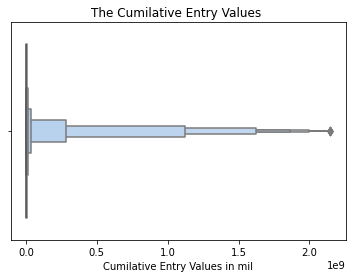

In [45]:
# Entry Cumilative values
(sns.boxenplot(x='Entries', data=mta_import, palette="pastel")
          .set(xlabel= 'Cumilative Entry Values in mil', 
           title="The Cumilative Entry Values "));

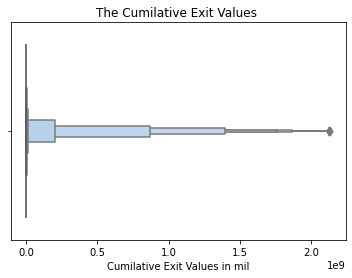

In [44]:
# Exit Cumilative values
(sns.boxenplot(x='Exits', data=mta_import, palette="pastel")
          .set(xlabel= 'Cumilative Exit Values in mil', 
           title="The Cumilative Exit Values "));

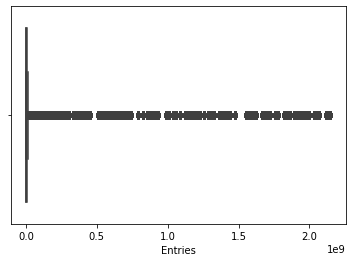

In [63]:
sns.boxplot(x=mta_import.Entries, data= mta_import);

## 1. Group by Station Location and Look at the median values

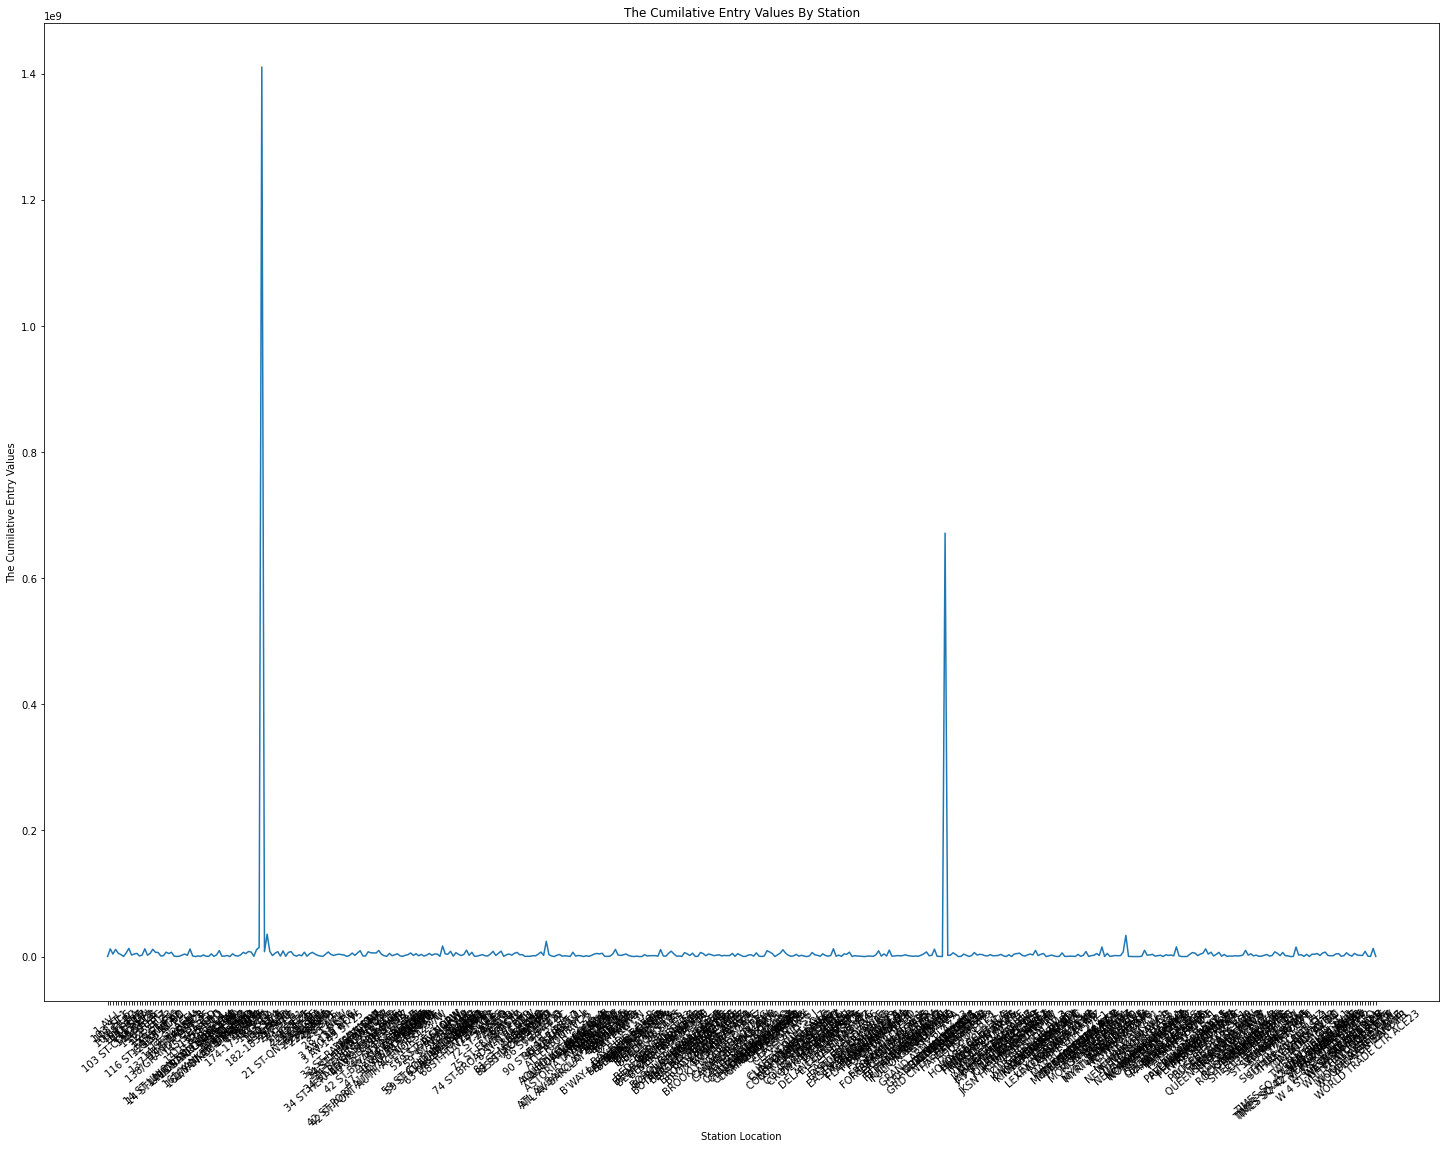

In [16]:
# Entries by Station Location
station_entries = mta_import.groupby("Station_loc")['Entries'].median().reset_index()

plt.figure(figsize = (25,18))
plt.plot(station_entries.Station_loc, station_entries.Entries)

plt.ylabel('The Cumilative Entry Values')
plt.xlabel('Station Location')
plt.xticks(rotation=40)
plt.title('The Cumilative Entry Values By Station');

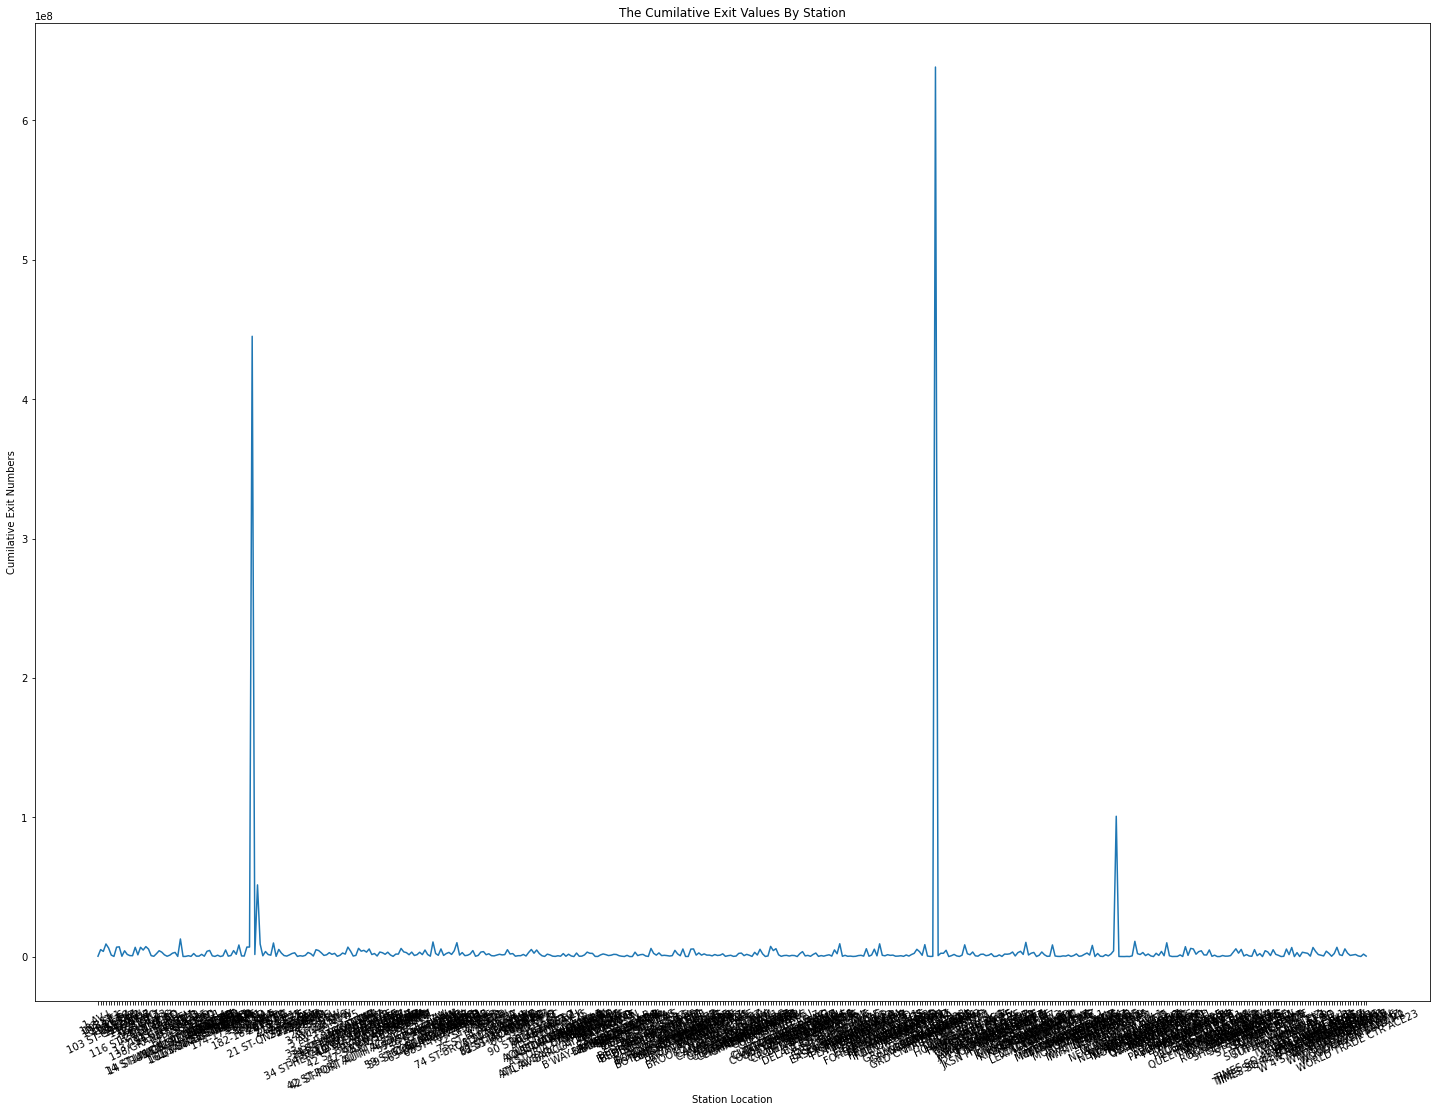

In [47]:
# Entries by Station Location
station_exits = mta_import.groupby("Station_loc")['Exits'].median().reset_index()

plt.figure(figsize = (25,18))
plt.plot(station_exits.Station_loc, station_exits.Exits)

plt.ylabel('Cumilative Exit Numbers')
plt.xlabel('Station Location')
plt.xticks(rotation=25)
plt.title('The Cumilative Exit Values By Station');

## 2. By Date

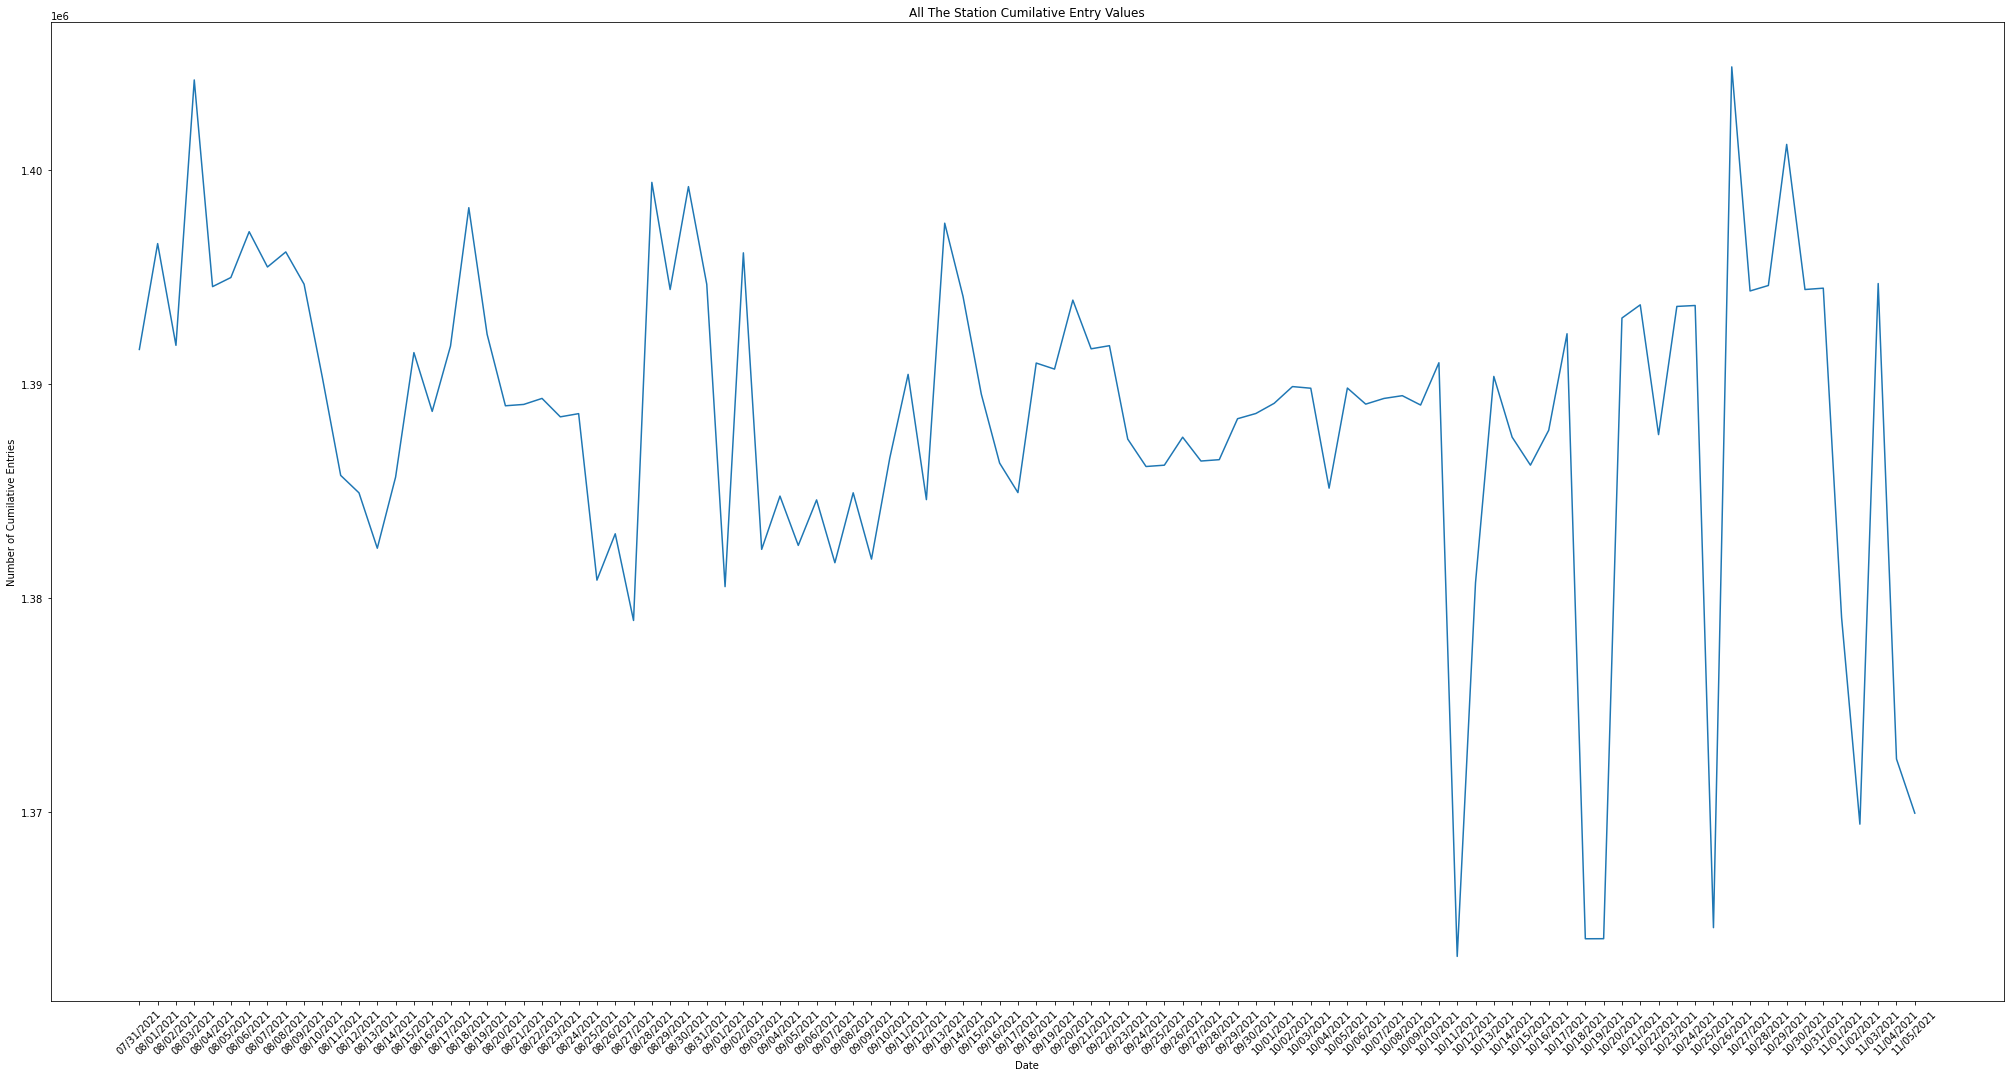

In [50]:
# Entries by Date
by_date = mta_import.groupby('Date')['Entries'].median().reset_index()

plt.figure(figsize = (35,18))
plt.plot(by_date.Date, by_date.Entries)

plt.ylabel('Number of Cumilative Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Values');

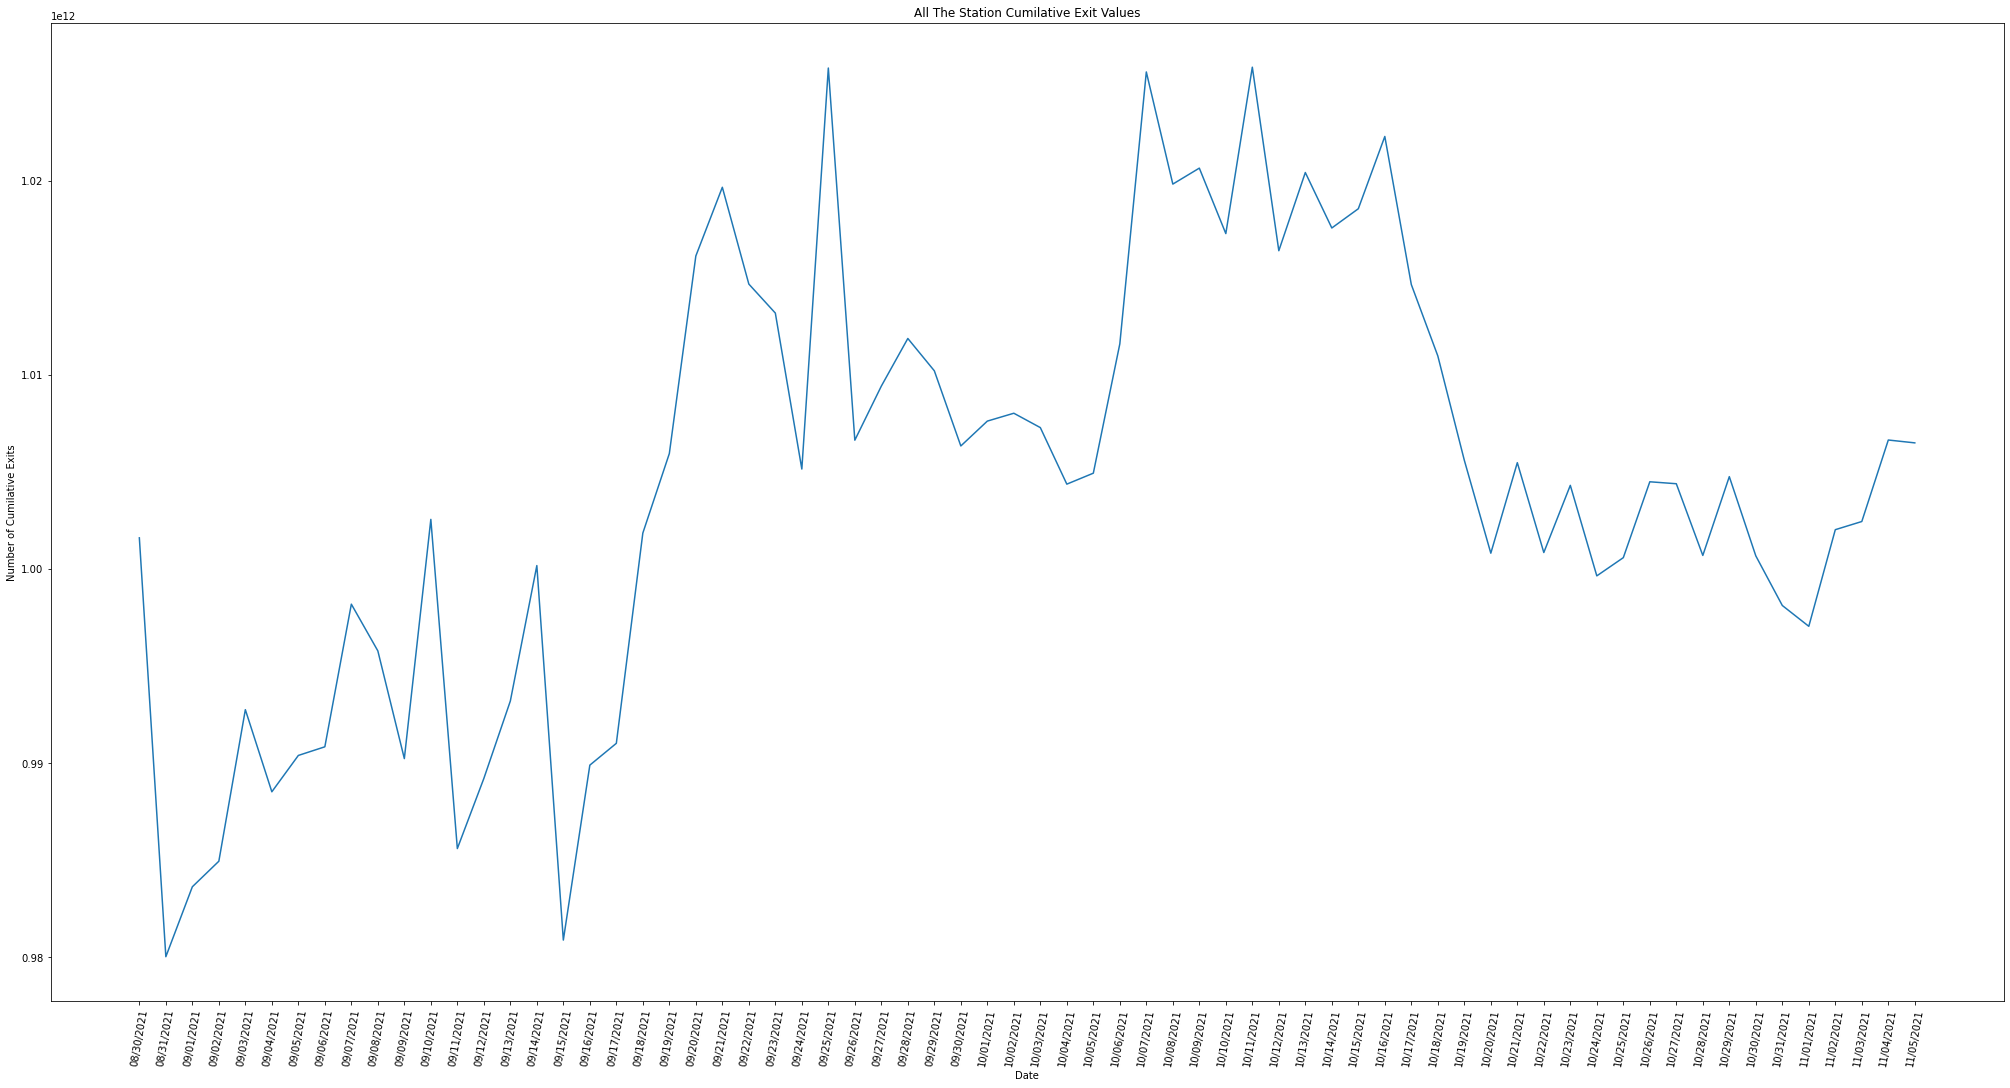

In [53]:
# Exits by median
date_exits = mta_import.groupby('Date')['Exits'].sum().reset_index()

plt.figure(figsize = (35,18))
plt.plot(date_exits.Date[30:], date_exits.Exits[30:])

plt.ylabel('Number of Cumilative Exits')
plt.xlabel('Date')
plt.xticks(rotation=80)
plt.title('All The Station Cumilative Exit Values');

## 3. Group by Day Name [Mon, Tue...]

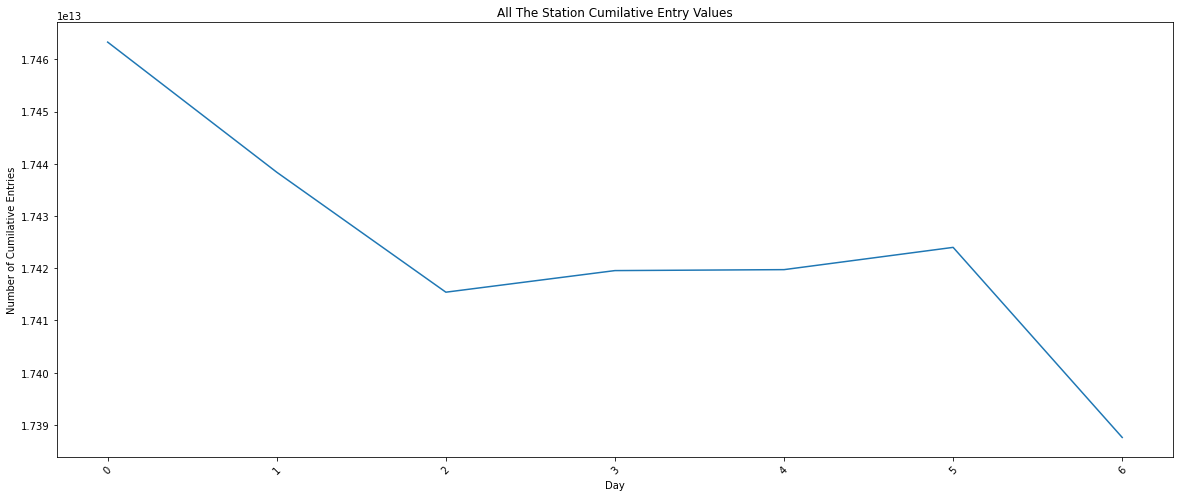

In [51]:
#By Day Name
day_name = mta_import.groupby('Day#')['Entries'].sum().reset_index()

plt.figure(figsize = (20,8))
plt.plot(day_name['Day#'], day_name.Entries)

plt.ylabel('Number of Cumilative Entries')
plt.xlabel('Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Values');

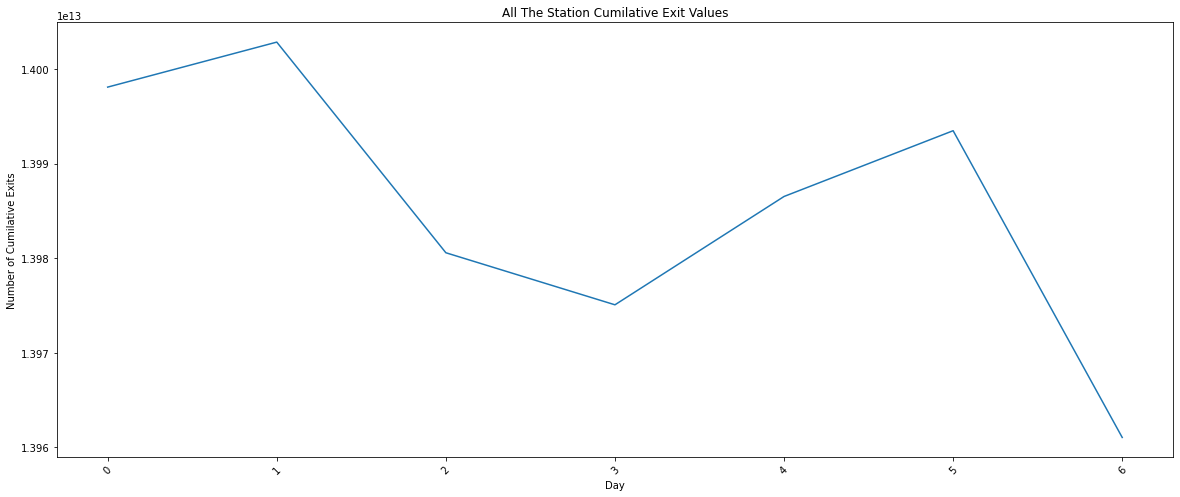

In [52]:
#By Day Name
day_nameExit = mta_import.groupby('Day#')['Exits'].sum().reset_index()

plt.figure(figsize = (20,8))
plt.plot(day_nameExit['Day#'], day_nameExit.Exits)

plt.ylabel('Number of Cumilative Exits')
plt.xlabel('Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Exit Values');

## 4. By Weekday Or Weekend

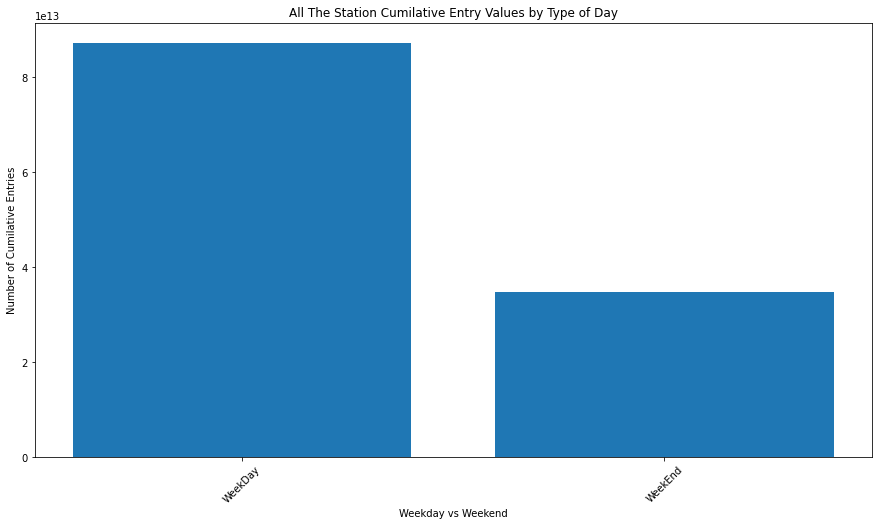

In [30]:
#Weekday vs Weekend
end_day = mta_import.groupby('DayType')['Entries'].sum().reset_index()

plt.figure(figsize = (15,8))
plt.bar(end_day.DayType, end_day.Entries)

plt.ylabel('Number of Cumilative Entries')
plt.xlabel('Weekday vs Weekend')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Values by Type of Day');

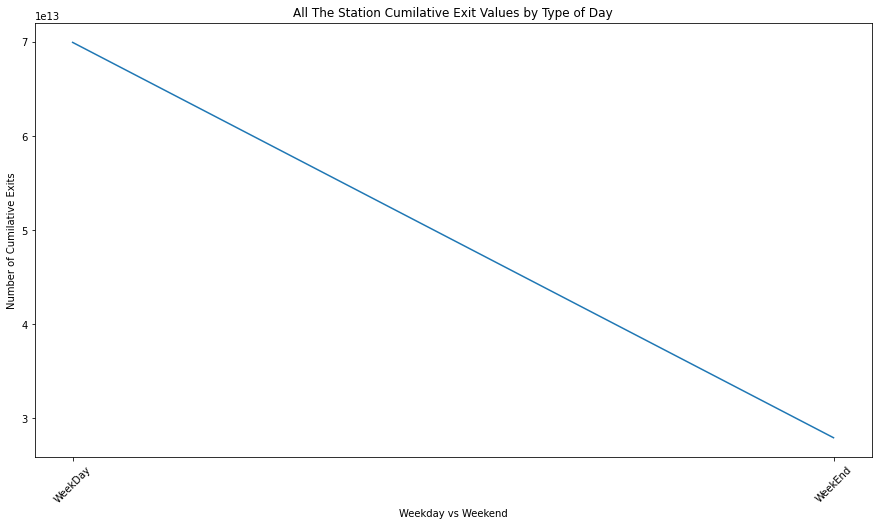

In [32]:
#Weekday vs Weekend
end_dayExit = mta_import.groupby('DayType')['Exits'].sum().reset_index()

plt.figure(figsize = (15,8))
plt.plot(end_dayExit.DayType, end_dayExit.Exits)

plt.ylabel('Number of Cumilative Exits')
plt.xlabel('Weekday vs Weekend')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Exit Values by Type of Day');

## 5. Group by Hour of day

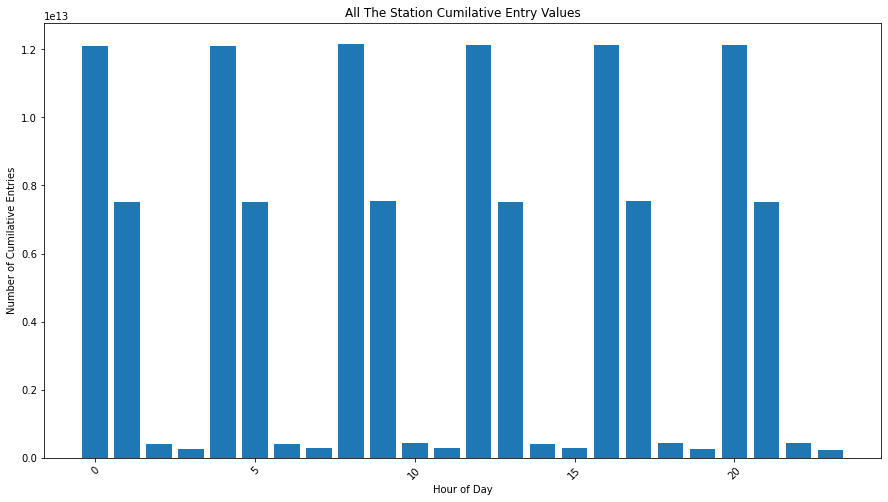

In [33]:
#By Hour of Day
hour_dayEntries = mta_import.groupby('Hour')['Entries'].sum().reset_index()

plt.figure(figsize = (15,8))
plt.bar(hour_dayEntries.Hour, hour_dayEntries.Entries)

plt.ylabel('Number of Cumilative Entries')
plt.xlabel('Hour of Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Values');

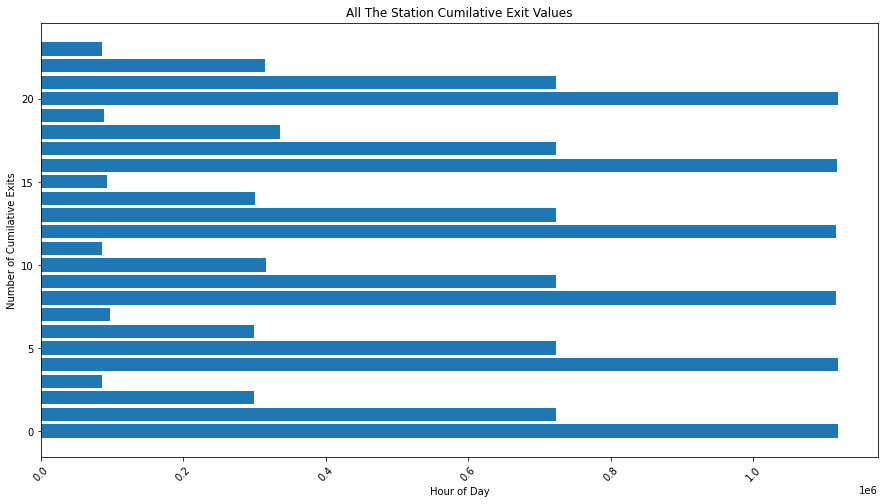

In [35]:
#By Hour of Day
hour_day = mta_import.groupby('Hour')['Exits'].median().reset_index()

plt.figure(figsize = (15,8))
plt.barh(hour_day.Hour, hour_day.Exits)

plt.ylabel('Number of Cumilative Exits')
plt.xlabel('Hour of Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Exit Values');

## 6. Finally, let's look at it grouped by Turnstile

Text(0.5, 1.0, 'All The Station Cumilative Entry Values')

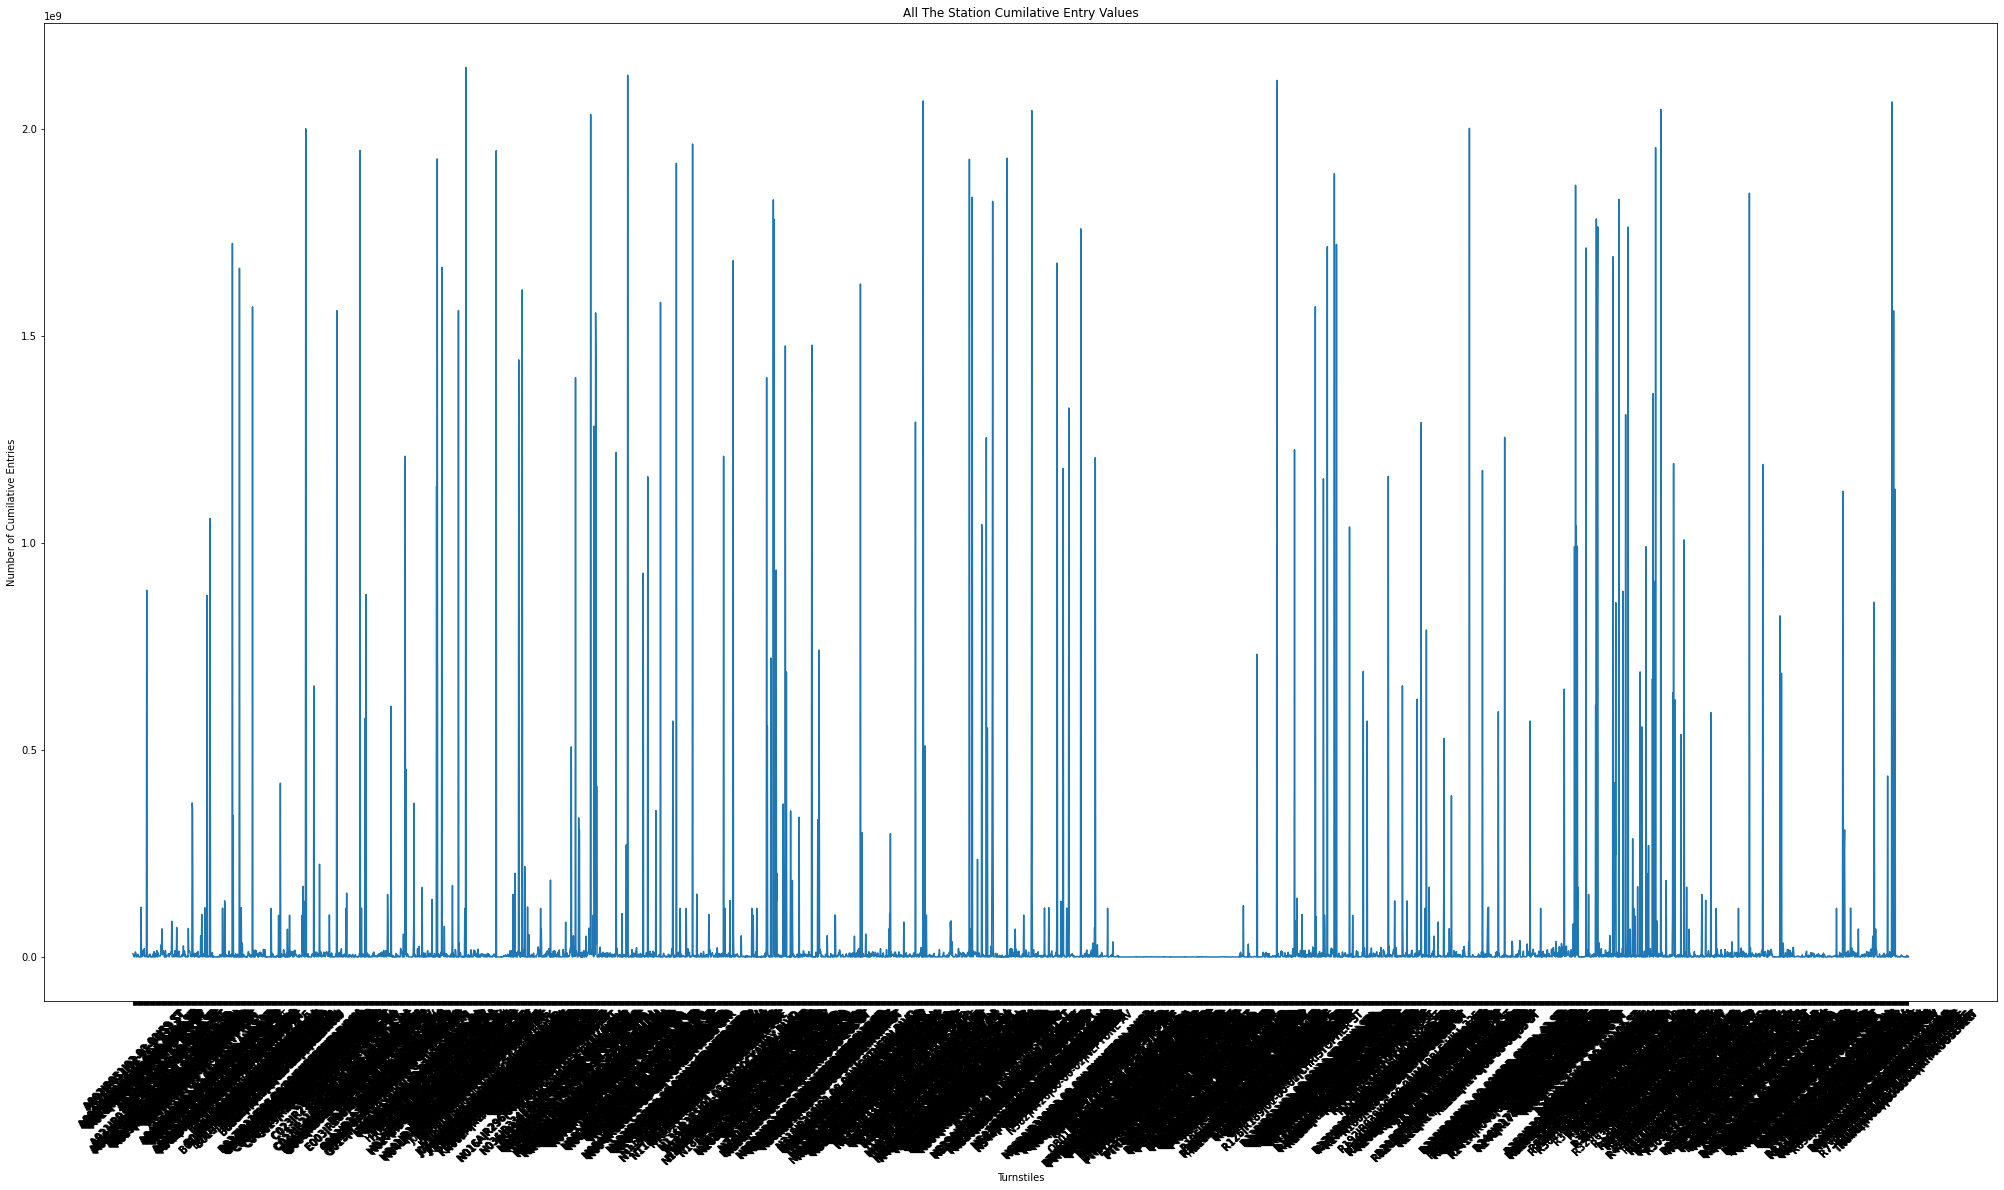

In [36]:
#By Turnstile
by_turnstile = mta_import.groupby('Turnstile')['Entries'].median().reset_index()

plt.figure(figsize = (35,18))
plt.plot(by_turnstile.Turnstile, by_turnstile.Entries)

plt.ylabel('Number of Cumilative Entries')
plt.xlabel('Turnstiles')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Values');

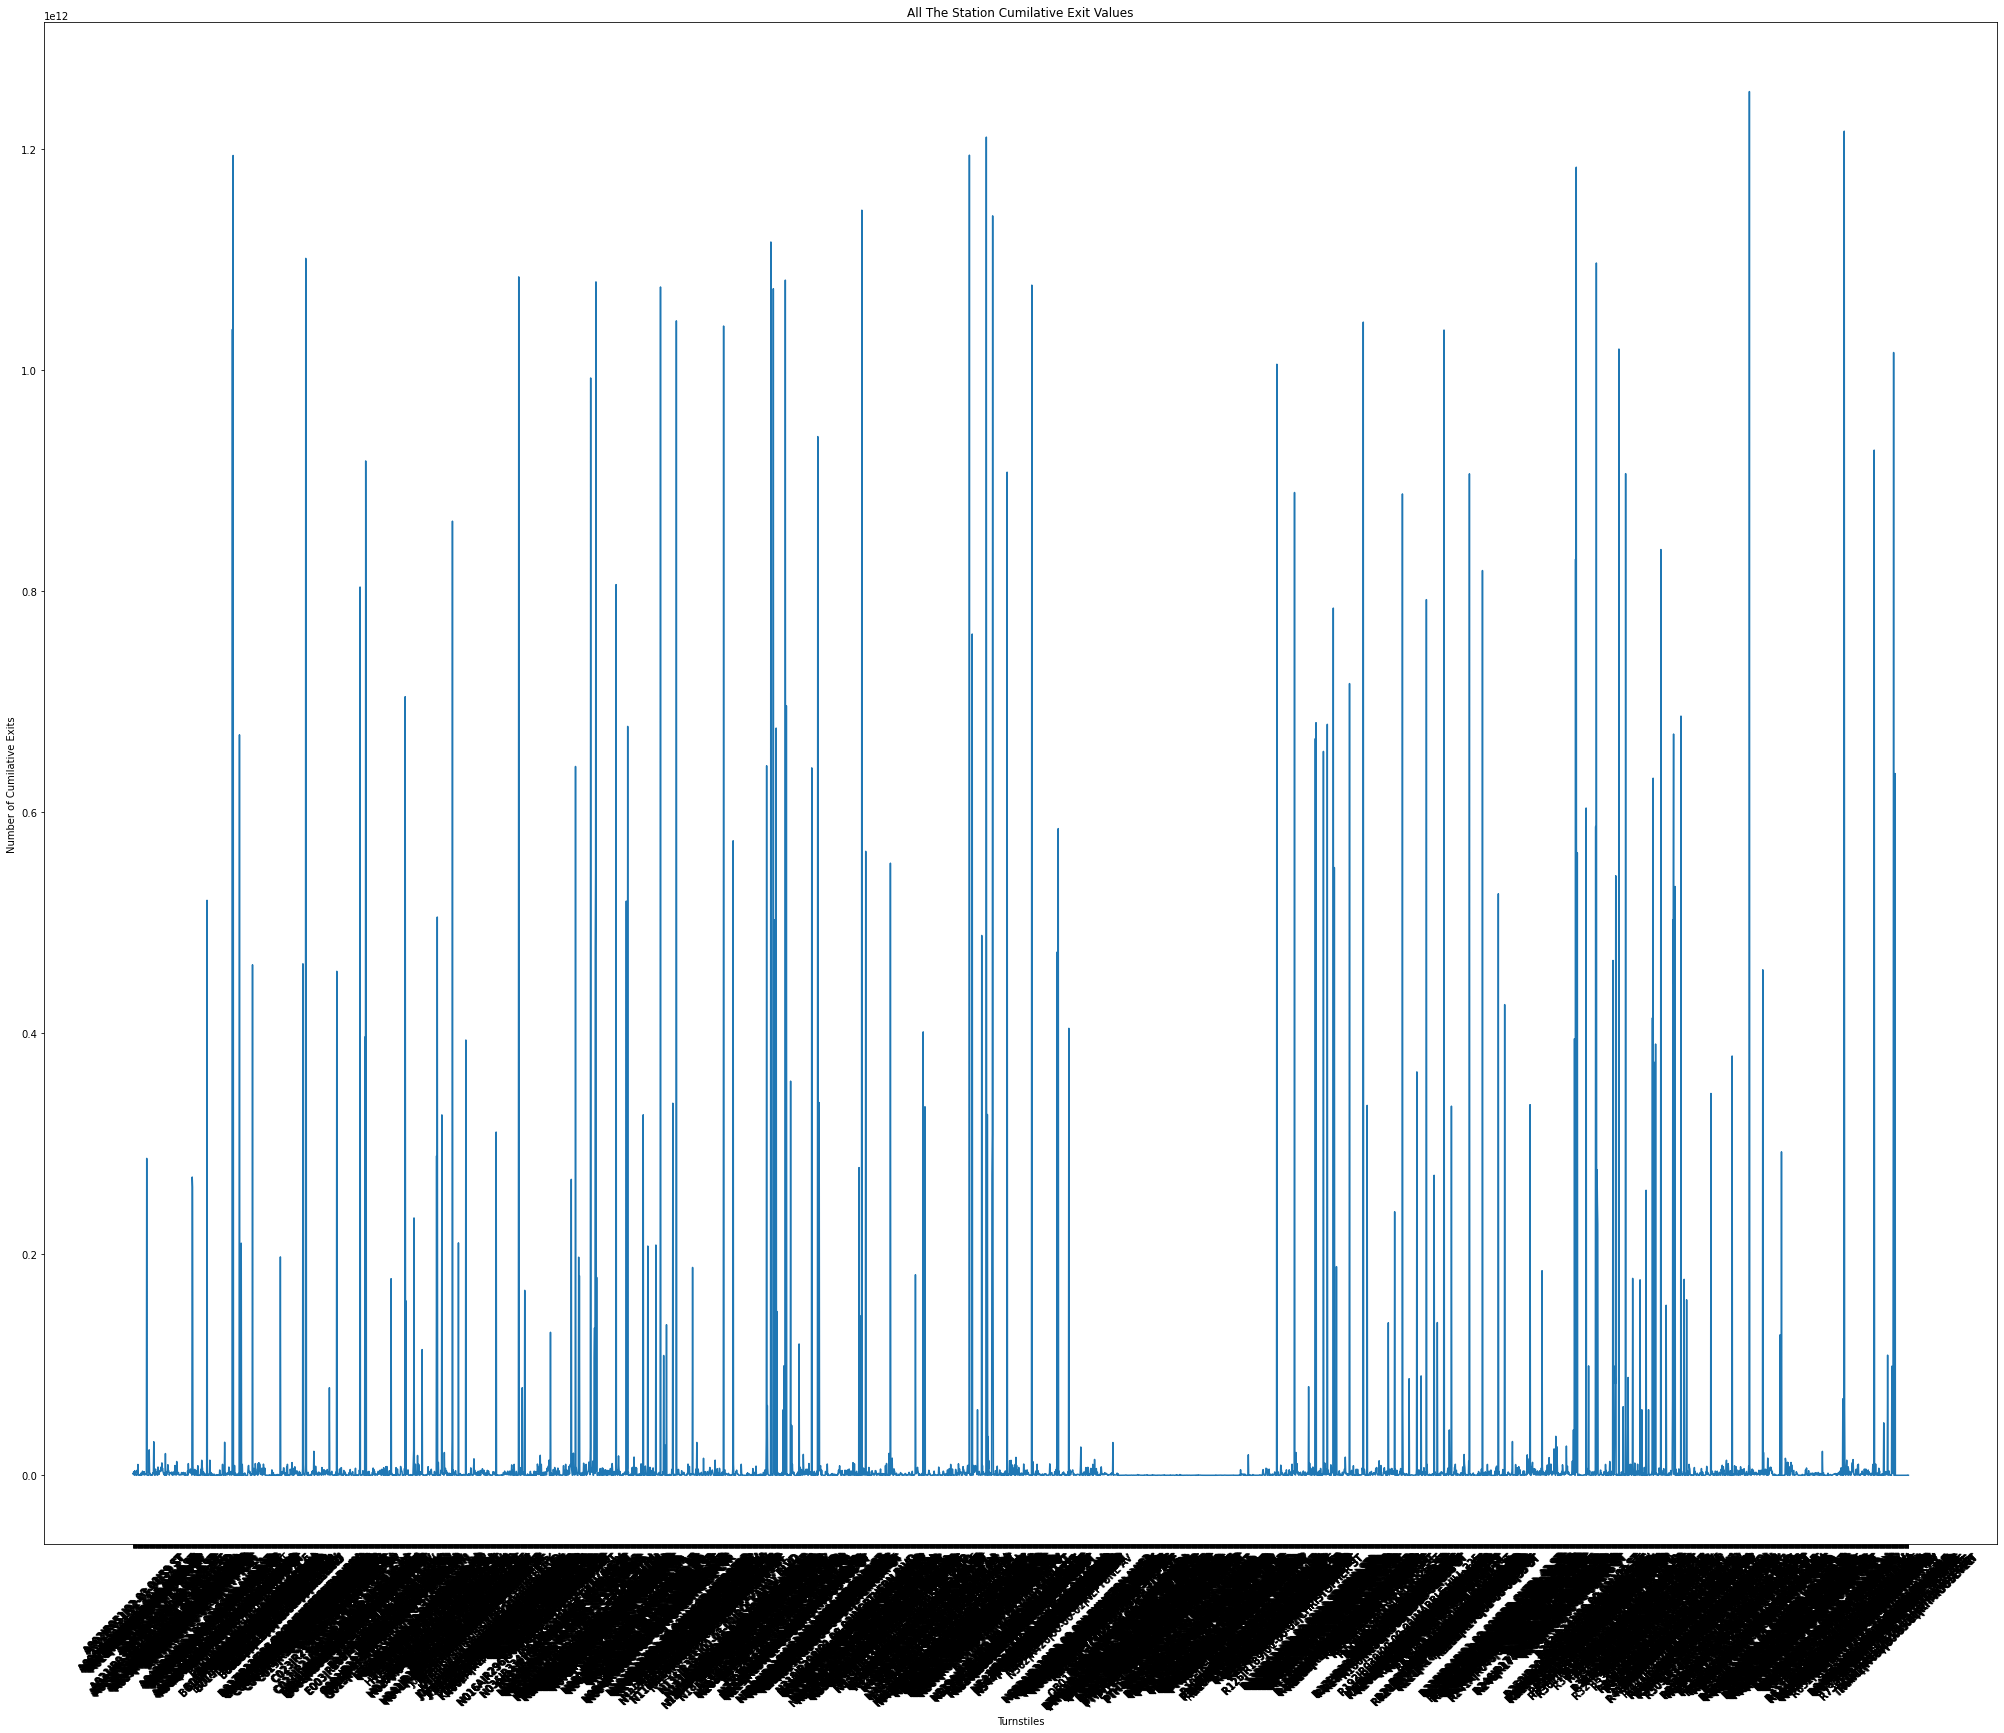

In [37]:
#By Turnstile
by_turnstile_exits = mta_import.groupby('Turnstile')['Exits'].sum().reset_index()

plt.figure(figsize = (35,28))
plt.plot(by_turnstile_exits.Turnstile, by_turnstile_exits.Exits)

plt.ylabel('Number of Cumilative Exits')
plt.xlabel('Turnstiles')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Exit Values');

## Key Findings From Above Visualization to be researched
1. By Station Location 
    - There are a few abnormal stations
    
2. By Date 
    - The flow of traffic seems to have changed in October
    
3. By Day 
    - There is a significant drop off in usage between weekday and weekend
    
4. By Hour of Day 
    - The reporting of number of entries and exiits are mostly reported every 4 hours starting at midnight. There are various reporting times.

## Clean Data by starting with duplicate records

In [54]:
mta_import.columns

Index(['C/A', 'Unit', 'Scp', 'Station', 'Linename', 'Division', 'Date', 'Time',
       'Desc', 'Entries', 'Exits', 'Turnstile', 'Station_loc', 'DateNTime',
       'Day', 'Day#', 'DayType', 'Hour'],
      dtype='object')

In [57]:
#Create Dataframes for both Entries and Exits that are duplicates
entries_multiple = (mta_import
                        .groupby(['Turnstile', 'Station_loc', 'DateNTime'])
                        ['Entries'].count()
                        .reset_index()
                        .sort_values('Entries', ascending=False))

#Entry Duplicates
entries_dups = entries_multiple[entries_multiple['Entries'] > 1].shape
print(f'Entries that have duplicate records are: {entries_dups}')



exit_multiple = (mta_import
                        .groupby(['Turnstile', 'Station_loc', 'DateNTime'])
                        ['Exits'].count()
                        .reset_index()
                        .sort_values('Exits', ascending=False))
#Exit Duplicates
exit_dups = exit_multiple[exit_multiple['Exits'] > 1].shape
print(f'Exits that have duplicate records are: {exit_dups}')


Entries that have duplicate records are: (155, 4)
Exits that have duplicate records are: (155, 4)


## Look at a few of the duplicate records to understand why

In [58]:
entries_multiple.head()

Turnstile       Station_loc  \
2919548      S101|R070|00-00-02|ST. GEORGE      ST. GEORGE 1   
2919420      S101|R070|00-00-02|ST. GEORGE      ST. GEORGE 1   
2919364      S101|R070|00-00-02|ST. GEORGE      ST. GEORGE 1   
2919417      S101|R070|00-00-02|ST. GEORGE      ST. GEORGE 1   
2669573  R523|R147|00-00-07|61 ST WOODSIDE  61 ST WOODSIDE 7   

                  DateNTime  Entries  
2919548 2021-10-02 16:00:00        2  
2919420 2021-09-11 12:00:00        2  
2919364 2021-09-02 08:00:00        2  
2919417 2021-09-11 00:00:00        2  
2669573 2021-08-18 05:00:00        2

In [59]:
mta_import[(mta_import['Turnstile'] == 'S101|R070|00-00-02|ST. GEORGE') & (mta_import['DateNTime'] == '2021-10-02 16:00:00')]

C/A  Unit       Scp     Station Linename Division        Date  \
208039  S101  R070  00-00-02  ST. GEORGE        1      SRT  10/02/2021   
208040  S101  R070  00-00-02  ST. GEORGE        1      SRT  10/02/2021   

            Time        Desc  Entries  Exits                      Turnstile  \
208039  16:00:00     REGULAR  1400930    324  S101|R070|00-00-02|ST. GEORGE   
208040  16:00:00  RECOVR AUD  1217237    140  S101|R070|00-00-02|ST. GEORGE   

         Station_loc           DateNTime  Day  Day#  DayType  Hour  
208039  ST. GEORGE 1 2021-10-02 16:00:00  Sat     5  WeekEnd    16  
208040  ST. GEORGE 1 2021-10-02 16:00:00  Sat     5  WeekEnd    16

In [60]:
mta_import[(mta_import['Turnstile'] == 'R523|R147|00-00-07|61 ST WOODSIDE') & (mta_import['DateNTime'] == '2021-08-18 05:00:00	')]

C/A  Unit       Scp         Station Linename Division        Date  \
190325  R523  R147  00-00-07  61 ST WOODSIDE        7      IRT  08/18/2021   
190326  R523  R147  00-00-07  61 ST WOODSIDE        7      IRT  08/18/2021   

            Time        Desc   Entries    Exits  \
190325  05:00:00     REGULAR  22112576  4491111   
190326  05:00:00  RECOVR AUD  22112575  4491111   

                                Turnstile       Station_loc  \
190325  R523|R147|00-00-07|61 ST WOODSIDE  61 ST WOODSIDE 7   
190326  R523|R147|00-00-07|61 ST WOODSIDE  61 ST WOODSIDE 7   

                 DateNTime  Day  Day#  DayType  Hour  
190325 2021-08-18 05:00:00  Wed     2  WeekDay     5  
190326 2021-08-18 05:00:00  Wed     2  WeekDay     5

In [61]:
mta_import.Desc.value_counts()

REGULAR       2923003
RECOVR AUD      12813
Name: Desc, dtype: int64

## The duplicate records point to a "Recover Aud"
Since there are no documentation to validate these entries:
1. Delete any duplicate records by Turnstile, Station and DateNTime
2. Use records that have a "REGULAR" entry instead of "RECOVER AUD"

In [62]:
# Drop Duplicate records
mta_import.sort_values(['Turnstile', 'Station_loc', 'DateNTime'], 
                          inplace=True, ascending=False)

mta_import.drop_duplicates(subset=['Turnstile', 'Station_loc', 'DateNTime'], inplace=True)

In [71]:
original_data = mta_import.shape
original_data

(2935661, 18)

In [72]:
mta_regular = mta_import[mta_import['Desc'] == 'REGULAR']
only_regular = mta_regular.shape
only_regular

(2923003, 18)

In [73]:
diff = original_data[0] - only_regular[0]
print(f'The number of records dropped from the original data are: {diff}')

The number of records dropped from the original data are: 12658


## Now, let's calculate the cumilative differences

In [76]:
turnstile = ["C/A", "Unit", "Scp"]

sort_filter = ["C/A", "Unit", "Scp", "Date", "Time"]


#Using the filtered data containing only REGULAR records
mta_diffs = mta_regular.sort_values(sort_filter).reset_index()
mta_diffs_group = mta_diffs.groupby(turnstile)

mta_diffs["Entries_Diff"] = mta_diffs_group["Entries"].transform(pd.Series.diff)
mta_diffs["Exits_Diff"] = mta_diffs_group["Exits"].transform(pd.Series.diff)

print(mta_diffs.shape)
mta_diffs.head()


(2923003, 21)


index   C/A  Unit       Scp Station Linename Division        Date  \
0      0  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021   
1      1  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021   
2      2  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021   
3      3  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021   
4      4  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021   

       Time     Desc  ...    Exits                 Turnstile    Station_loc  \
0  00:00:00  REGULAR  ...  2603110  A002|R051|02-00-00|59 ST  59 ST NQR456W   
1  04:00:00  REGULAR  ...  2603113  A002|R051|02-00-00|59 ST  59 ST NQR456W   
2  08:00:00  REGULAR  ...  2603126  A002|R051|02-00-00|59 ST  59 ST NQR456W   
3  12:00:00  REGULAR  ...  2603178  A002|R051|02-00-00|59 ST  59 ST NQR456W   
4  16:00:00  REGULAR  ...  2603211  A002|R051|02-00-00|59 ST  59 ST NQR456W   

            DateNTime  Day Day#  DayType Hour  Entries_Diff  Exits_Diff  
0 2021-07-31 00:00:00  Sat    5  WeekEnd    0           NaN         NaN  
1 2021-07-31 04:00:00  Sat    5  WeekEnd    4          11.0         3.0  
2 2021-07-31 08:00:00  Sat    5  WeekEnd    8           5.0        13.0  
3 2021-07-31 12:00:00  Sat    5  WeekEnd   12          38.0        52.0  
4 2021-07-31 16:00:00  Sat    5  WeekEnd   16         122.0        33.0  

[5 rows x 21 columns]

In [77]:
# Drop  NaN
mta_diffs.dropna(subset=["Entries_Diff"], axis=0, inplace=True)
mta_diffs.head()

index   C/A  Unit       Scp Station Linename Division        Date  \
1      1  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021   
2      2  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021   
3      3  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021   
4      4  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021   
5      5  A002  R051  02-00-00   59 ST  NQR456W      BMT  07/31/2021   

       Time     Desc  ...    Exits                 Turnstile    Station_loc  \
1  04:00:00  REGULAR  ...  2603113  A002|R051|02-00-00|59 ST  59 ST NQR456W   
2  08:00:00  REGULAR  ...  2603126  A002|R051|02-00-00|59 ST  59 ST NQR456W   
3  12:00:00  REGULAR  ...  2603178  A002|R051|02-00-00|59 ST  59 ST NQR456W   
4  16:00:00  REGULAR  ...  2603211  A002|R051|02-00-00|59 ST  59 ST NQR456W   
5  20:00:00  REGULAR  ...  2603241  A002|R051|02-00-00|59 ST  59 ST NQR456W   

            DateNTime  Day Day#  DayType Hour  Entries_Diff  Exits_Diff  
1 2021-07-31 04:00:00  Sat    5  WeekEnd    4          11.0         3.0  
2 2021-07-31 08:00:00  Sat    5  WeekEnd    8           5.0        13.0  
3 2021-07-31 12:00:00  Sat    5  WeekEnd   12          38.0        52.0  
4 2021-07-31 16:00:00  Sat    5  WeekEnd   16         122.0        33.0  
5 2021-07-31 20:00:00  Sat    5  WeekEnd   20         155.0        30.0  

[5 rows x 21 columns]

## Look into cumilative differences calculated


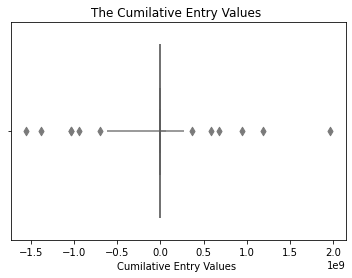

In [82]:
# Entry Cumilative values
(sns.boxenplot(x = 'Entries_Diff', data = mta_diffs, palette = "pastel")
          .set(xlabel = 'Cumilative Entry Values ', 
           title = "The Cumilative Entry Values "));

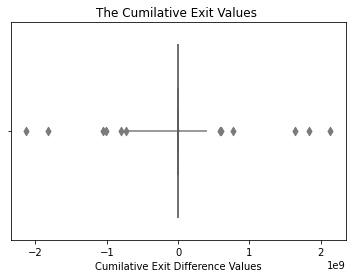

In [81]:
# Exit Cumilative values
(sns.boxenplot(x = 'Exits_Diff', data = mta_diffs, palette = "pastel")
          .set(xlabel = 'Cumilative Exit Difference Values', 
           title = "The Cumilative Exit Values "));

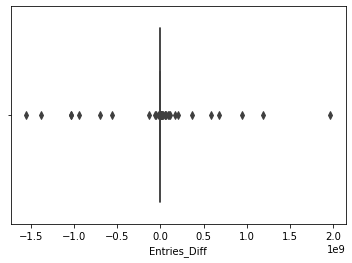

In [83]:
sns.boxplot(x=mta_diffs.Entries_Diff, data= mta_diffs);

## 1. Group by Station Location and Look at the median values

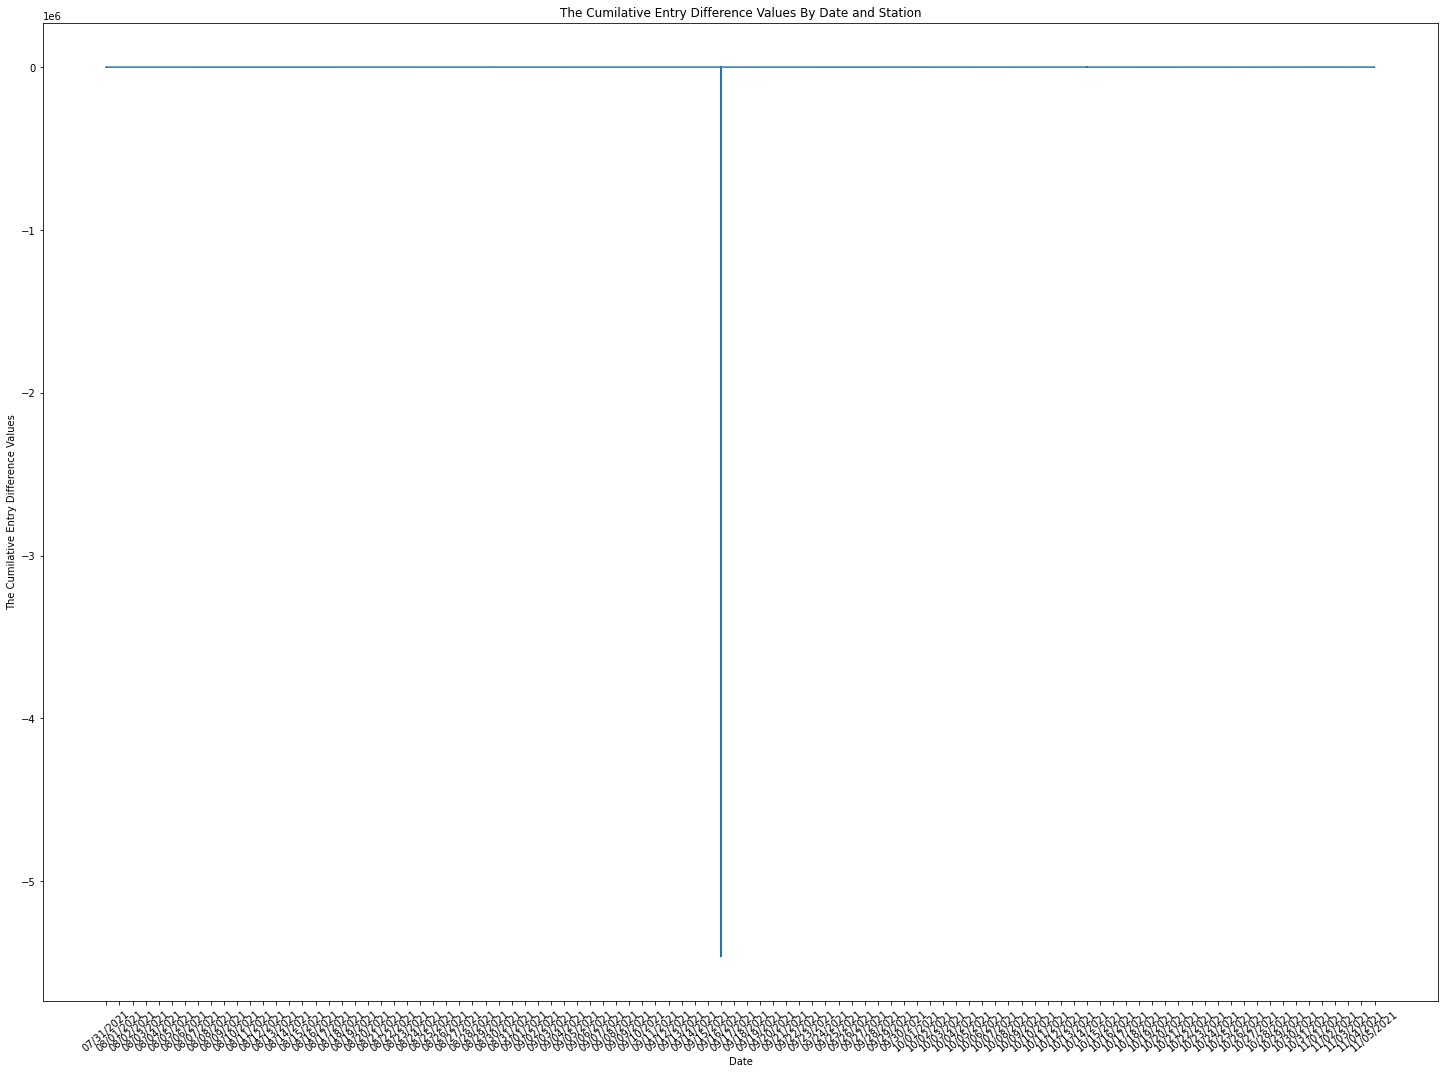

In [101]:
# Entries by Station Location and Date
station_entries = mta_diffs.groupby(["Date", "Station_loc"])['Entries_Diff'].median().reset_index()

plt.figure(figsize = (25,18))
plt.plot(station_entries.Date, station_entries.Entries_Diff)

plt.ylabel('The Cumilative Entry Difference Values')
plt.xlabel('Date')
plt.xticks(rotation=40)
plt.title('The Cumilative Entry Difference Values By Date and Station');

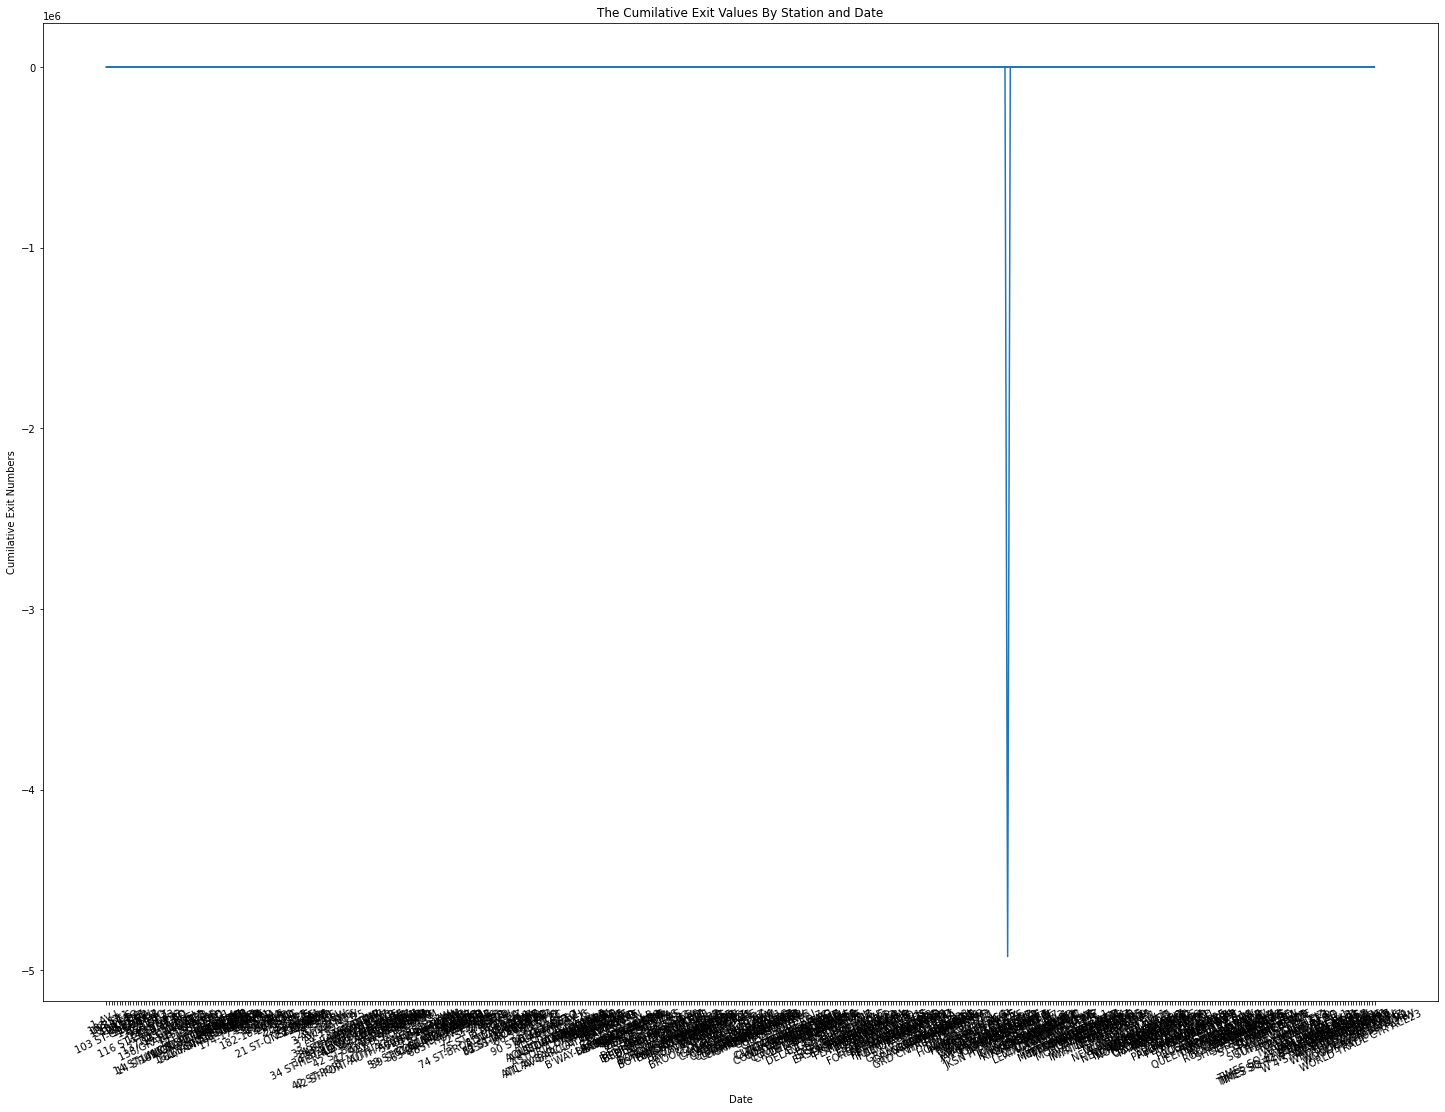

In [102]:
# Entries by Station Location and Date
station_exits = mta_diffs.groupby(["Date", "Station_loc"])['Exits_Diff'].median().reset_index()

plt.figure(figsize = (25,18))
plt.plot(station_exits.Station_loc, station_exits.Exits_Diff)

plt.ylabel('Cumilative Exit Numbers')
plt.xlabel('Date')
plt.xticks(rotation=25)
plt.title('The Cumilative Exit Values By Station and Date');

## 2. By Date

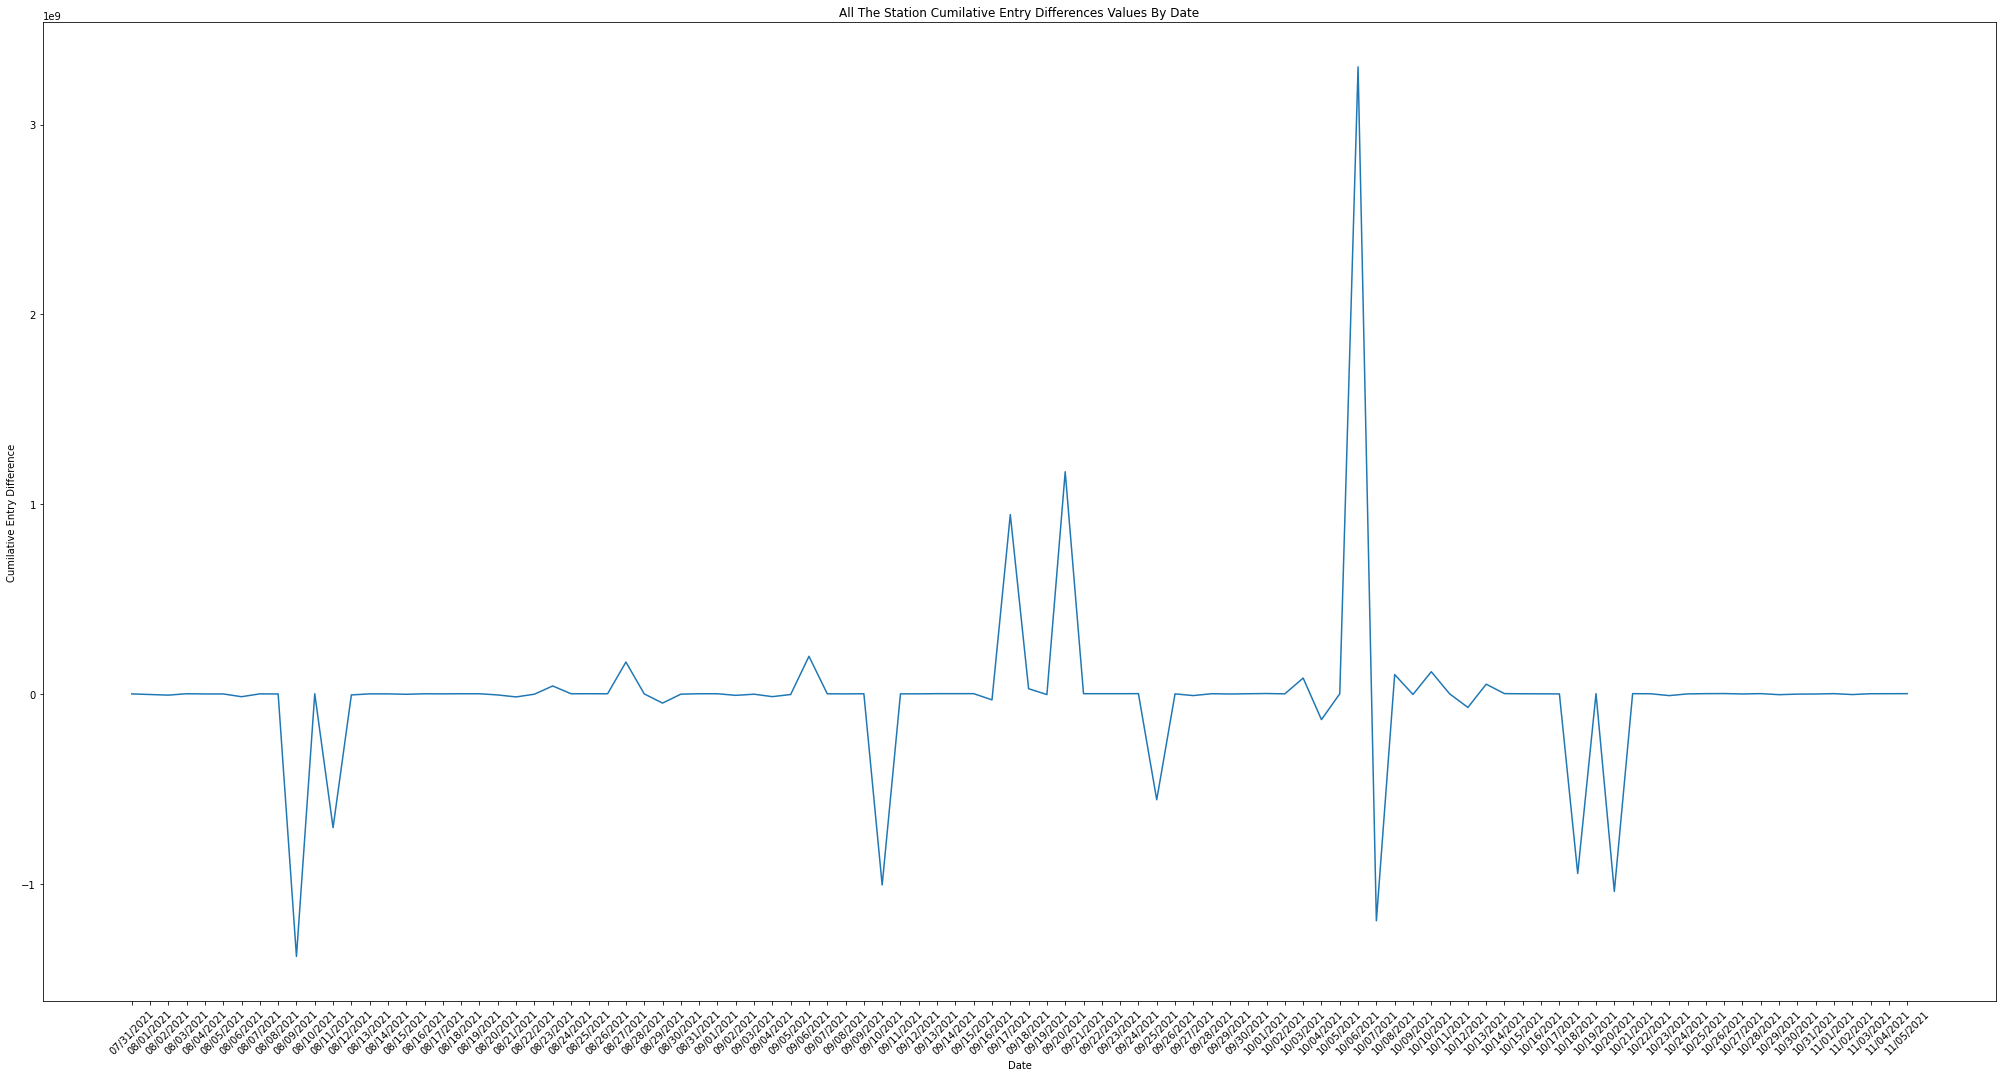

In [104]:
# Entries by Date
by_date = mta_diffs.groupby('Date')['Entries_Diff'].sum().reset_index()

plt.figure(figsize = (35,18))
plt.plot(by_date.Date, by_date.Entries_Diff)

plt.ylabel('Cumilative Entry Difference')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Differences Values By Date');

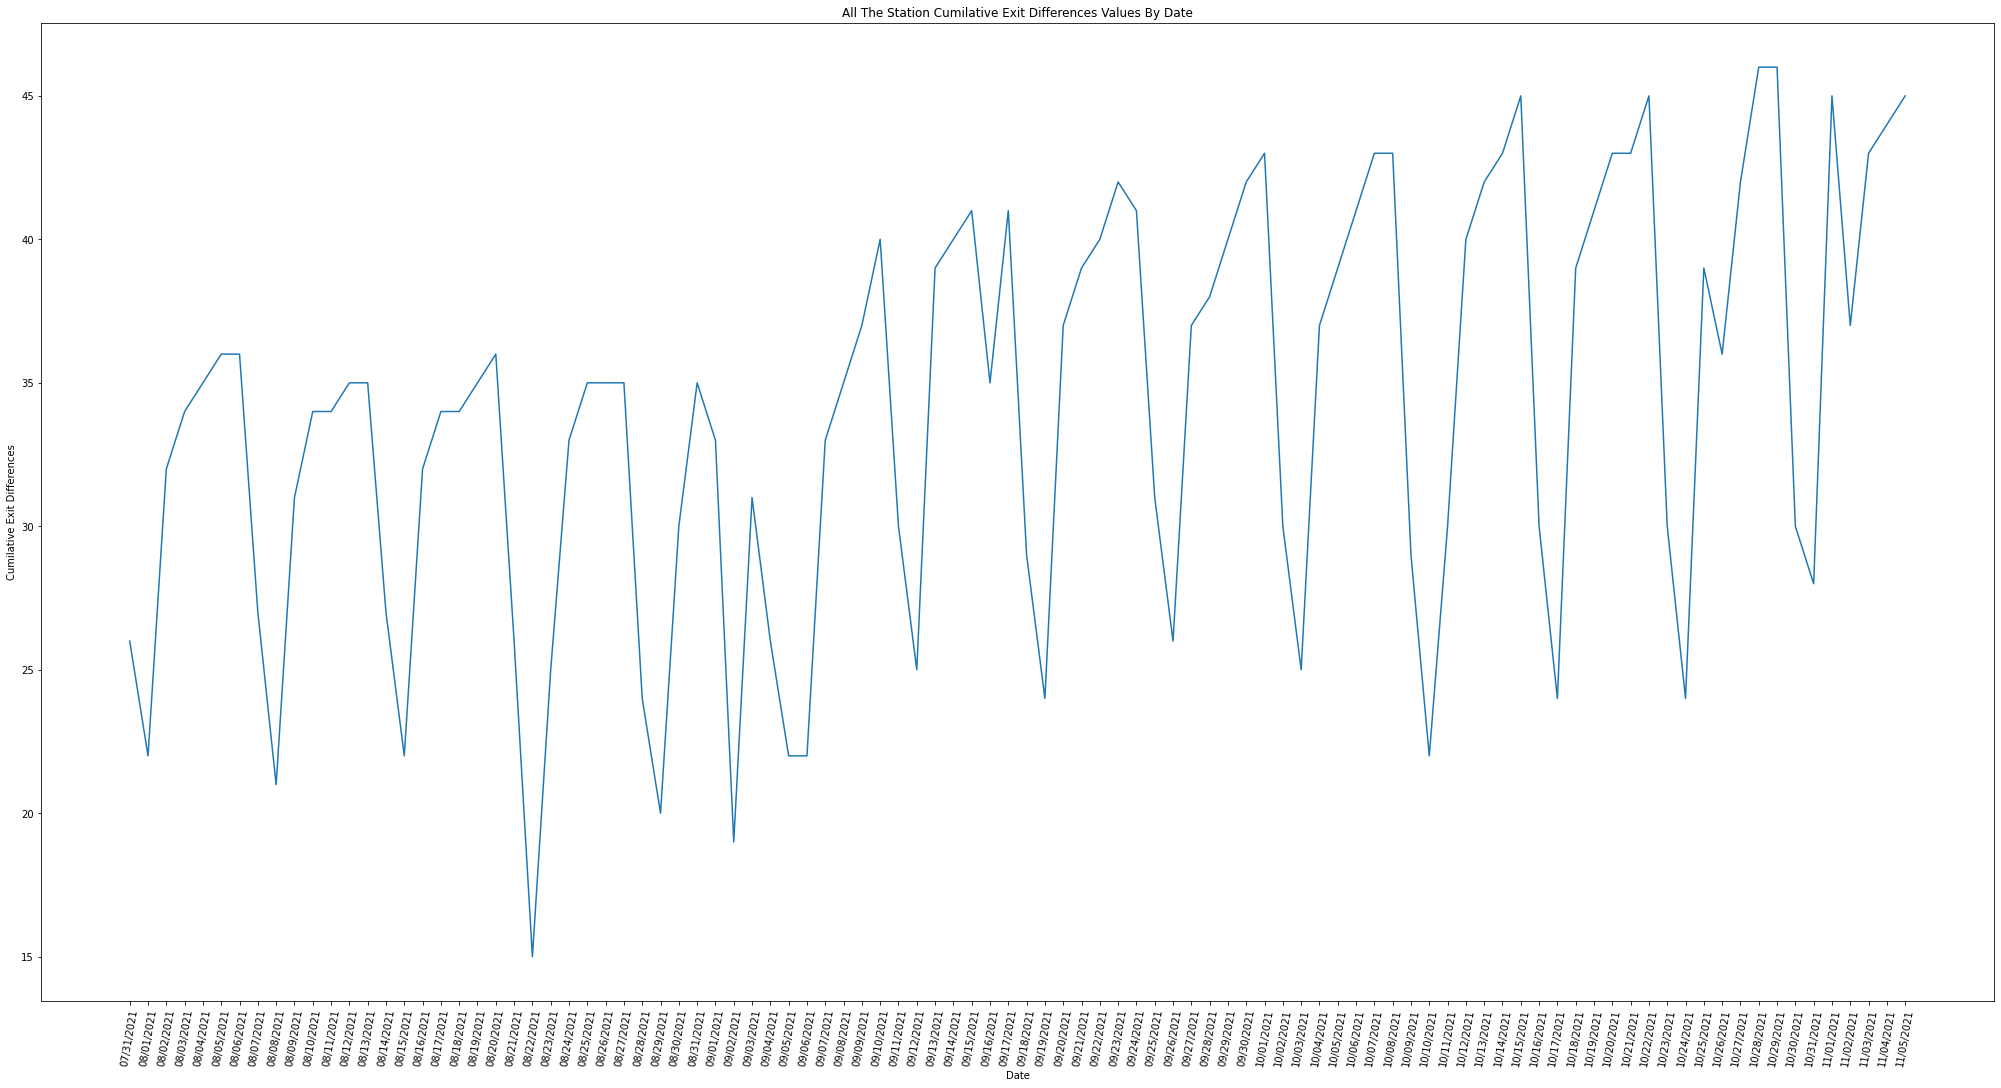

In [103]:
# Exits by median
date_exits = mta_diffs.groupby('Date')['Exits_Diff'].median().reset_index()

plt.figure(figsize = (35,18))
plt.plot(date_exits.Date, date_exits.Exits_Diff)

plt.ylabel('Cumilative Exit Differences')
plt.xlabel('Date')
plt.xticks(rotation=80)
plt.title('All The Station Cumilative Exit Differences Values By Date');

## 3. Group by Day Name [Mon, Tue...]

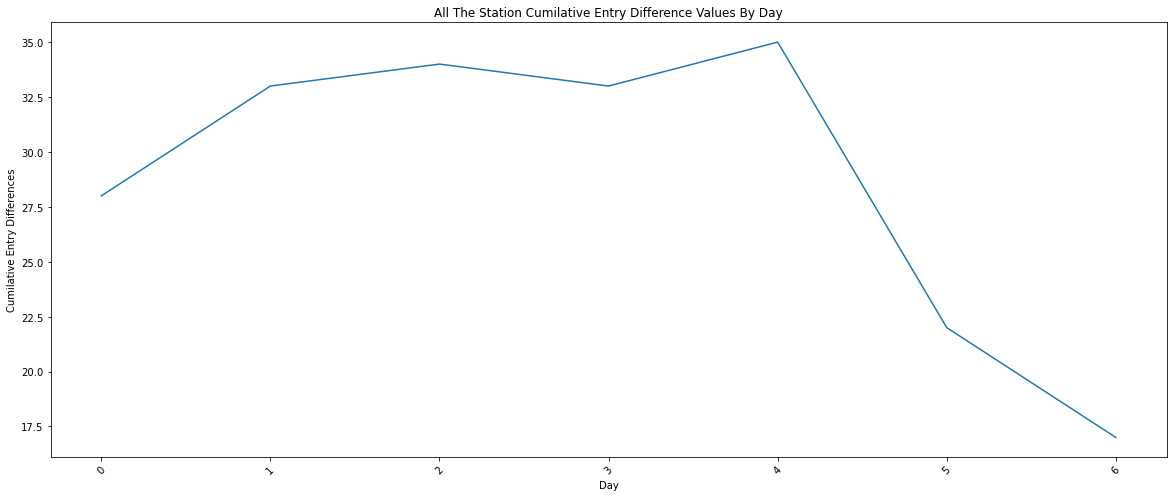

In [92]:
#By Day Name
day_name = mta_diffs.groupby('Day#')['Entries_Diff'].median().reset_index()

plt.figure(figsize = (20,8))
plt.plot(day_name['Day#'], day_name.Entries_Diff)

plt.ylabel('Cumilative Entry Differences')
plt.xlabel('Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Difference Values By Day');

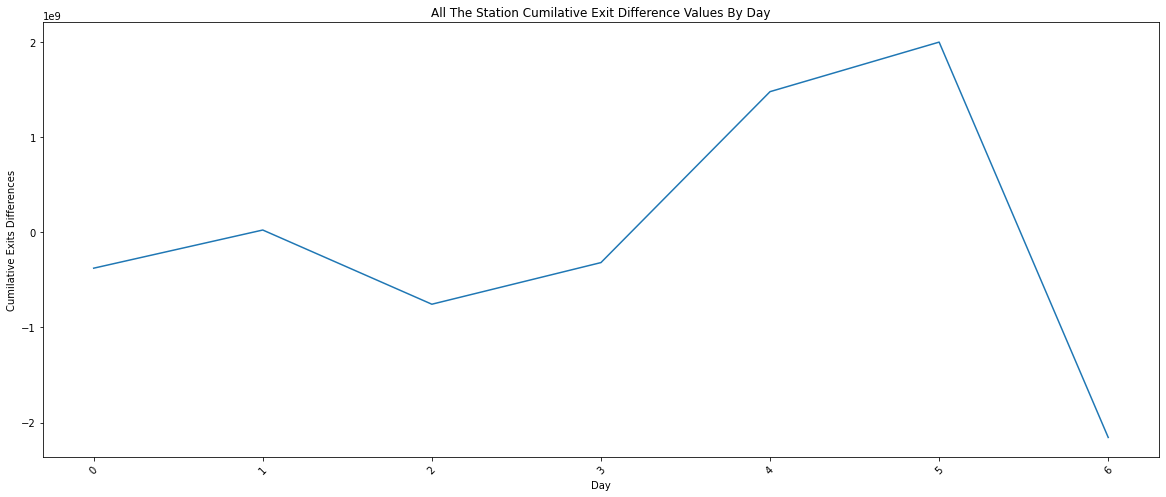

In [94]:
#By Day Name
day_nameExit = mta_diffs.groupby('Day#')['Exits_Diff'].sum().reset_index()

plt.figure(figsize = (20,8))
plt.plot(day_nameExit['Day#'], day_nameExit.Exits_Diff)

plt.ylabel('Cumilative Exits Differences')
plt.xlabel('Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Exit Difference Values By Day');

## 5. Group by Hour of day

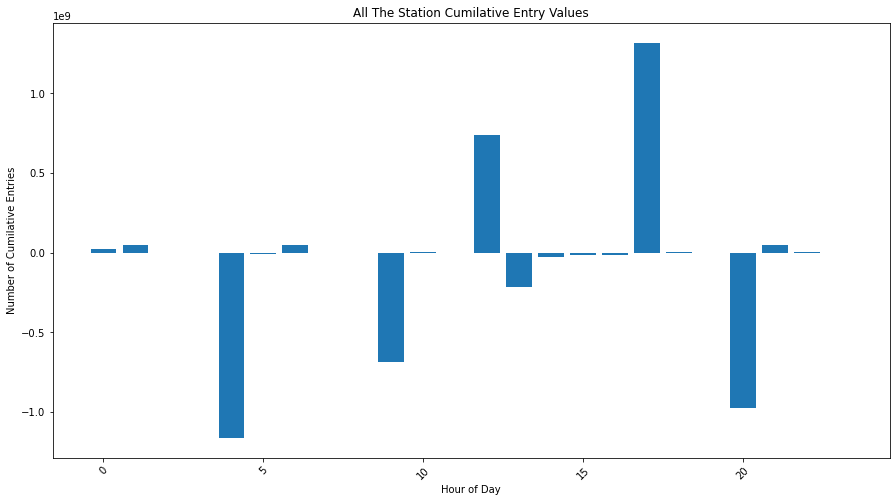

In [96]:
#By Hour of Day
hour_dayEntries = mta_diffs.groupby('Hour')['Entries_Diff'].sum().reset_index()

plt.figure(figsize = (15,8))
plt.bar(hour_dayEntries.Hour, hour_dayEntries.Entries_Diff)

plt.ylabel('Number of Cumilative Entries')
plt.xlabel('Hour of Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Values');

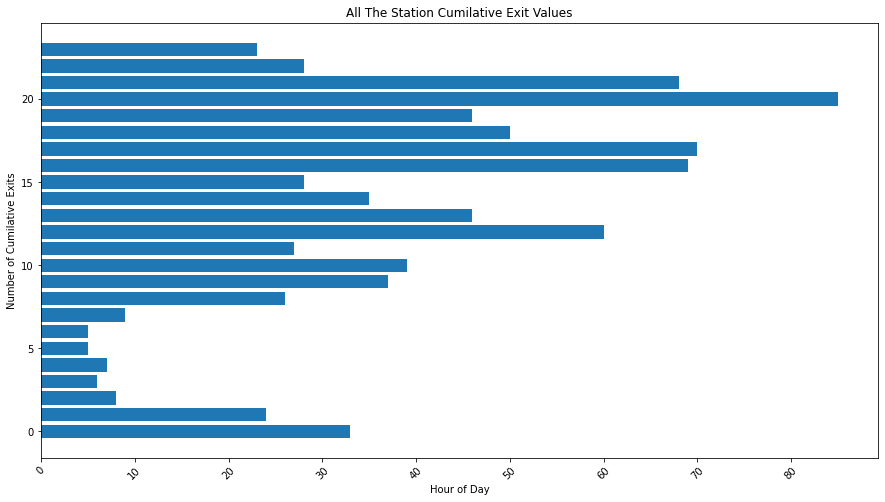

In [97]:
#By Hour of Day
hour_day = mta_diffs.groupby('Hour')['Exits_Diff'].median().reset_index()

plt.figure(figsize = (15,8))
plt.barh(hour_day.Hour, hour_day.Exits_Diff)

plt.ylabel('Number of Cumilative Exits')
plt.xlabel('Hour of Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Exit Values');

## 6. Finally, let's look at it grouped by Turnstile

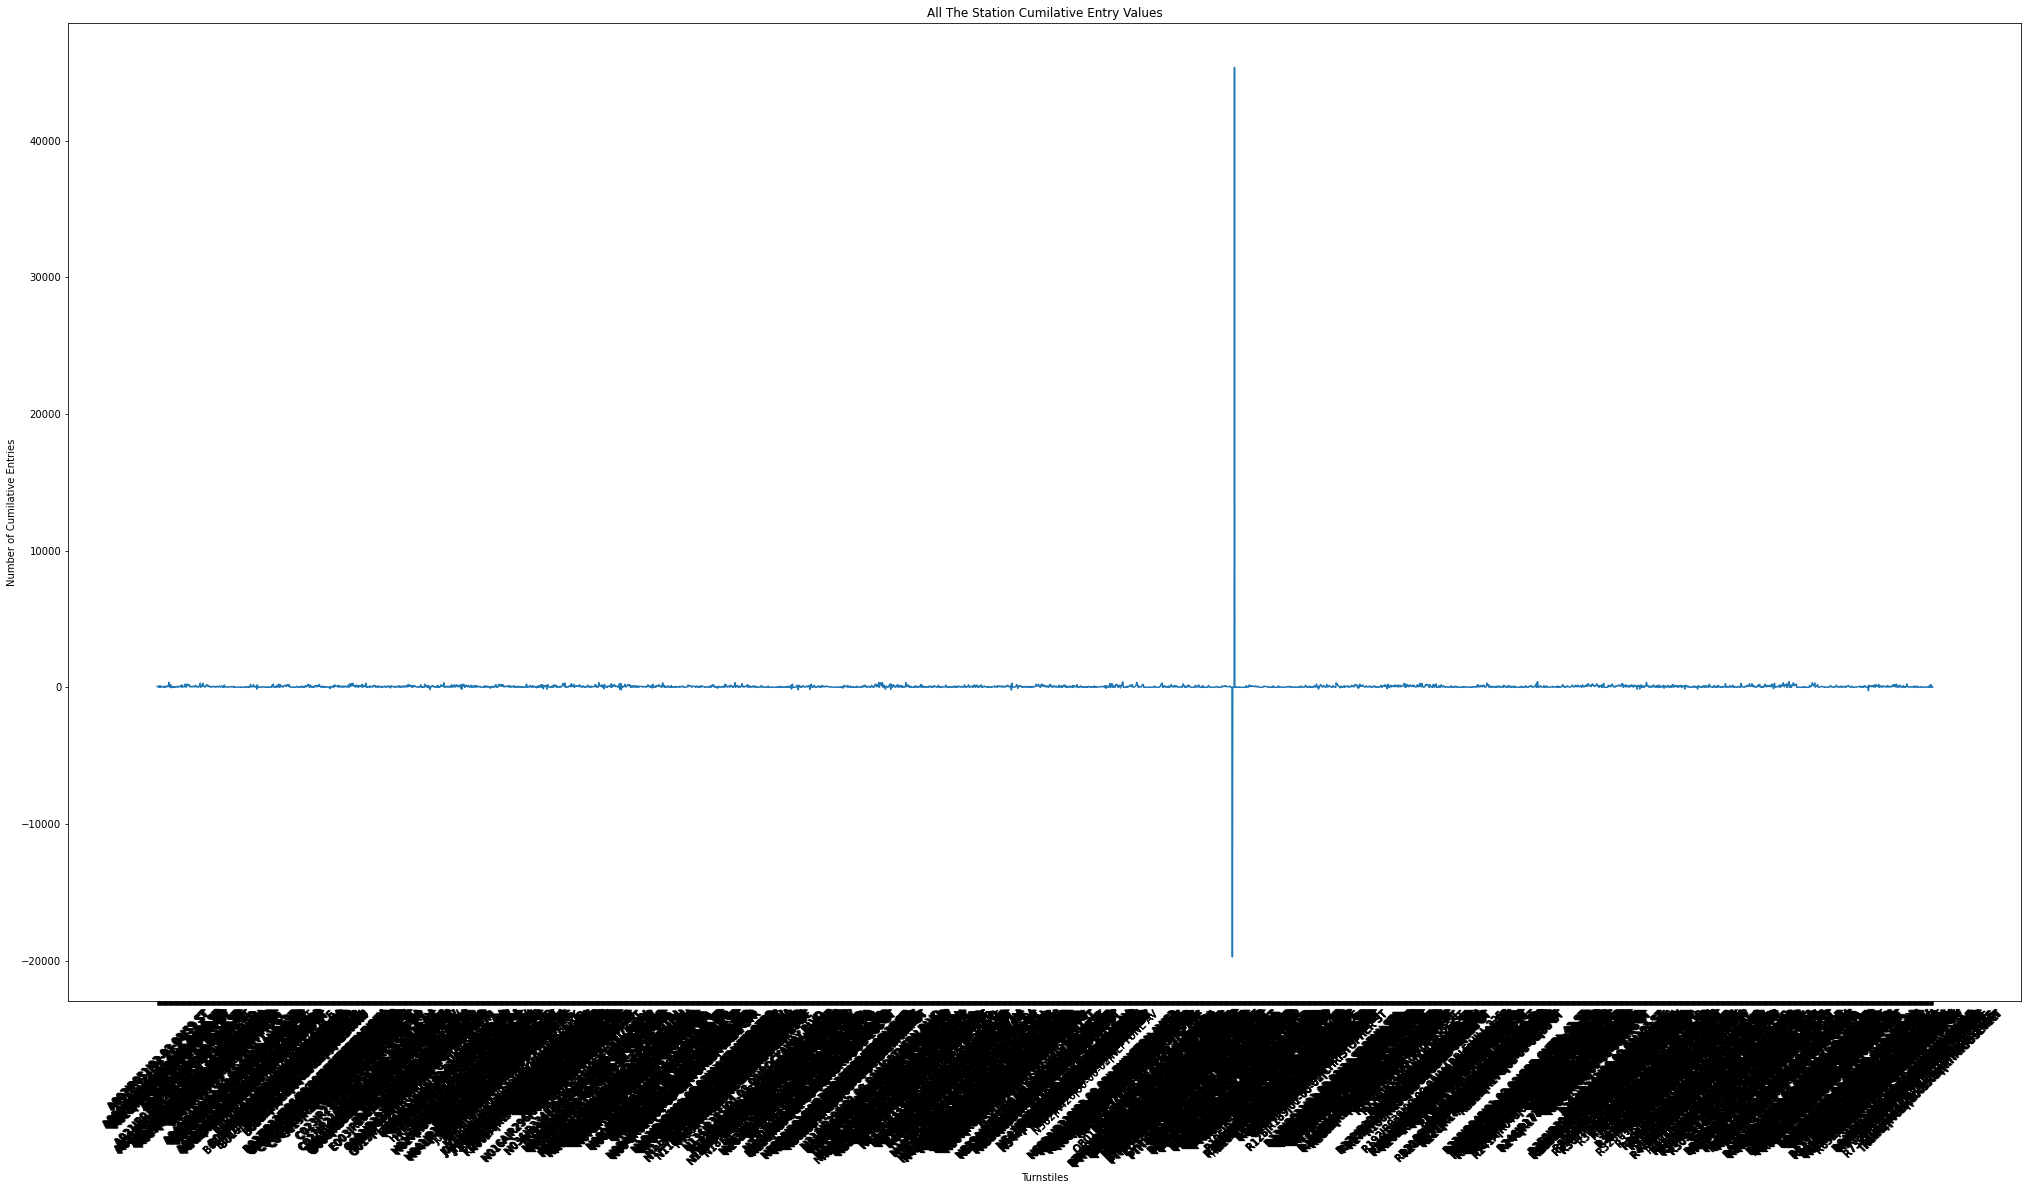

In [98]:
#By Turnstile
by_turnstile = mta_diffs.groupby('Turnstile')['Entries_Diff'].median().reset_index()

plt.figure(figsize = (35,18))
plt.plot(by_turnstile.Turnstile, by_turnstile.Entries_Diff)

plt.ylabel('Number of Cumilative Entries')
plt.xlabel('Turnstiles')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Values');

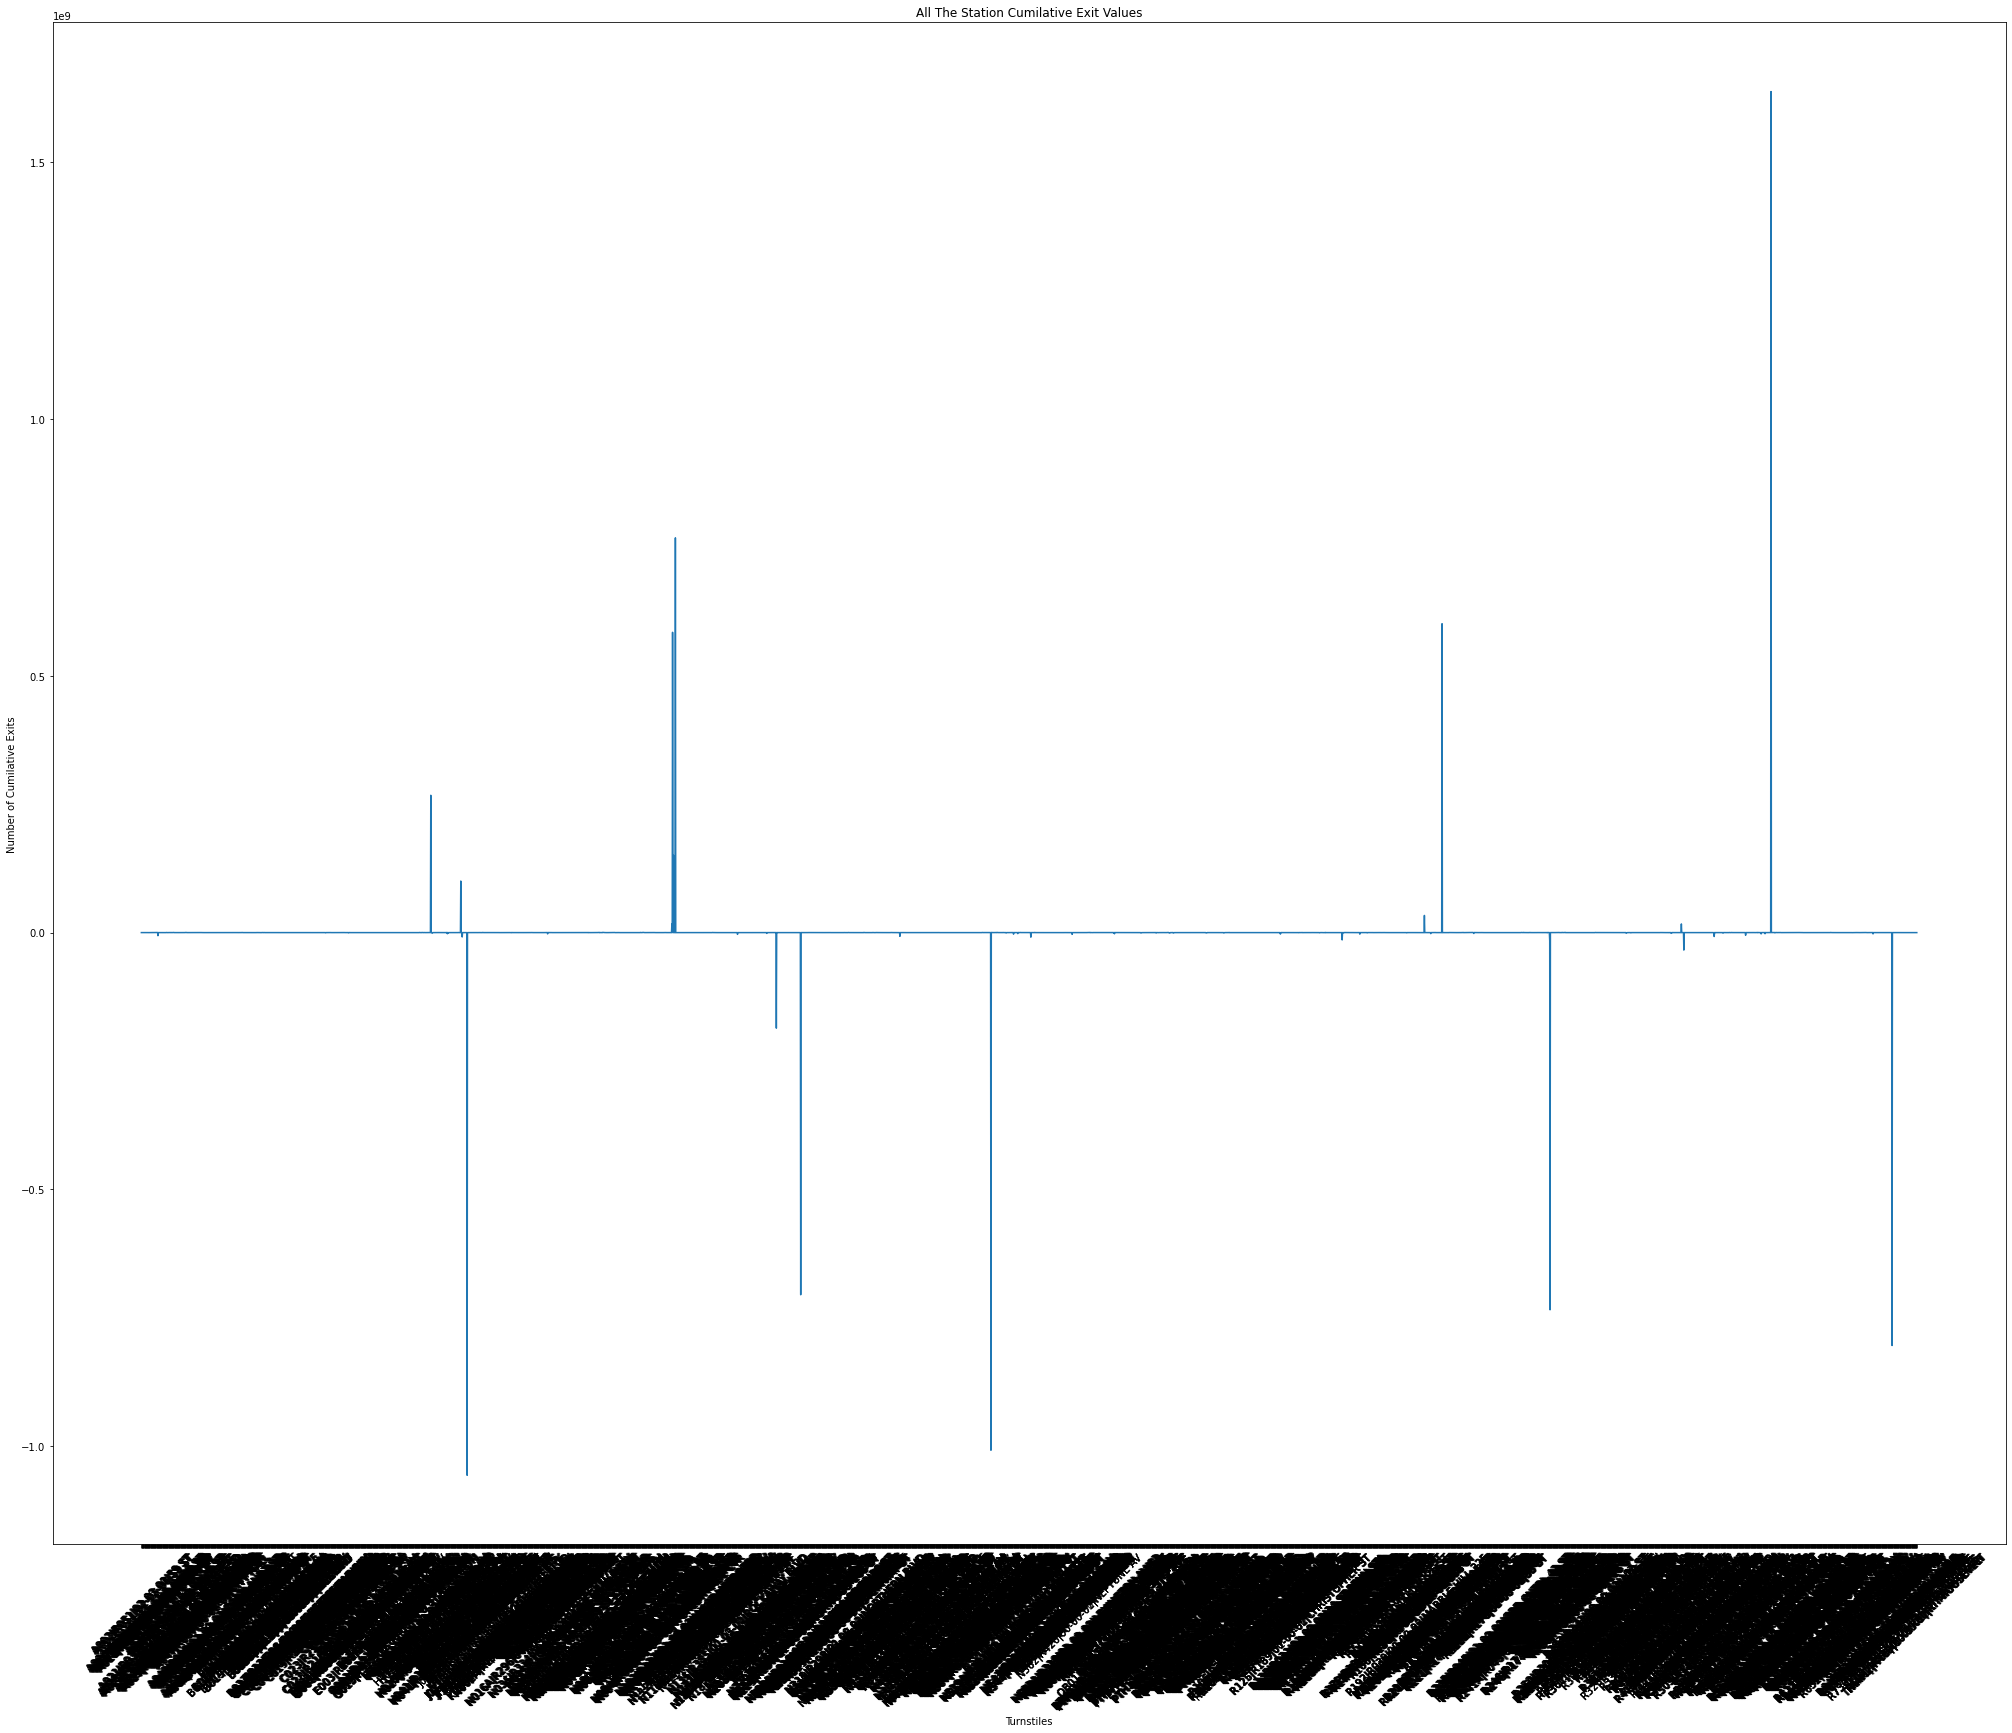

In [99]:
#By Turnstile
by_turnstile_exits = mta_diffs.groupby('Turnstile')['Exits_Diff'].sum().reset_index()

plt.figure(figsize = (35,28))
plt.plot(by_turnstile_exits.Turnstile, by_turnstile_exits.Exits_Diff)

plt.ylabel('Number of Cumilative Exits')
plt.xlabel('Turnstiles')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Exit Values');

## Key Findings From Above Visualization to be researched

1. Boxplot
    -- There are negative values and outliers
    
2. By Station Location and Date
    -- There are a few locations that don't seem right
    
3. By Date 
    -- There are days that contain outliers
    
4. By Turnstile 
    -- Look at specific turnstiles to understand the extreme peaks
    


## Now, Look into Negative & Zero Cumilative Difference Values

In [105]:
#Negative Entries Difference Calculations
mta_diffs[mta_diffs['Entries_Diff'] < 0].shape

(26412, 21)

In [106]:
#Zero Entries Difference Calculations
mta_diffs[mta_diffs['Entries_Diff'] == 0].shape

(476256, 21)

In [107]:
#Negative Exit Difference Calculations
mta_diffs[mta_diffs['Exits_Diff'] < 0].shape

(17216, 21)

In [108]:
#Zero Exits Difference Calculations
mta_diffs[mta_diffs['Exits_Diff'] == 0].shape

(425525, 21)

In [109]:
#Negative Entries  & Exits Difference Calculations
(mta_diffs[(mta_diffs['Entries_Diff'] < 0) 
           & (mta_diffs['Exits_Diff'] < 0) ].shape )

(10947, 21)

In [110]:
#Negative Entries Difference Calculations
(mta_diffs[(mta_diffs['Entries_Diff'] == 0) 
           & (mta_diffs['Exits_Diff'] == 0) ].shape)

(357935, 21)

In [112]:
mta_diffs[['Entries_Diff', 'Exits_Diff']].describe()

Entries_Diff    Exits_Diff
count  2.917968e+06  2.917968e+06
mean  -3.007980e+02 -4.024941e+01
std    2.303000e+06  2.854049e+06
min   -1.560008e+09 -2.133741e+09
25%    4.000000e+00  6.000000e+00
50%    2.800000e+01  3.300000e+01
75%    9.100000e+01  9.900000e+01
max    1.970611e+09  2.133741e+09

## Filter out the zero value records
- Due to no foot traffic during those times

In [113]:
noZeros = (mta_diffs[(mta_diffs['Entries_Diff'] != 0) 
                     & (mta_diffs['Exits_Diff'] != 0)  ])
print(noZeros.shape)
noZeros[['Entries_Diff', 'Exits_Diff']].describe()

(2374122, 21)


Entries_Diff    Exits_Diff
count  2.374122e+06  2.374122e+06
mean  -3.706008e+02 -5.133468e+01
std    2.553169e+06  3.164043e+06
min   -1.560008e+09 -2.133741e+09
25%    1.300000e+01  1.700000e+01
50%    4.500000e+01  4.900000e+01
75%    1.110000e+02  1.210000e+02
max    1.970611e+09  2.133741e+09

In [161]:
(noZeros[(noZeros['Entries_Diff'] == 0) 
                     & (noZeros['Exits_Diff'] == 0)  ])

Empty DataFrame
Columns: [index, C/A, Unit, Scp, Station, Linename, Division, Date, Time, Desc, Entries, Exits, Turnstile, Station_loc, DateNTime, Day, Day#, DayType, Hour, Entries_Diff, Exits_Diff]
Index: []

[0 rows x 21 columns]

## Convert negative values to positive then look into outliers

In [114]:
noZerosNoNegatives = noZeros.copy()

In [115]:
noZerosNoNegatives.shape

(2374122, 21)

In [116]:
def remove_neg(givenDF):
    if givenDF['Entries_Diff'] < 0:
        return givenDF['Entries_Diff'] * -1
    else:
        return givenDF['Entries_Diff']

noZerosNoNegatives['Entries_Diff'] = noZerosNoNegatives.apply(remove_neg,axis=1)
noZerosNoNegatives.sort_values('Entries_Diff').head()

index    C/A  Unit       Scp          Station Linename Division  \
586178    42864   J030  R005  00-00-02  85 ST-FOREST PK        J      BMT   
1837950  132039   R107  R305  00-00-02    WTC-CORTLANDT        1      IRT   
2081057  149520   R182  R035  00-03-01           168 ST      1AC      IRT   
820452    58944   N078  R175  01-03-03            14 ST     ACEL      IND   
1248062   89655  N334B  R341  00-03-00            75 AV       EF      IND   

               Date      Time     Desc  ...   Exits  \
586178   10/04/2021  04:00:00  REGULAR  ...  391993   
1837950  08/21/2021  09:00:00  REGULAR  ...   60631   
2081057  10/11/2021  04:00:00  REGULAR  ...  550152   
820452   08/19/2021  05:00:00  REGULAR  ...  745621   
1248062  08/05/2021  20:00:00  REGULAR  ...  160789   

                                  Turnstile        Station_loc  \
586178   J030|R005|00-00-02|85 ST-FOREST PK  85 ST-FOREST PK J   
1837950    R107|R305|00-00-02|WTC-CORTLANDT    WTC-CORTLANDT 1   
2081057           R182|R035|00-03-01|168 ST         168 ST 1AC   
820452             N078|R175|01-03-03|14 ST         14 ST ACEL   
1248062           N334B|R341|00-03-00|75 AV           75 AV EF   

                  DateNTime  Day Day#  DayType Hour  Entries_Diff  Exits_Diff  
586178  2021-10-04 04:00:00  Mon    0  WeekDay    4           1.0         6.0  
1837950 2021-08-21 09:00:00  Sat    5  WeekEnd    9           1.0         3.0  
2081057 2021-10-11 04:00:00  Mon    0  WeekDay    4           1.0        31.0  
820452  2021-08-19 05:00:00  Thu    3  WeekDay    5           1.0        16.0  
1248062 2021-08-05 20:00:00  Thu    3  WeekDay   20           1.0        15.0  

[5 rows x 21 columns]

In [118]:
def remove_neg(givenDF):
    if givenDF['Exits_Diff'] < 0:
        return givenDF['Exits_Diff'] * -1
    else:
        return givenDF['Exits_Diff']

noZerosNoNegatives['Exits_Diff'] = noZerosNoNegatives.apply(remove_neg,axis=1)
noZerosNoNegatives.sort_values('Exits_Diff').head()

index    C/A  Unit       Scp          Station Linename Division  \
1564714  112070   N601  R319  00-00-04  LEXINGTON AV/63        F      IND   
1008058   71900  N181A  R464  00-06-03  AQUEDUCT RACETR        A      IND   
1906919  136440   R127  R105  00-00-02            14 ST   123FLM      IRT   
1906913  136434   R127  R105  00-00-02            14 ST   123FLM      IRT   
1008070   71912  N181A  R464  00-06-03  AQUEDUCT RACETR        A      IND   

               Date      Time     Desc  ...     Exits  \
1564714  08/14/2021  04:00:00  REGULAR  ...    248931   
1008058  09/07/2021  08:00:00  REGULAR  ...  16948966   
1906919  09/08/2021  04:00:00  REGULAR  ...    695291   
1906913  09/07/2021  04:00:00  REGULAR  ...    695167   
1008070  09/09/2021  08:00:00  REGULAR  ...  16949041   

                                   Turnstile        Station_loc  \
1564714   N601|R319|00-00-04|LEXINGTON AV/63  LEXINGTON AV/63 F   
1008058  N181A|R464|00-06-03|AQUEDUCT RACETR  AQUEDUCT RACETR A   
1906919             R127|R105|00-00-02|14 ST       14 ST 123FLM   
1906913             R127|R105|00-00-02|14 ST       14 ST 123FLM   
1008070  N181A|R464|00-06-03|AQUEDUCT RACETR  AQUEDUCT RACETR A   

                  DateNTime  Day Day#  DayType Hour  Entries_Diff  Exits_Diff  
1564714 2021-08-14 04:00:00  Sat    5  WeekEnd    4           8.0         1.0  
1008058 2021-09-07 08:00:00  Tue    1  WeekDay    8          10.0         1.0  
1906919 2021-09-08 04:00:00  Wed    2  WeekDay    4           3.0         1.0  
1906913 2021-09-07 04:00:00  Tue    1  WeekDay    4           6.0         1.0  
1008070 2021-09-09 08:00:00  Thu    3  WeekDay    8          19.0         1.0  

[5 rows x 21 columns]

## Now, visualize the data after:
1. Removing duplicate records for the same Turnstile
2. Removing "AUD" records
3. Removed records with zero cumilative differences due to no traffic
4. Converted our negative cumilative calculations into positive


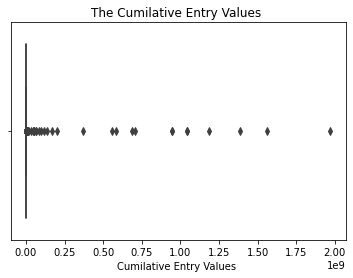

In [123]:
# Entry Cumilative values
(sns.boxplot(x=noZerosNoNegatives.Entries_Diff, data= mta_diffs)
 .set(xlabel = 'Cumilative Entry Values ', 
      title = "The Cumilative Entry Values ");)

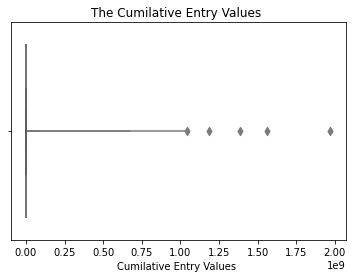

In [119]:
# Entry Cumilative values
(sns.boxenplot(x = 'Entries_Diff', data = noZerosNoNegatives, 
               palette = "pastel")
          .set(xlabel = 'Cumilative Entry Values ', 
           title = "The Cumilative Entry Values "));

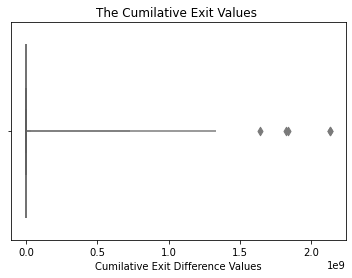

In [120]:
# Exit Cumilative values
(sns.boxenplot(x = 'Exits_Diff', data = noZerosNoNegatives, 
               palette = "pastel")
          .set(xlabel = 'Cumilative Exit Difference Values', 
           title = "The Cumilative Exit Values "));


## 1. Group by Station Location and Look at the median values

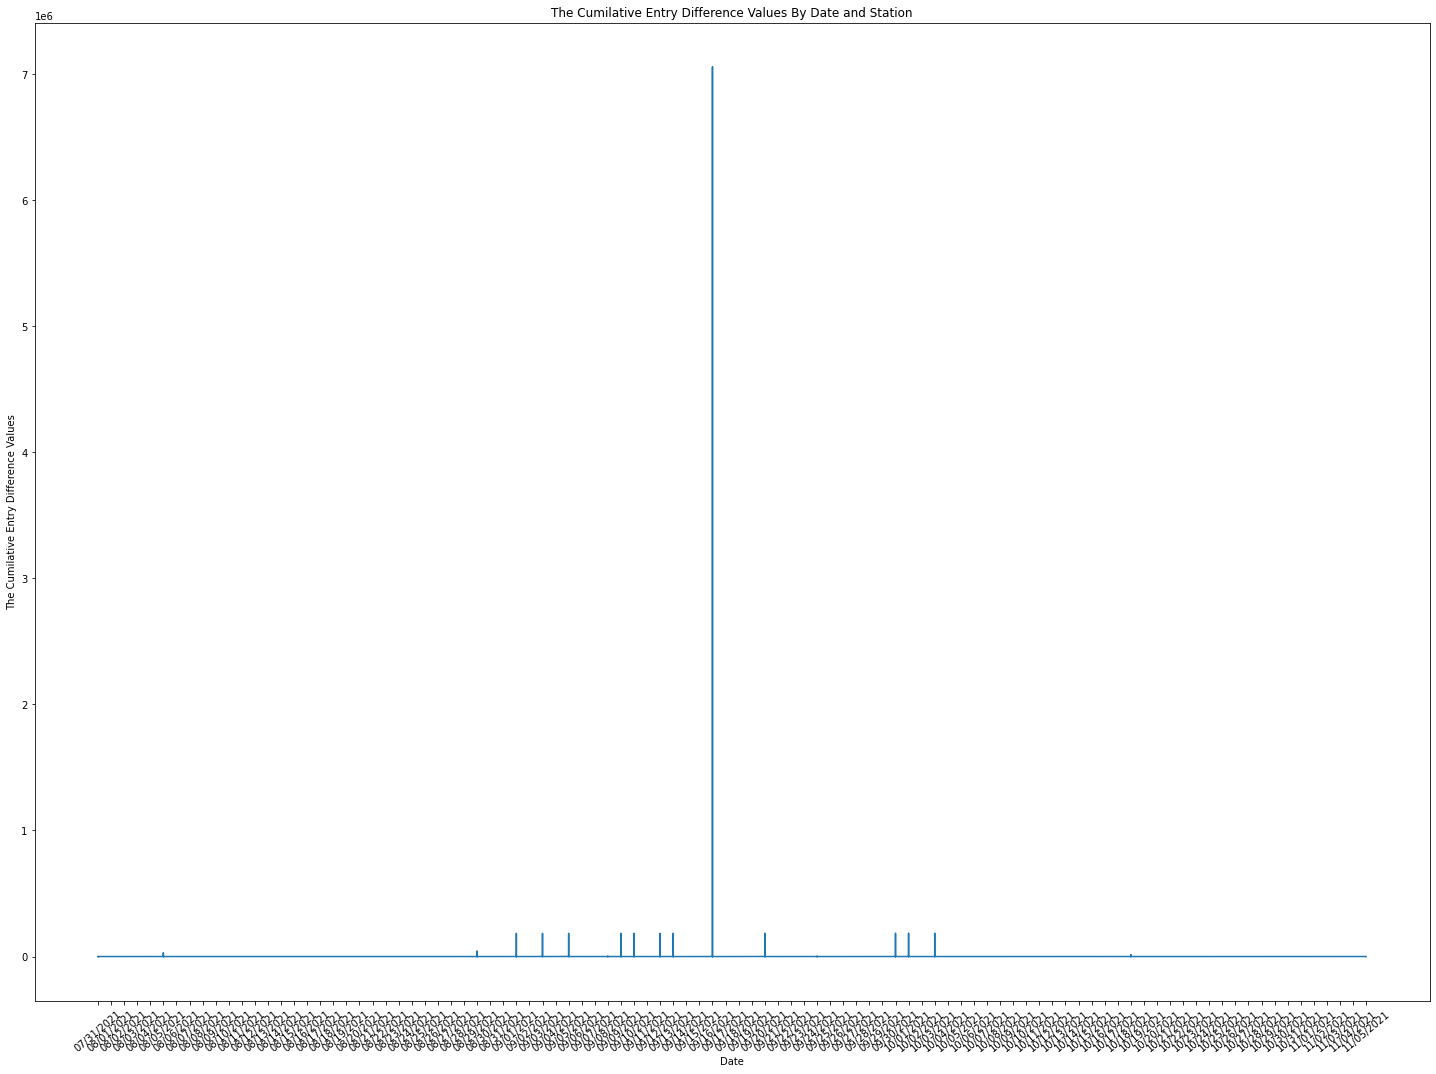

In [124]:
# Entries by Station Location and Date
station_entries = noZerosNoNegatives.groupby(["Date", "Station_loc"])['Entries_Diff'].median().reset_index()

plt.figure(figsize = (25,18))
plt.plot(station_entries.Date, station_entries.Entries_Diff)

plt.ylabel('The Cumilative Entry Difference Values')
plt.xlabel('Date')
plt.xticks(rotation=40)
plt.title('The Cumilative Entry Difference Values By Date and Station');

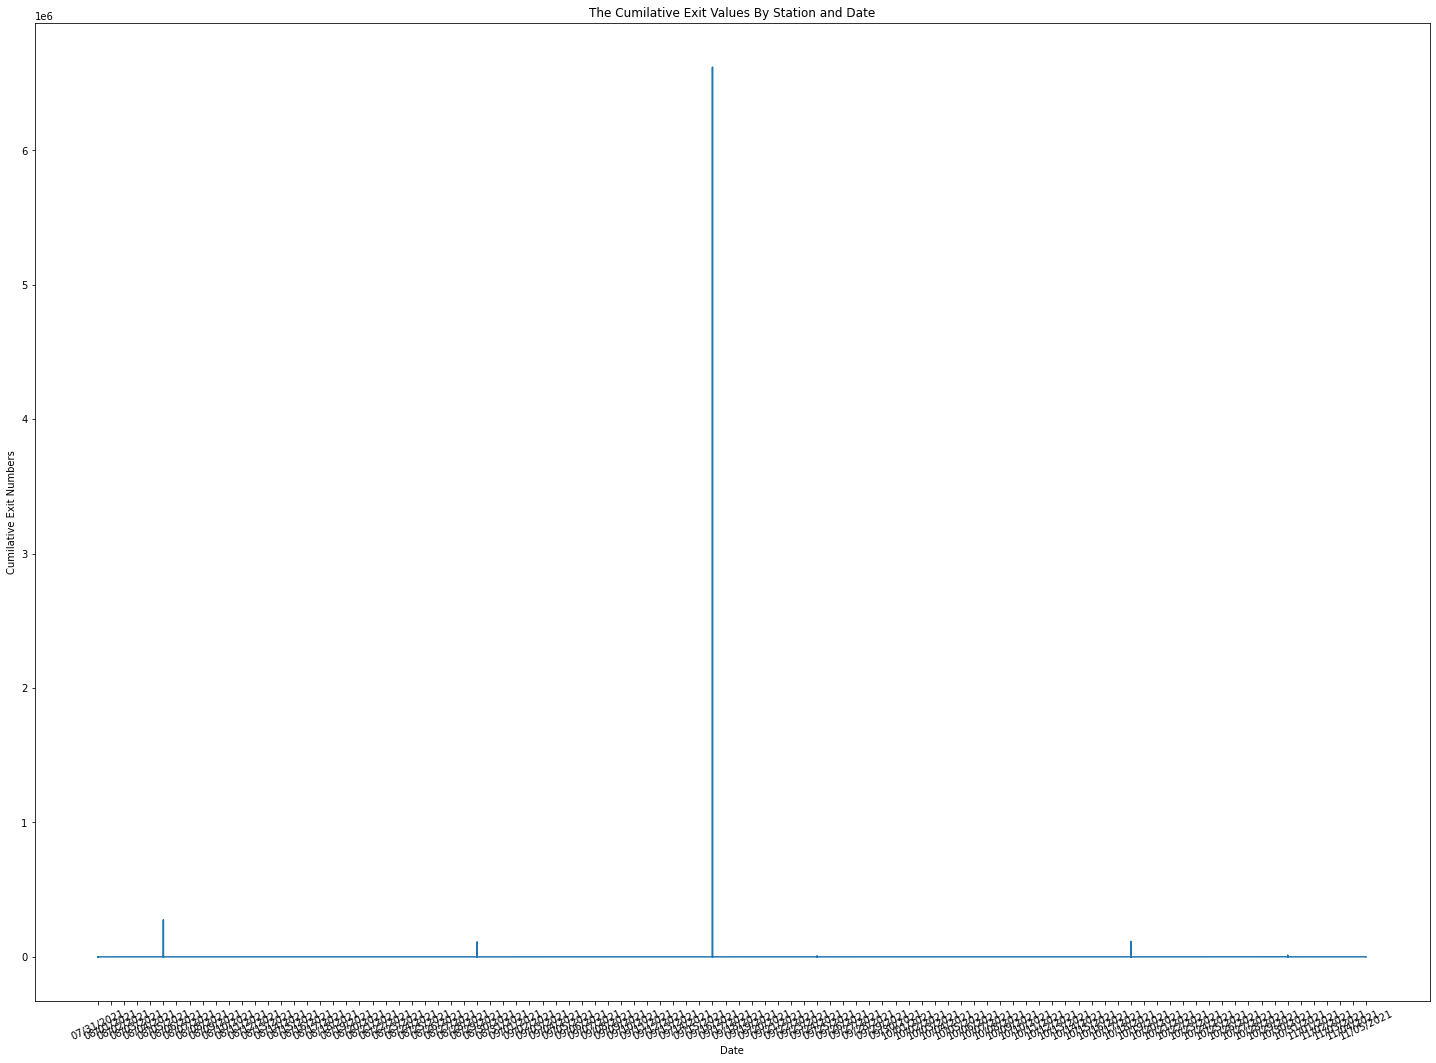

In [136]:
# Entries by Station Location and Date
station_exits = noZerosNoNegatives.groupby(["Date", "Station_loc"])['Exits_Diff'].median().reset_index()

plt.figure(figsize = (25,18))
plt.plot(station_exits.Date, station_exits.Exits_Diff)

plt.ylabel('Cumilative Exit Numbers')
plt.xlabel('Date')
plt.xticks(rotation=25)
plt.title('The Cumilative Exit Values By Station and Date');

## 2. By Date

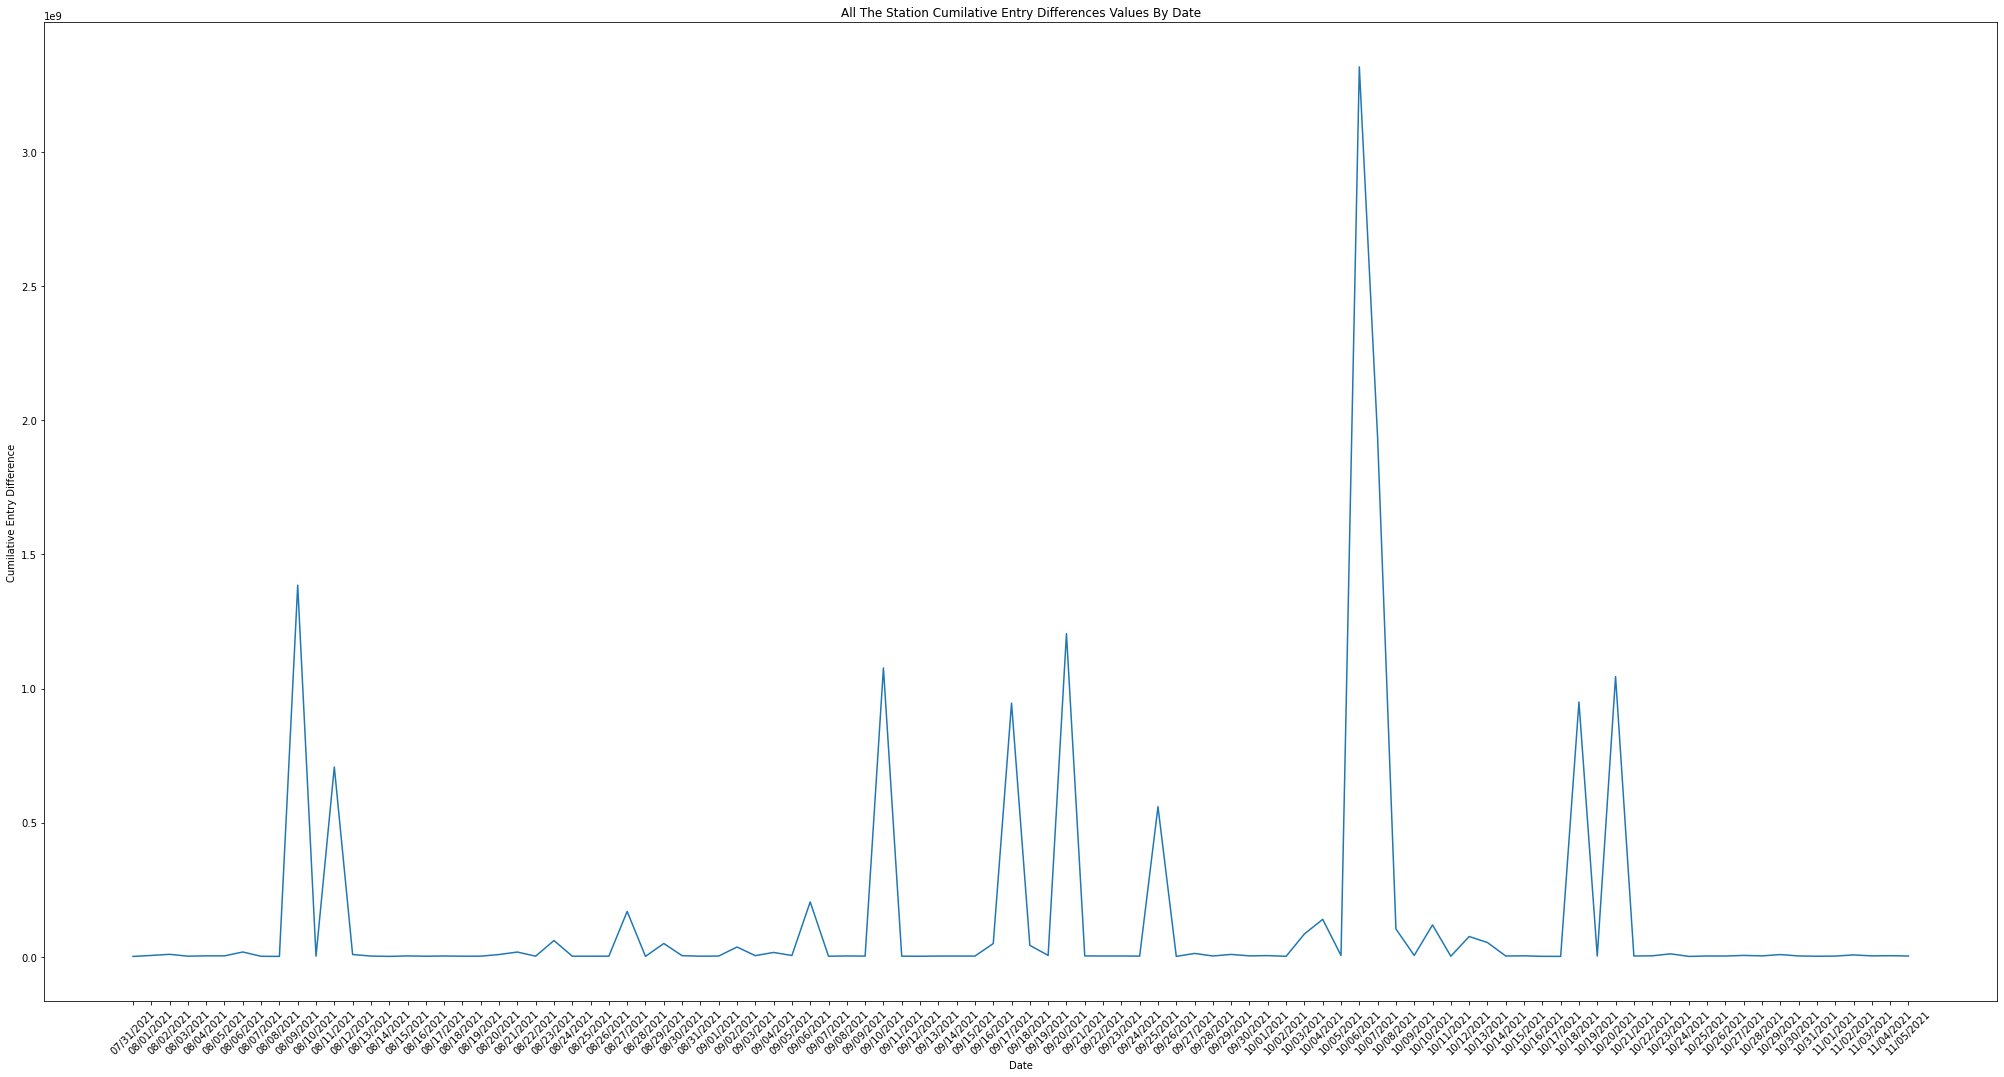

In [126]:
# Entries by Date
by_date = noZerosNoNegatives.groupby('Date')['Entries_Diff'].sum().reset_index()

plt.figure(figsize = (35,18))
plt.plot(by_date.Date, by_date.Entries_Diff)

plt.ylabel('Cumilative Entry Difference')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Differences Values By Date');

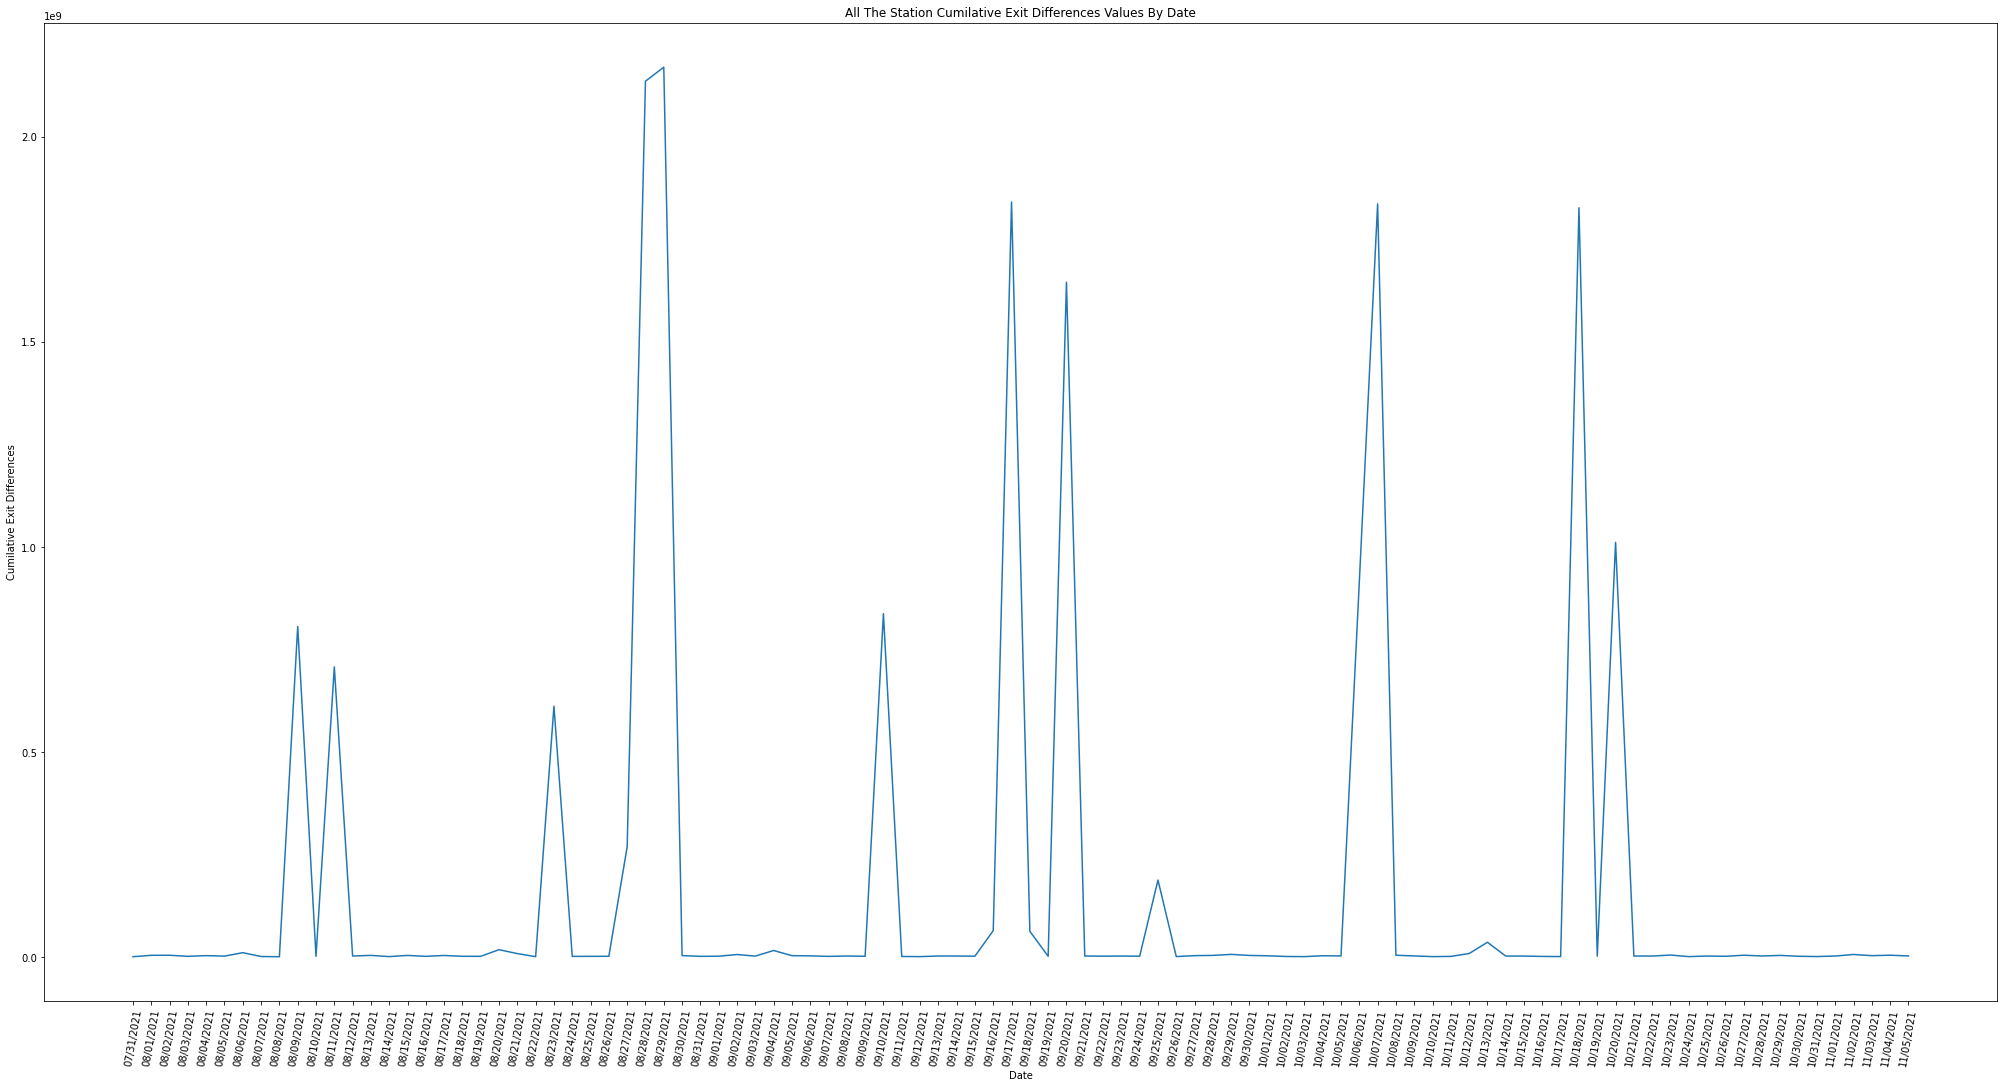

In [137]:
# Exits by median
date_exits = noZerosNoNegatives.groupby('Date')['Exits_Diff'].sum().reset_index()

plt.figure(figsize = (35,18))
plt.plot(date_exits.Date, date_exits.Exits_Diff)

plt.ylabel('Cumilative Exit Differences')
plt.xlabel('Date')
plt.xticks(rotation=80)
plt.title('All The Station Cumilative Exit Differences Values By Date');

## 3. Group by Day Name [Mon, Tue...]

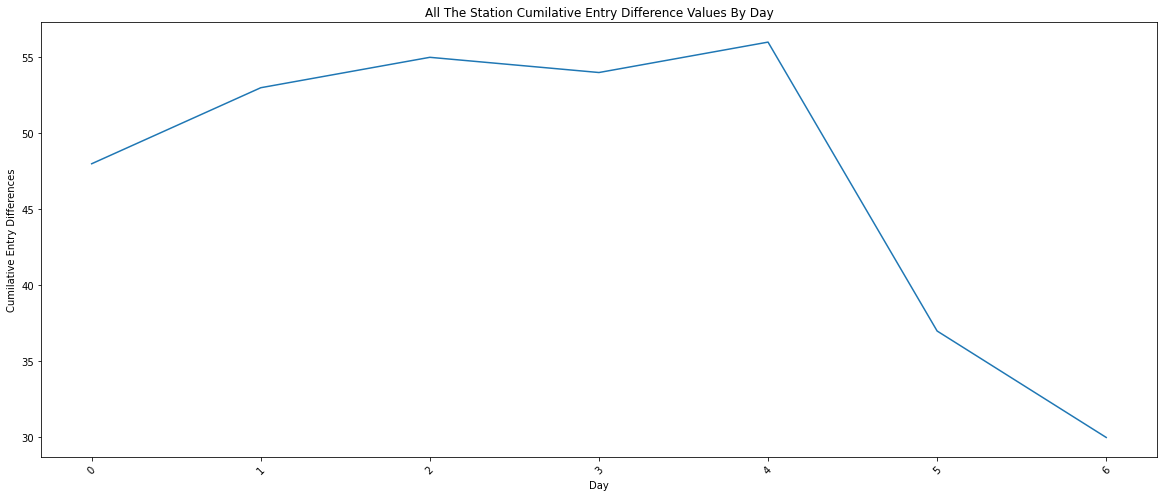

In [128]:
#By Day Name
day_name = noZerosNoNegatives.groupby('Day#')['Entries_Diff'].median().reset_index()

plt.figure(figsize = (20,8))
plt.plot(day_name['Day#'], day_name.Entries_Diff)

plt.ylabel('Cumilative Entry Differences')
plt.xlabel('Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Difference Values By Day');

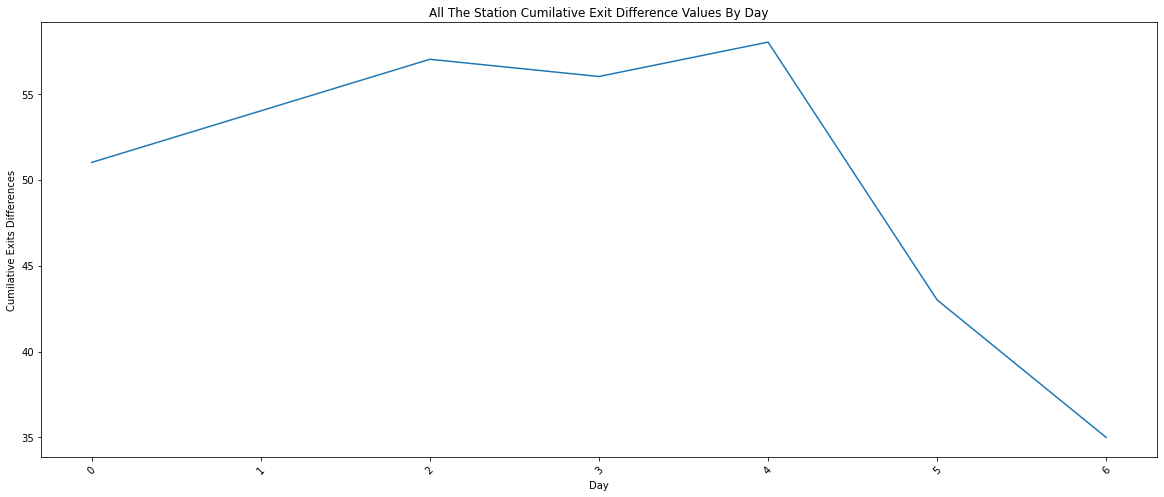

In [130]:
#By Day Name
day_nameExit = noZerosNoNegatives.groupby('Day#')['Exits_Diff'].median().reset_index()

plt.figure(figsize = (20,8))
plt.plot(day_nameExit['Day#'], day_nameExit.Exits_Diff)

plt.ylabel('Cumilative Exits Differences')
plt.xlabel('Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Exit Difference Values By Day');

## 5. Group by Hour of day

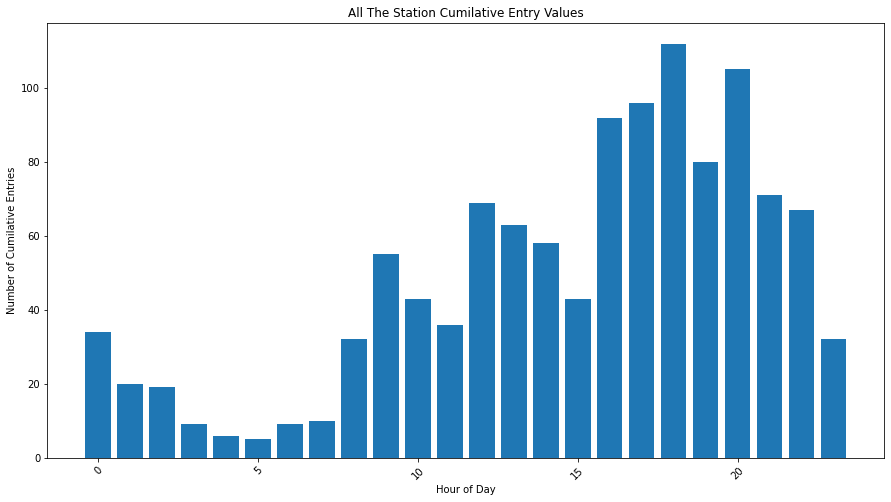

In [132]:
#By Hour of Day
hour_dayEntries = noZerosNoNegatives.groupby('Hour')['Entries_Diff'].median().reset_index()

plt.figure(figsize = (15,8))
plt.bar(hour_dayEntries.Hour, hour_dayEntries.Entries_Diff)

plt.ylabel('Number of Cumilative Entries')
plt.xlabel('Hour of Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Values');

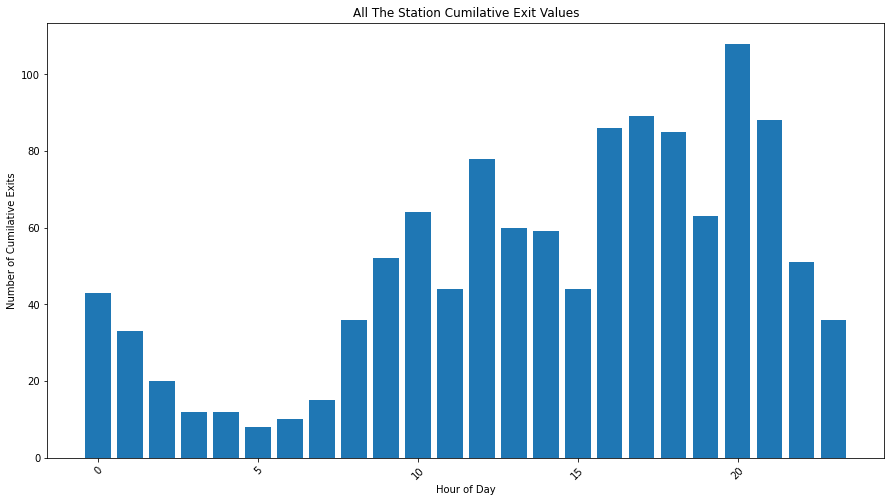

In [138]:
#By Hour of Day
hour_day = noZerosNoNegatives.groupby('Hour')['Exits_Diff'].median().reset_index()

plt.figure(figsize = (15,8))
plt.bar(hour_day.Hour, hour_day.Exits_Diff)

plt.ylabel('Number of Cumilative Exits')
plt.xlabel('Hour of Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Exit Values');

## 6. Finally, let's look at it grouped by Turnstile

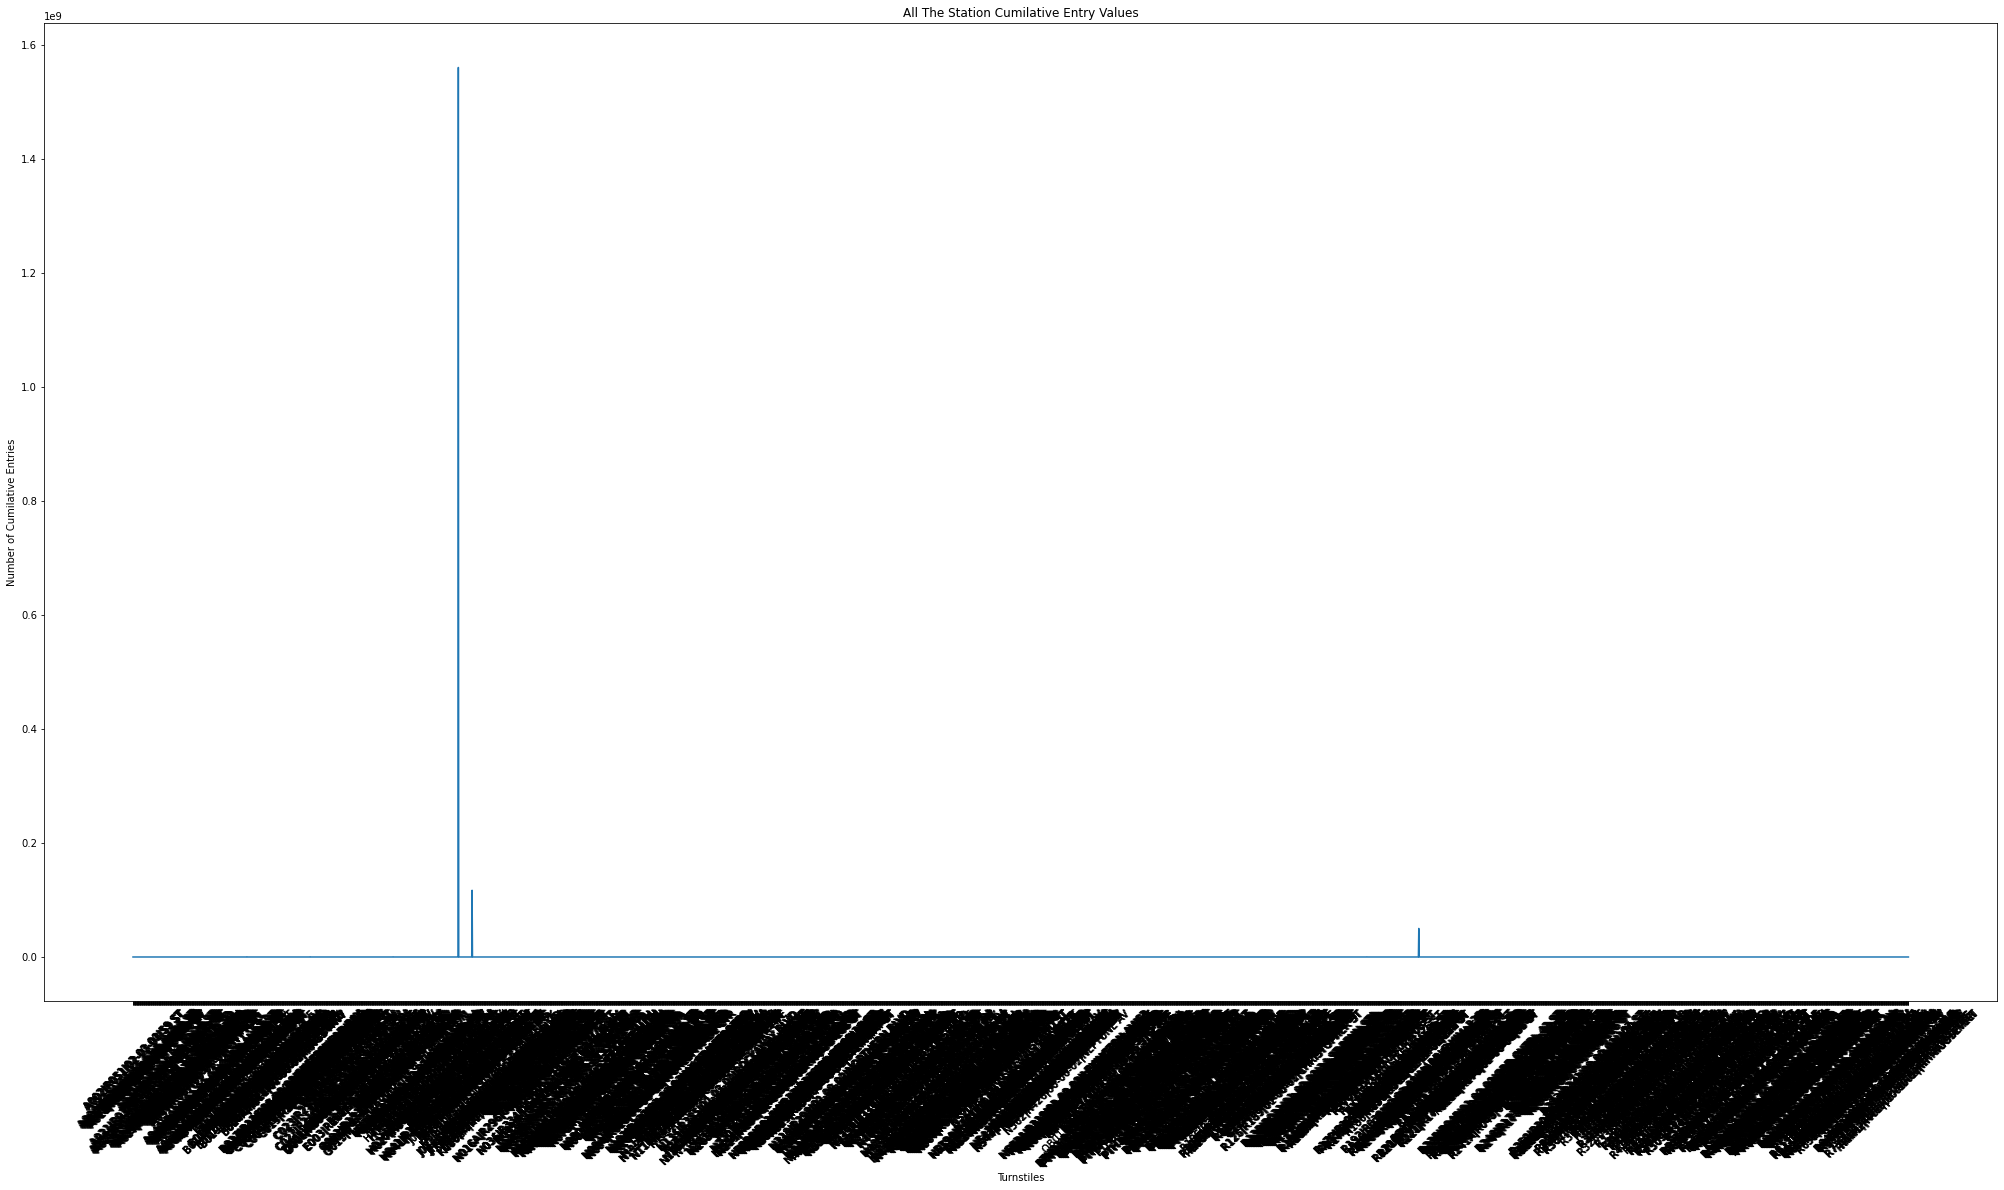

In [134]:
#By Turnstile
by_turnstile = noZerosNoNegatives.groupby('Turnstile')['Entries_Diff'].median().reset_index()

plt.figure(figsize = (35,18))
plt.plot(by_turnstile.Turnstile, by_turnstile.Entries_Diff)

plt.ylabel('Number of Cumilative Entries')
plt.xlabel('Turnstiles')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Values');

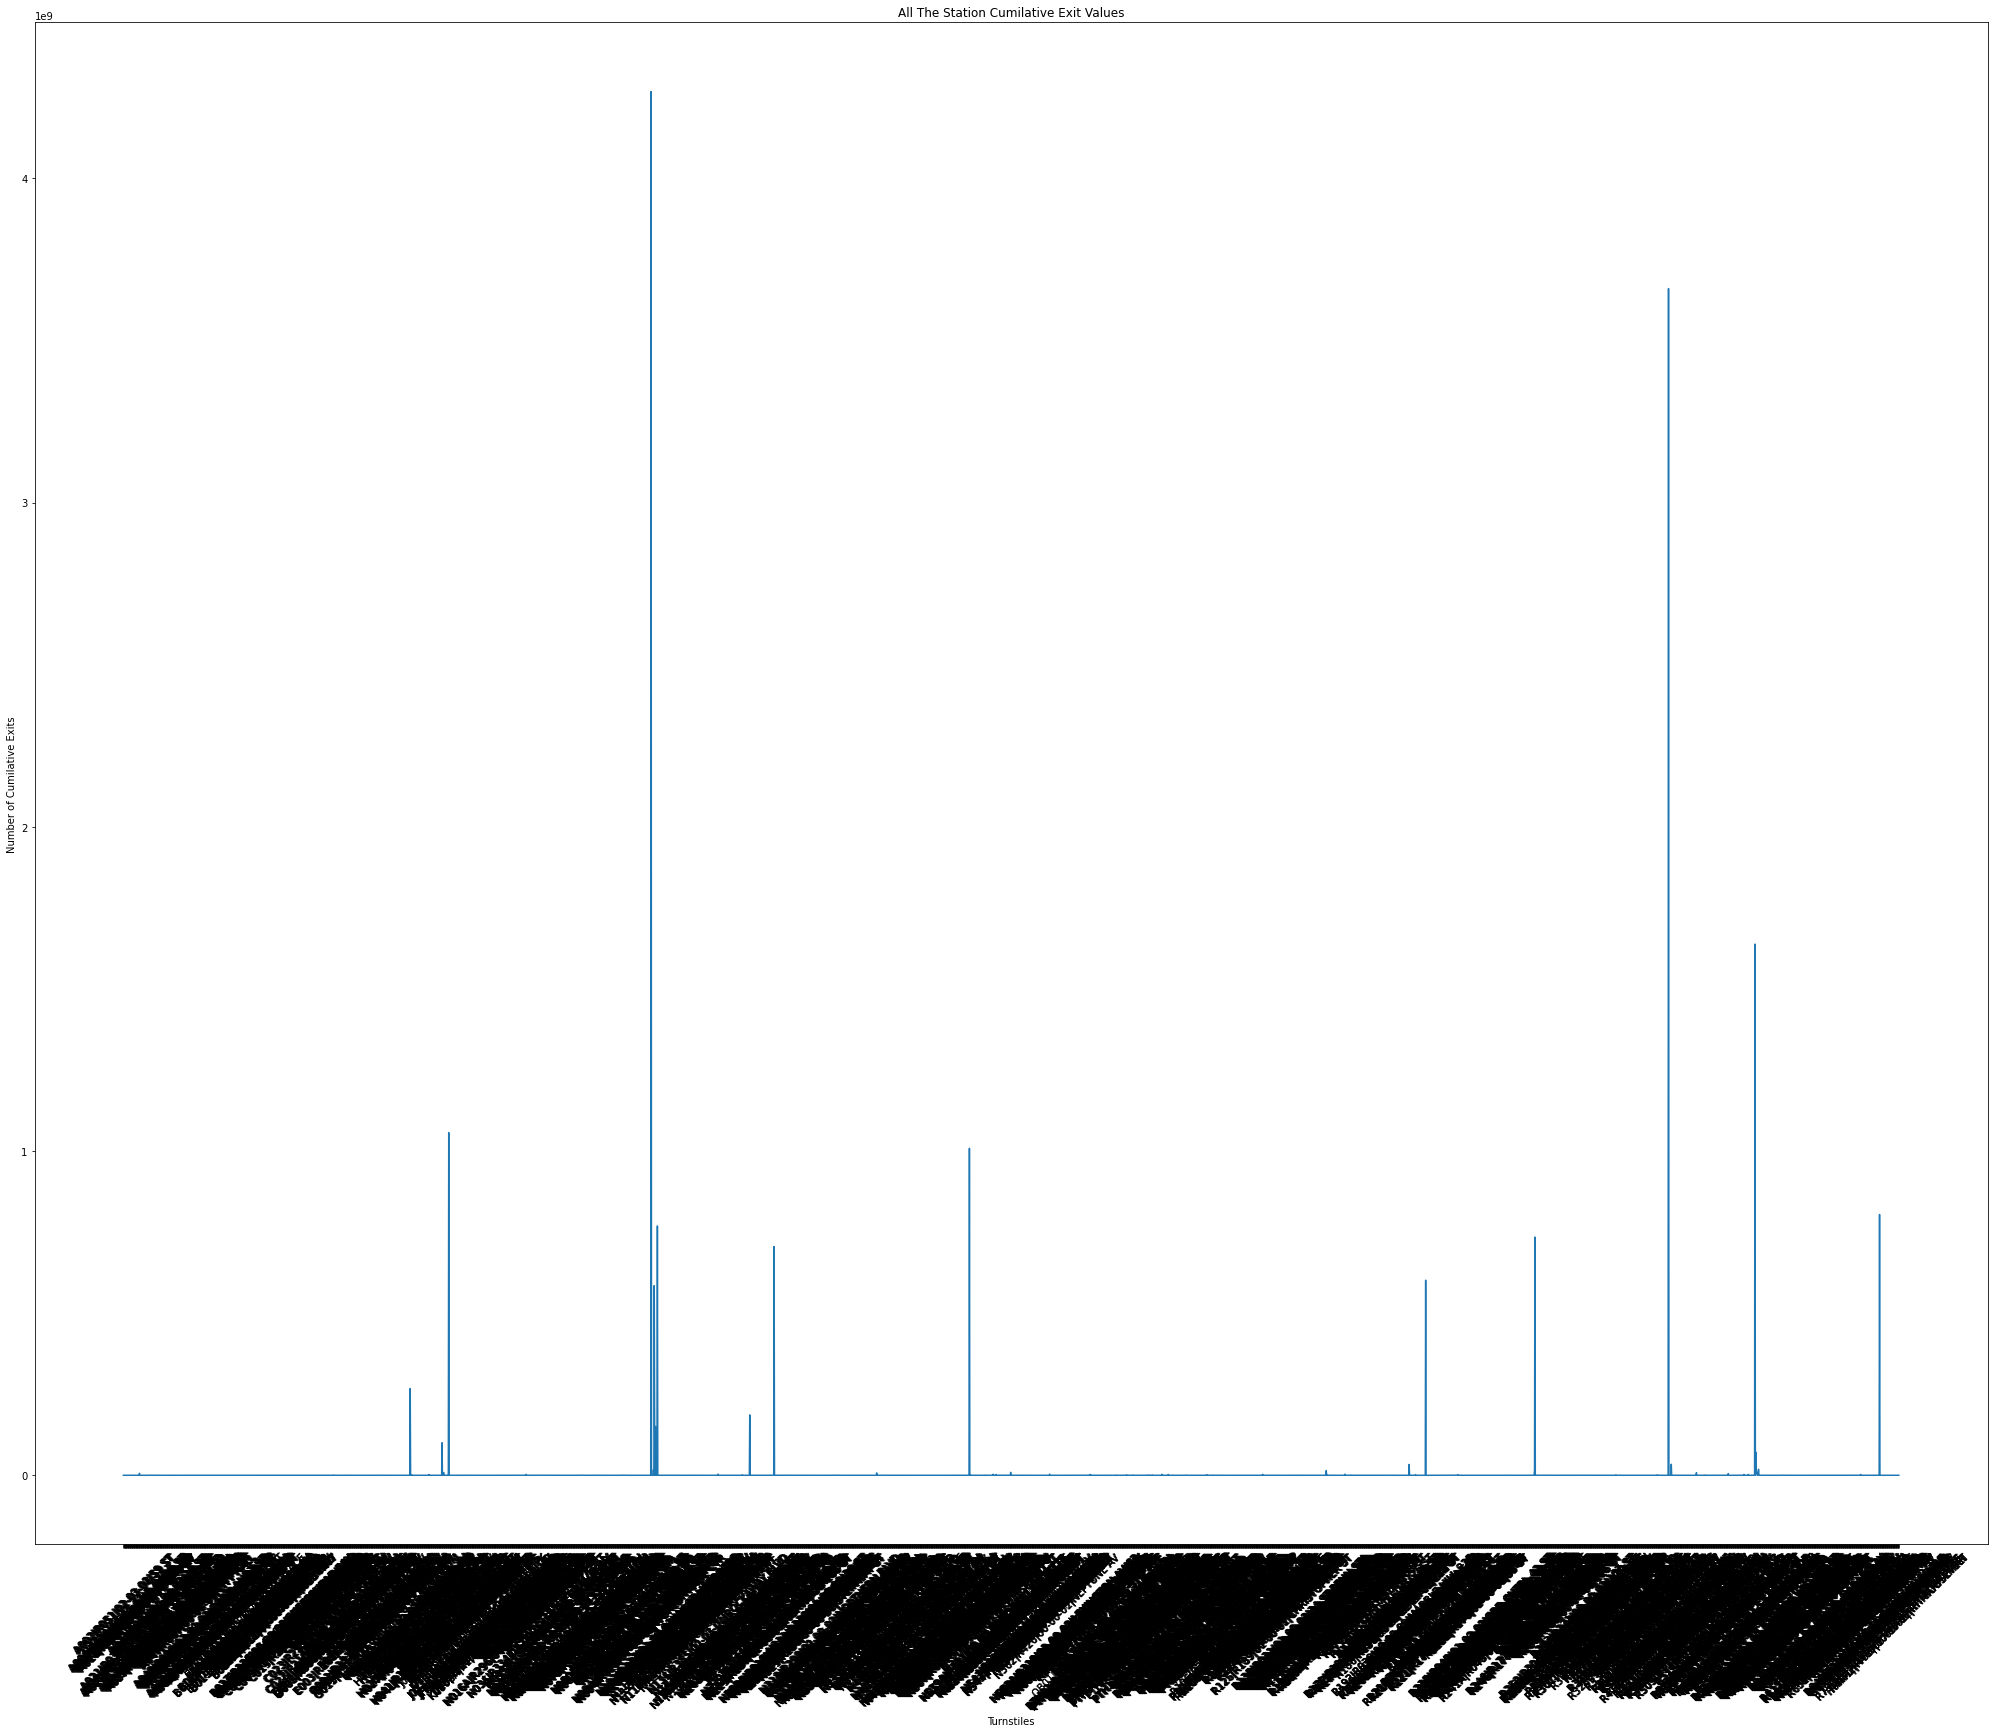

In [135]:
#By Turnstile
by_turnstile_exits = noZerosNoNegatives.groupby('Turnstile')['Exits_Diff'].sum().reset_index()

plt.figure(figsize = (35,28))
plt.plot(by_turnstile_exits.Turnstile, by_turnstile_exits.Exits_Diff)

plt.ylabel('Number of Cumilative Exits')
plt.xlabel('Turnstiles')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Exit Values');

## Key Findings From Above Visualization to be researched

1. Boxplot
    -- No more negative values, but easily see the outliers
    
2. By Station Location and Date
    -- Much easier picture to find where and when the outliers are
    
3. By Date 
    -- Use the dates to research what is causing the significant increase 
    
4. By Turnstile 
    -- Look at specific turnstiles to understand the extreme peaks
    


## Now, look into Outliers

In [144]:
noZerosNoNegatives['Entries_Diff'].quantile([.1,.25,.5,.75,.90,.95,.99])

0.10      4.0
0.25     13.0
0.50     46.0
0.75    113.0
0.90    212.0
0.95    291.0
0.99    480.0
Name: Entries_Diff, dtype: float64

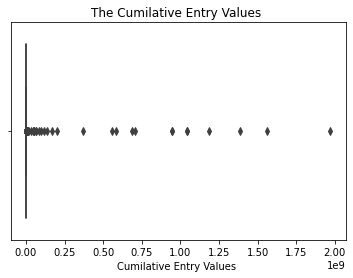

In [147]:
# Entry Cumilative values
(sns.boxplot(x=noZerosNoNegatives.Entries_Diff, data= mta_diffs)
 .set(xlabel = 'Cumilative Entry Values ', 
      title = "The Cumilative Entry Values "));

In [145]:
noZerosNoNegatives['Exits_Diff'].quantile([.1,.25,.5,.75,.90,.95,.99])

0.10      6.0
0.25     17.0
0.50     50.0
0.75    122.0
0.90    240.0
0.95    342.0
0.99    630.0
Name: Exits_Diff, dtype: float64

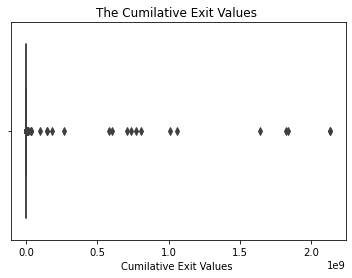

In [148]:
# Entry Cumilative values
(sns.boxplot(x=noZerosNoNegatives.Exits_Diff, data= mta_diffs)
 .set(xlabel = 'Cumilative Exit Values ', 
      title = "The Cumilative Exit Values "));

In [168]:
noZerosNoNegatives.columns

Index(['index', 'C/A', 'Unit', 'Scp', 'Station', 'Linename', 'Division',
       'Date', 'Time', 'Desc', 'Entries', 'Exits', 'Turnstile', 'Station_loc',
       'DateNTime', 'Day', 'Day#', 'DayType', 'Hour', 'Entries_Diff',
       'Exits_Diff'],
      dtype='object')

In [149]:
noZerosNoNegatives.shape

(2374122, 21)

In [186]:
#Over 1000
(noZerosNoNegatives[noZerosNoNegatives['Exits_Diff'] > 1000]
         [['Turnstile', 'Station_loc']].nunique() )


Turnstile      477
Station_loc    176
dtype: int64

In [185]:
#Over 5000
(noZerosNoNegatives[noZerosNoNegatives['Exits_Diff'] > 5000]
         [['Turnstile', 'Station_loc']].nunique() )


Turnstile      188
Station_loc     95
dtype: int64

In [184]:
#Over 10,000
(noZerosNoNegatives[(noZerosNoNegatives['Exits_Diff'] > 10000) ]
         [['Turnstile', 'Station_loc']].nunique() )

Turnstile      178
Station_loc     93
dtype: int64

In [183]:
#Over 100,000
(noZerosNoNegatives[(noZerosNoNegatives['Exits_Diff'] > 100000) ]
        [['Turnstile', 'Station_loc']].nunique() )

Turnstile      118
Station_loc     71
dtype: int64

In [182]:
#Over 1,000,000
( noZerosNoNegatives[(noZerosNoNegatives['Exits_Diff'] > 1000000) ]
        [['Turnstile', 'Station_loc']].nunique() )

Turnstile      56
Station_loc    41
dtype: int64

## Let's use 1,000 as the outlier and look into it

In [190]:
over_thousand = (noZerosNoNegatives[(noZerosNoNegatives['Entries_Diff'] > 1000) 
                                  | (noZerosNoNegatives['Exits_Diff'] > 1000)
                                  ])
print(over_thousand.shape)
over_thousand.sort_values('Entries_Diff', ascending=False).head()

(4641, 21)


index    C/A  Unit       Scp          Station  Linename Division  \
883581    63426  N095A  R014  01-00-02        FULTON ST  2345ACJZ      IND   
537389    38582   H041  R152  00-05-02  CANARSIE-ROCKAW         L      BMT   
2881852  206280   R646  R110  01-00-02  FLATBUSH AV-B.C        25      IRT   
2679861  192557   R527  R122  00-05-00   90 ST-ELMHURST         7      IRT   
1404733  101298   N505  R022  02-06-00  34 ST-HERALD SQ  BDFMNQRW      IND   

               Date      Time     Desc  ...       Exits  \
883581   10/06/2021  13:00:00  REGULAR  ...   587250626   
537389   10/07/2021  13:00:00  REGULAR  ...           6   
2881852  08/09/2021  17:00:00  REGULAR  ...          57   
2679861  09/20/2021  12:00:00  REGULAR  ...  1639186370   
1404733  10/20/2021  04:00:00  REGULAR  ...     1037726   

                                  Turnstile               Station_loc  \
883581        N095A|R014|01-00-02|FULTON ST        FULTON ST 2345ACJZ   
537389   H041|R152|00-05-02|CANARSIE-ROCKAW         CANARSIE-ROCKAW L   
2881852  R646|R110|01-00-02|FLATBUSH AV-B.C        FLATBUSH AV-B.C 25   
2679861   R527|R122|00-05-00|90 ST-ELMHURST          90 ST-ELMHURST 7   
1404733  N505|R022|02-06-00|34 ST-HERALD SQ  34 ST-HERALD SQ BDFMNQRW   

                  DateNTime  Day Day#  DayType Hour  Entries_Diff  \
883581  2021-10-06 13:00:00  Wed    2  WeekDay   13  1.970611e+09   
537389  2021-10-07 13:00:00  Thu    3  WeekDay   13  1.560008e+09   
2881852 2021-08-09 17:00:00  Mon    0  WeekDay   17  1.383110e+09   
2679861 2021-09-20 12:00:00  Mon    0  WeekDay   12  1.185279e+09   
1404733 2021-10-20 04:00:00  Wed    2  WeekDay    4  1.041776e+09   

           Exits_Diff  
883581   5.849078e+08  
537389   1.056989e+09  
2881852  8.042644e+08  
2679861  1.638145e+09  
1404733  1.008281e+09  

[5 rows x 21 columns]

In [192]:
over_Tenthousand = (noZerosNoNegatives[(noZerosNoNegatives['Entries_Diff'] > 10000) 
                                  | (noZerosNoNegatives['Exits_Diff'] > 10000)
                                  ])
print(over_Tenthousand.shape)
over_Tenthousand.sort_values('Exits_Diff', ascending=False).head()

(332, 21)


index   C/A  Unit       Scp          Station Linename Division  \
871048    62064  N094  R029  01-03-05  WORLD TRADE CTR    ACE23      IND   
871049    62065  N094  R029  01-03-05  WORLD TRADE CTR    ACE23      IND   
2532077  181796  R412  R146  00-00-00   HUNTS POINT AV        6      IRT   
2532262  182034  R412  R146  00-00-00   HUNTS POINT AV        6      IRT   
2679861  192557  R527  R122  00-05-00   90 ST-ELMHURST        7      IRT   

               Date      Time     Desc  ...       Exits  \
871048   08/28/2021  20:00:00  REGULAR  ...  2133796536   
871049   08/29/2021  00:00:00  REGULAR  ...       55627   
2532077  09/17/2021  17:00:00  REGULAR  ...  2013957922   
2532262  10/18/2021  13:00:00  REGULAR  ...   192461155   
2679861  09/20/2021  12:00:00  REGULAR  ...  1639186370   

                                  Turnstile            Station_loc  \
871048   N094|R029|01-03-05|WORLD TRADE CTR  WORLD TRADE CTR ACE23   
871049   N094|R029|01-03-05|WORLD TRADE CTR  WORLD TRADE CTR ACE23   
2532077   R412|R146|00-00-00|HUNTS POINT AV       HUNTS POINT AV 6   
2532262   R412|R146|00-00-00|HUNTS POINT AV       HUNTS POINT AV 6   
2679861   R527|R122|00-05-00|90 ST-ELMHURST       90 ST-ELMHURST 7   

                  DateNTime  Day Day#  DayType Hour  Entries_Diff  \
871048  2021-08-28 20:00:00  Sat    5  WeekEnd   20  2.100000e+01   
871049  2021-08-29 00:00:00  Sun    6  WeekEnd    0  4.000000e+00   
2532077 2021-09-17 17:00:00  Fri    4  WeekDay   17  9.432156e+08   
2532262 2021-10-18 13:00:00  Mon    0  WeekDay   13  9.431966e+08   
2679861 2021-09-20 12:00:00  Mon    0  WeekDay   12  1.185279e+09   

           Exits_Diff  
871048   2.133741e+09  
871049   2.133741e+09  
2532077  1.838321e+09  
2532262  1.821533e+09  
2679861  1.638145e+09  

[5 rows x 21 columns]

In [196]:
wrld_ctr = over_Tenthousand[over_Tenthousand.Station == 'WORLD TRADE CTR']
print(wrld_ctr.shape)
wrld_ctr.sort_values('DateNTime')

(6, 21)


index   C/A  Unit       Scp          Station Linename Division  \
867476  62518  N094  R029  01-00-04  WORLD TRADE CTR    ACE23      IND   
867477  62519  N094  R029  01-00-04  WORLD TRADE CTR    ACE23      IND   
871048  62064  N094  R029  01-03-05  WORLD TRADE CTR    ACE23      IND   
871049  62065  N094  R029  01-03-05  WORLD TRADE CTR    ACE23      IND   
868134  61880  N094  R029  01-03-00  WORLD TRADE CTR    ACE23      IND   
868135  61881  N094  R029  01-03-00  WORLD TRADE CTR    ACE23      IND   

              Date      Time     Desc  ...       Exits  \
867476  08/21/2021  16:00:00  REGULAR  ...      520633   
867477  08/21/2021  20:00:00  REGULAR  ...      520711   
871048  08/28/2021  20:00:00  REGULAR  ...  2133796536   
871049  08/29/2021  00:00:00  REGULAR  ...       55627   
868134  09/02/2021  04:00:00  REGULAR  ...      853267   
868135  09/02/2021  08:00:00  REGULAR  ...      853268   

                                 Turnstile            Station_loc  \
867476  N094|R029|01-00-04|WORLD TRADE CTR  WORLD TRADE CTR ACE23   
867477  N094|R029|01-00-04|WORLD TRADE CTR  WORLD TRADE CTR ACE23   
871048  N094|R029|01-03-05|WORLD TRADE CTR  WORLD TRADE CTR ACE23   
871049  N094|R029|01-03-05|WORLD TRADE CTR  WORLD TRADE CTR ACE23   
868134  N094|R029|01-03-00|WORLD TRADE CTR  WORLD TRADE CTR ACE23   
868135  N094|R029|01-03-00|WORLD TRADE CTR  WORLD TRADE CTR ACE23   

                 DateNTime  Day Day#  DayType Hour  Entries_Diff    Exits_Diff  
867476 2021-08-21 16:00:00  Sat    5  WeekEnd   16       16498.0  9.700000e+01  
867477 2021-08-21 20:00:00  Sat    5  WeekEnd   20       16242.0  7.800000e+01  
871048 2021-08-28 20:00:00  Sat    5  WeekEnd   20          21.0  2.133741e+09  
871049 2021-08-29 00:00:00  Sun    6  WeekEnd    0           4.0  2.133741e+09  
868134 2021-09-02 04:00:00  Thu    3  WeekDay    4    13631491.0  5.000000e+00  
868135 2021-09-02 08:00:00  Thu    3  WeekDay    8    13631486.0  1.000000e+00  

[6 rows x 21 columns]

In [201]:
aug_wr2829 = (mta_import[(mta_import['Turnstile'] == 'N094|R029|01-03-05|WORLD TRADE CTR' )
                       & (mta_import['Date'] == '08/28/2021' )
                       
                        ])
print(aug_wr2829.shape)
aug_wr2829.sort_values('DateNTime')

(6, 18)


C/A  Unit       Scp          Station Linename Division        Date  \
62059  N094  R029  01-03-05  WORLD TRADE CTR    ACE23      IND  08/28/2021   
62060  N094  R029  01-03-05  WORLD TRADE CTR    ACE23      IND  08/28/2021   
62061  N094  R029  01-03-05  WORLD TRADE CTR    ACE23      IND  08/28/2021   
62062  N094  R029  01-03-05  WORLD TRADE CTR    ACE23      IND  08/28/2021   
62063  N094  R029  01-03-05  WORLD TRADE CTR    ACE23      IND  08/28/2021   
62064  N094  R029  01-03-05  WORLD TRADE CTR    ACE23      IND  08/28/2021   

           Time     Desc  Entries       Exits  \
62059  00:00:00  REGULAR   247229       55609   
62060  04:00:00  REGULAR   247229       55609   
62061  08:00:00  REGULAR   247229       55609   
62062  12:00:00  REGULAR   247229       55610   
62063  16:00:00  REGULAR   247229       55614   
62064  20:00:00  REGULAR   247250  2133796536   

                                Turnstile            Station_loc  \
62059  N094|R029|01-03-05|WORLD TRADE CTR  WORLD TRADE CTR ACE23   
62060  N094|R029|01-03-05|WORLD TRADE CTR  WORLD TRADE CTR ACE23   
62061  N094|R029|01-03-05|WORLD TRADE CTR  WORLD TRADE CTR ACE23   
62062  N094|R029|01-03-05|WORLD TRADE CTR  WORLD TRADE CTR ACE23   
62063  N094|R029|01-03-05|WORLD TRADE CTR  WORLD TRADE CTR ACE23   
62064  N094|R029|01-03-05|WORLD TRADE CTR  WORLD TRADE CTR ACE23   

                DateNTime  Day  Day#  DayType  Hour  
62059 2021-08-28 00:00:00  Sat     5  WeekEnd     0  
62060 2021-08-28 04:00:00  Sat     5  WeekEnd     4  
62061 2021-08-28 08:00:00  Sat     5  WeekEnd     8  
62062 2021-08-28 12:00:00  Sat     5  WeekEnd    12  
62063 2021-08-28 16:00:00  Sat     5  WeekEnd    16  
62064 2021-08-28 20:00:00  Sat     5  WeekEnd    20

As you can see above on Turnstile "N094|R029|01-03-05|WORLD TRADE CTR",
The counter goes from 55,614 to 2,133,796,536. This is not normal for this Turnstile.

After looking at similar issues in both the Entries and Exits Columns for other turnstiles, we have decided to replace these values by the median.

The cutoff will be 10,000 because there are only 332 records

If we use 1,000, we will be dropping 4,641 records


## Replace Outliers by the Median

In [202]:
entries_median = noZerosNoNegatives.Entries_Diff.median()
entries_median

46.0

In [203]:
def outliers(givenDf, threshold):
    if givenDf['Entries_Diff'] > threshold:
        
        val = entries_median
        if val > threshold:
            return 0
        else:
            return val
    else:
        return givenDf['Entries_Diff']

noZerosNoNegatives['Entries_Diff'] = noZerosNoNegatives.apply( outliers, threshold = 10000, axis = 1)
noZerosNoNegatives.sort_values('Entries_Diff', ascending=False).head()


index    C/A  Unit       Scp          Station Linename Division  \
1732165  123594  PTH13  R541  00-04-04        THIRTY ST        1      PTH   
1744286  124754  PTH16  R550  01-01-08       LACKAWANNA        1      PTH   
2683312  192786   R528  R097  00-00-04    JUNCTION BLVD        7      IRT   
1797487  128486  PTH22  R540  00-01-05     PATH NEW WTC        1      PTH   
1751814  125828  PTH17  R541  01-00-07  THIRTY THIRD ST        1      PTH   

               Date      Time     Desc  ...    Exits  \
1732165  11/03/2021  19:49:35  REGULAR  ...       12   
1744286  09/07/2021  08:54:05  REGULAR  ...        0   
2683312  09/18/2021  00:00:00  REGULAR  ...  1715915   
1797487  09/02/2021  15:00:42  REGULAR  ...       39   
1751814  10/25/2021  08:17:28  REGULAR  ...        0   

                                   Turnstile        Station_loc  \
1732165        PTH13|R541|00-04-04|THIRTY ST        THIRTY ST 1   
1744286       PTH16|R550|01-01-08|LACKAWANNA       LACKAWANNA 1   
2683312     R528|R097|00-00-04|JUNCTION BLVD    JUNCTION BLVD 7   
1797487     PTH22|R540|00-01-05|PATH NEW WTC     PATH NEW WTC 1   
1751814  PTH17|R541|01-00-07|THIRTY THIRD ST  THIRTY THIRD ST 1   

                  DateNTime  Day Day#  DayType Hour  Entries_Diff  Exits_Diff  
1732165 2021-11-03 19:49:35  Wed    2  WeekDay   19        9859.0      1796.0  
1744286 2021-09-07 08:54:05  Tue    1  WeekDay    8        9397.0      3544.0  
2683312 2021-09-18 00:00:00  Sat    5  WeekEnd    0        9014.0      3721.0  
1797487 2021-09-02 15:00:42  Thu    3  WeekDay   15        8962.0      9436.0  
1751814 2021-10-25 08:17:28  Mon    0  WeekDay    8        8713.0      8811.0  

[5 rows x 21 columns]

In [205]:
exits_median = noZerosNoNegatives.Exits_Diff.median()
exits_median

50.0

In [206]:
def outliers(givenDf, threshold):
    if givenDf['Exits_Diff'] > threshold:
        
        val = exits_median
        if val > threshold:
            return 0
        else:
            return val
    else:
        return givenDf['Exits_Diff']

noZerosNoNegatives['Exits_Diff'] = noZerosNoNegatives.apply( outliers, threshold = 10000, axis = 1)
noZerosNoNegatives.sort_values('Exits_Diff', ascending=False).head()


index    C/A  Unit       Scp          Station Linename Division  \
1570821  113045  N601A  R319  01-03-01  LEXINGTON AV/63        F      IND   
1797487  128486  PTH22  R540  00-01-05     PATH NEW WTC        1      PTH   
1751814  125828  PTH17  R541  01-00-07  THIRTY THIRD ST        1      PTH   
1726211  123764  PTH13  R541  00-00-02        THIRTY ST        1      PTH   
1752935  125915  PTH17  R541  01-00-09  THIRTY THIRD ST        1      PTH   

               Date      Time     Desc  ...    Exits  \
1570821  10/14/2021  12:00:00  REGULAR  ...  1343294   
1797487  09/02/2021  15:00:42  REGULAR  ...       39   
1751814  10/25/2021  08:17:28  REGULAR  ...        0   
1726211  08/17/2021  10:36:56  REGULAR  ...        2   
1752935  10/28/2021  15:39:07  REGULAR  ...    32510   

                                   Turnstile        Station_loc  \
1570821  N601A|R319|01-03-01|LEXINGTON AV/63  LEXINGTON AV/63 F   
1797487     PTH22|R540|00-01-05|PATH NEW WTC     PATH NEW WTC 1   
1751814  PTH17|R541|01-00-07|THIRTY THIRD ST  THIRTY THIRD ST 1   
1726211        PTH13|R541|00-00-02|THIRTY ST        THIRTY ST 1   
1752935  PTH17|R541|01-00-09|THIRTY THIRD ST  THIRTY THIRD ST 1   

                  DateNTime  Day Day#  DayType Hour  Entries_Diff  Exits_Diff  
1570821 2021-10-14 12:00:00  Thu    3  WeekDay   12        2648.0      9752.0  
1797487 2021-09-02 15:00:42  Thu    3  WeekDay   15        8962.0      9436.0  
1751814 2021-10-25 08:17:28  Mon    0  WeekDay    8        8713.0      8811.0  
1726211 2021-08-17 10:36:56  Tue    1  WeekDay   10          46.0      8773.0  
1752935 2021-10-28 15:39:07  Thu    3  WeekDay   15          46.0      8203.0  

[5 rows x 21 columns]

## Now, visualize the data after fixing outliers over 10,000


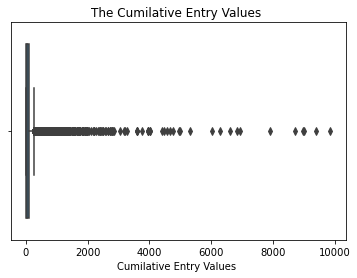

In [213]:
# Entry Cumilative values
(sns.boxplot(x=noZerosNoNegatives.Entries_Diff, data= mta_diffs)
 .set(xlabel = 'Cumilative Entry Values ', 
      title = "The Cumilative Entry Values "));

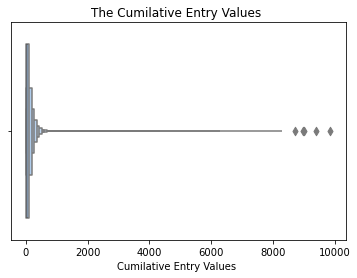

In [214]:
# Entry Cumilative values
(sns.boxenplot(x = 'Entries_Diff', data = noZerosNoNegatives, 
               palette = "pastel")
          .set(xlabel = 'Cumilative Entry Values ', 
           title = "The Cumilative Entry Values "));

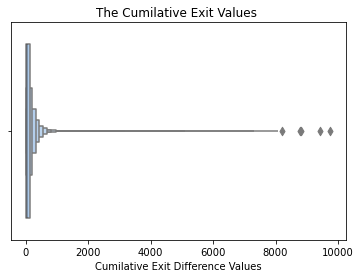

In [215]:
# Exit Cumilative values
(sns.boxenplot(x = 'Exits_Diff', data = noZerosNoNegatives, 
               palette = "pastel")
          .set(xlabel = 'Cumilative Exit Difference Values', 
           title = "The Cumilative Exit Values "));


## 1. Group by Station Location and Look at the median values

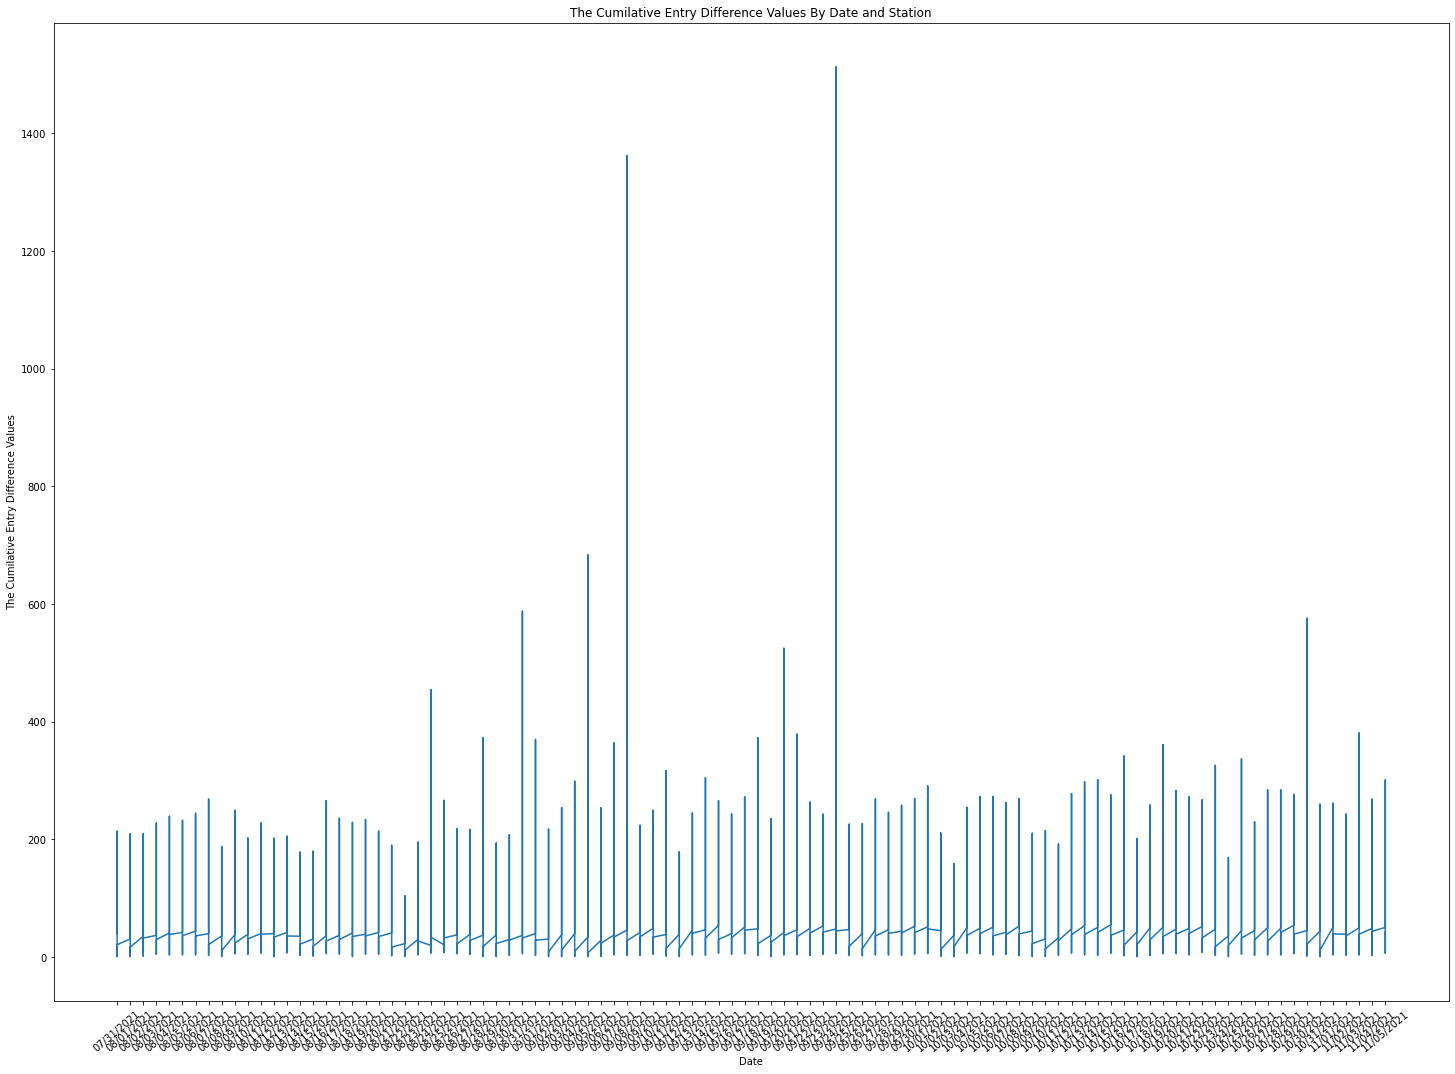

In [216]:
# Entries by Station Location and Date
station_entries = noZerosNoNegatives.groupby(["Date", "Station_loc"])['Entries_Diff'].median().reset_index()

plt.figure(figsize = (25,18))
plt.plot(station_entries.Date, station_entries.Entries_Diff)

plt.ylabel('The Cumilative Entry Difference Values')
plt.xlabel('Date')
plt.xticks(rotation=40)
plt.title('The Cumilative Entry Difference Values By Date and Station');

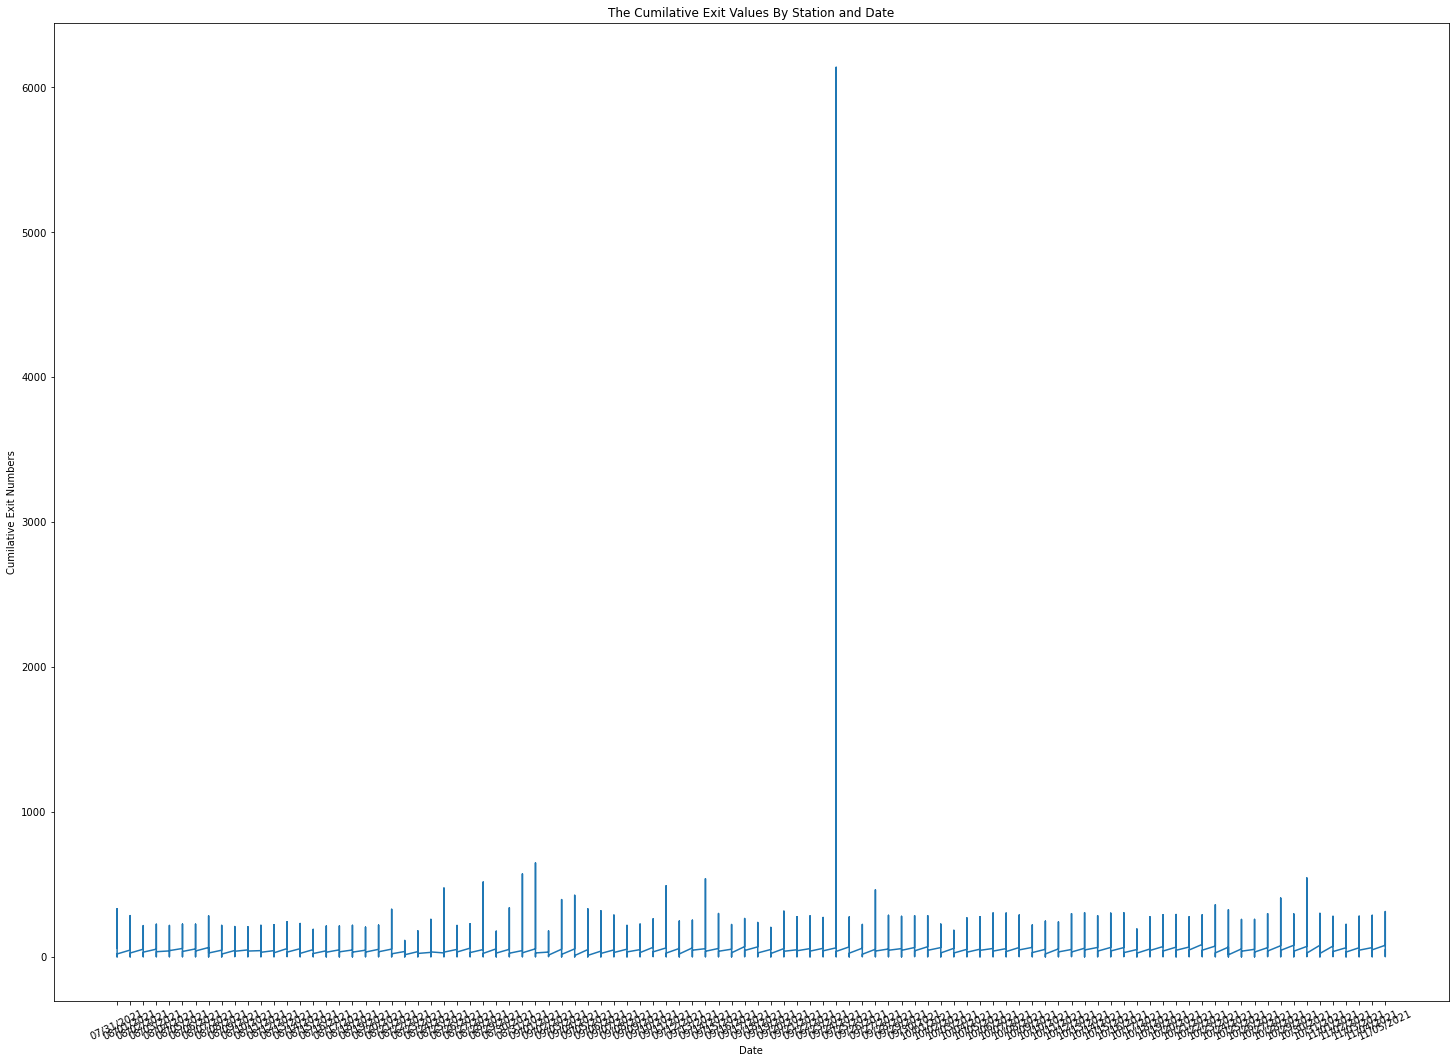

In [217]:
# Entries by Station Location and Date
station_exits = noZerosNoNegatives.groupby(["Date", "Station_loc"])['Exits_Diff'].median().reset_index()

plt.figure(figsize = (25,18))
plt.plot(station_exits.Date, station_exits.Exits_Diff)

plt.ylabel('Cumilative Exit Numbers')
plt.xlabel('Date')
plt.xticks(rotation=25)
plt.title('The Cumilative Exit Values By Station and Date');

In [231]:
#Not normal entry for such a day
station_exits[station_exits.Exits_Diff == station_exits.Exits_Diff.max()]

Date     Station_loc  Exits_Diff
26368  09/24/2021  NEWARK HM HE 1      6137.0

## 2. By Date

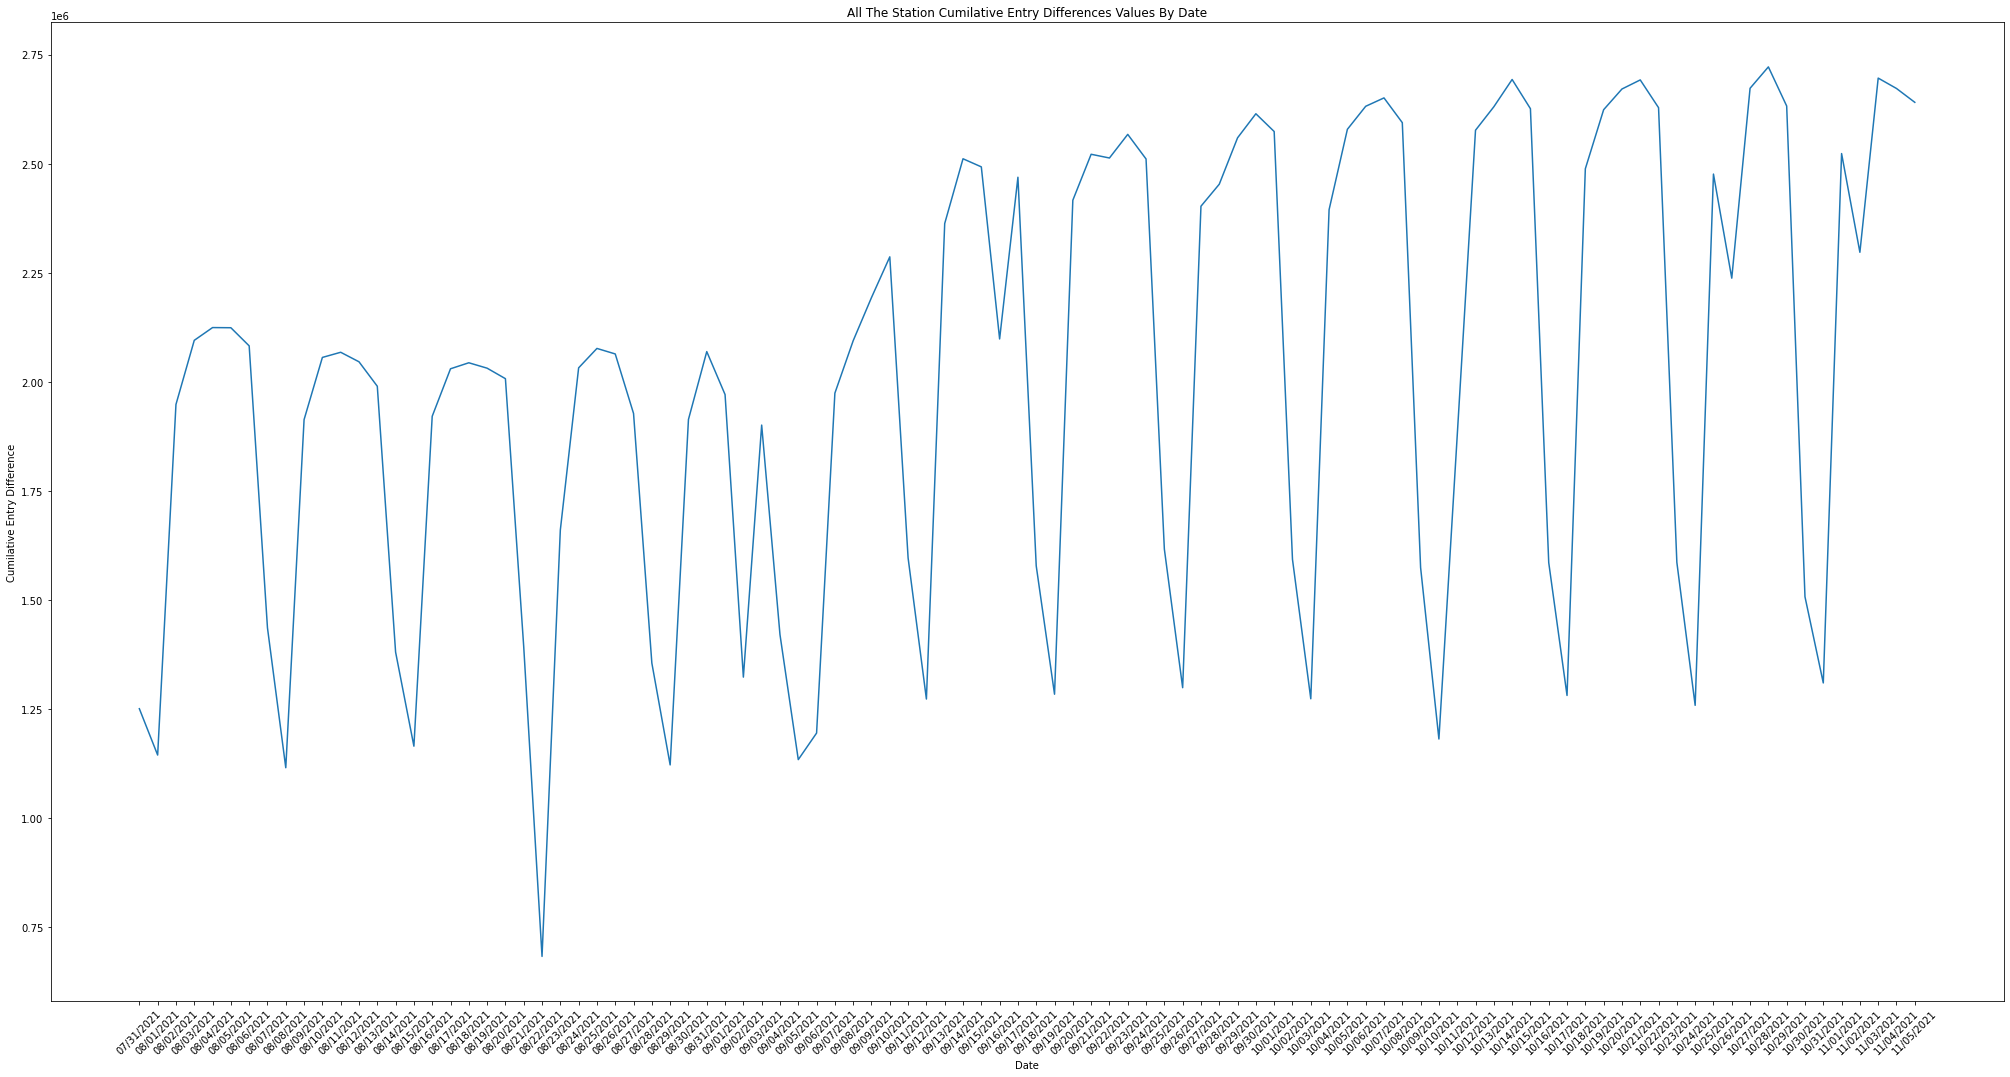

In [218]:
# Entries by Date
by_date = noZerosNoNegatives.groupby('Date')['Entries_Diff'].sum().reset_index()

plt.figure(figsize = (35,18))
plt.plot(by_date.Date, by_date.Entries_Diff)

plt.ylabel('Cumilative Entry Difference')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Differences Values By Date');

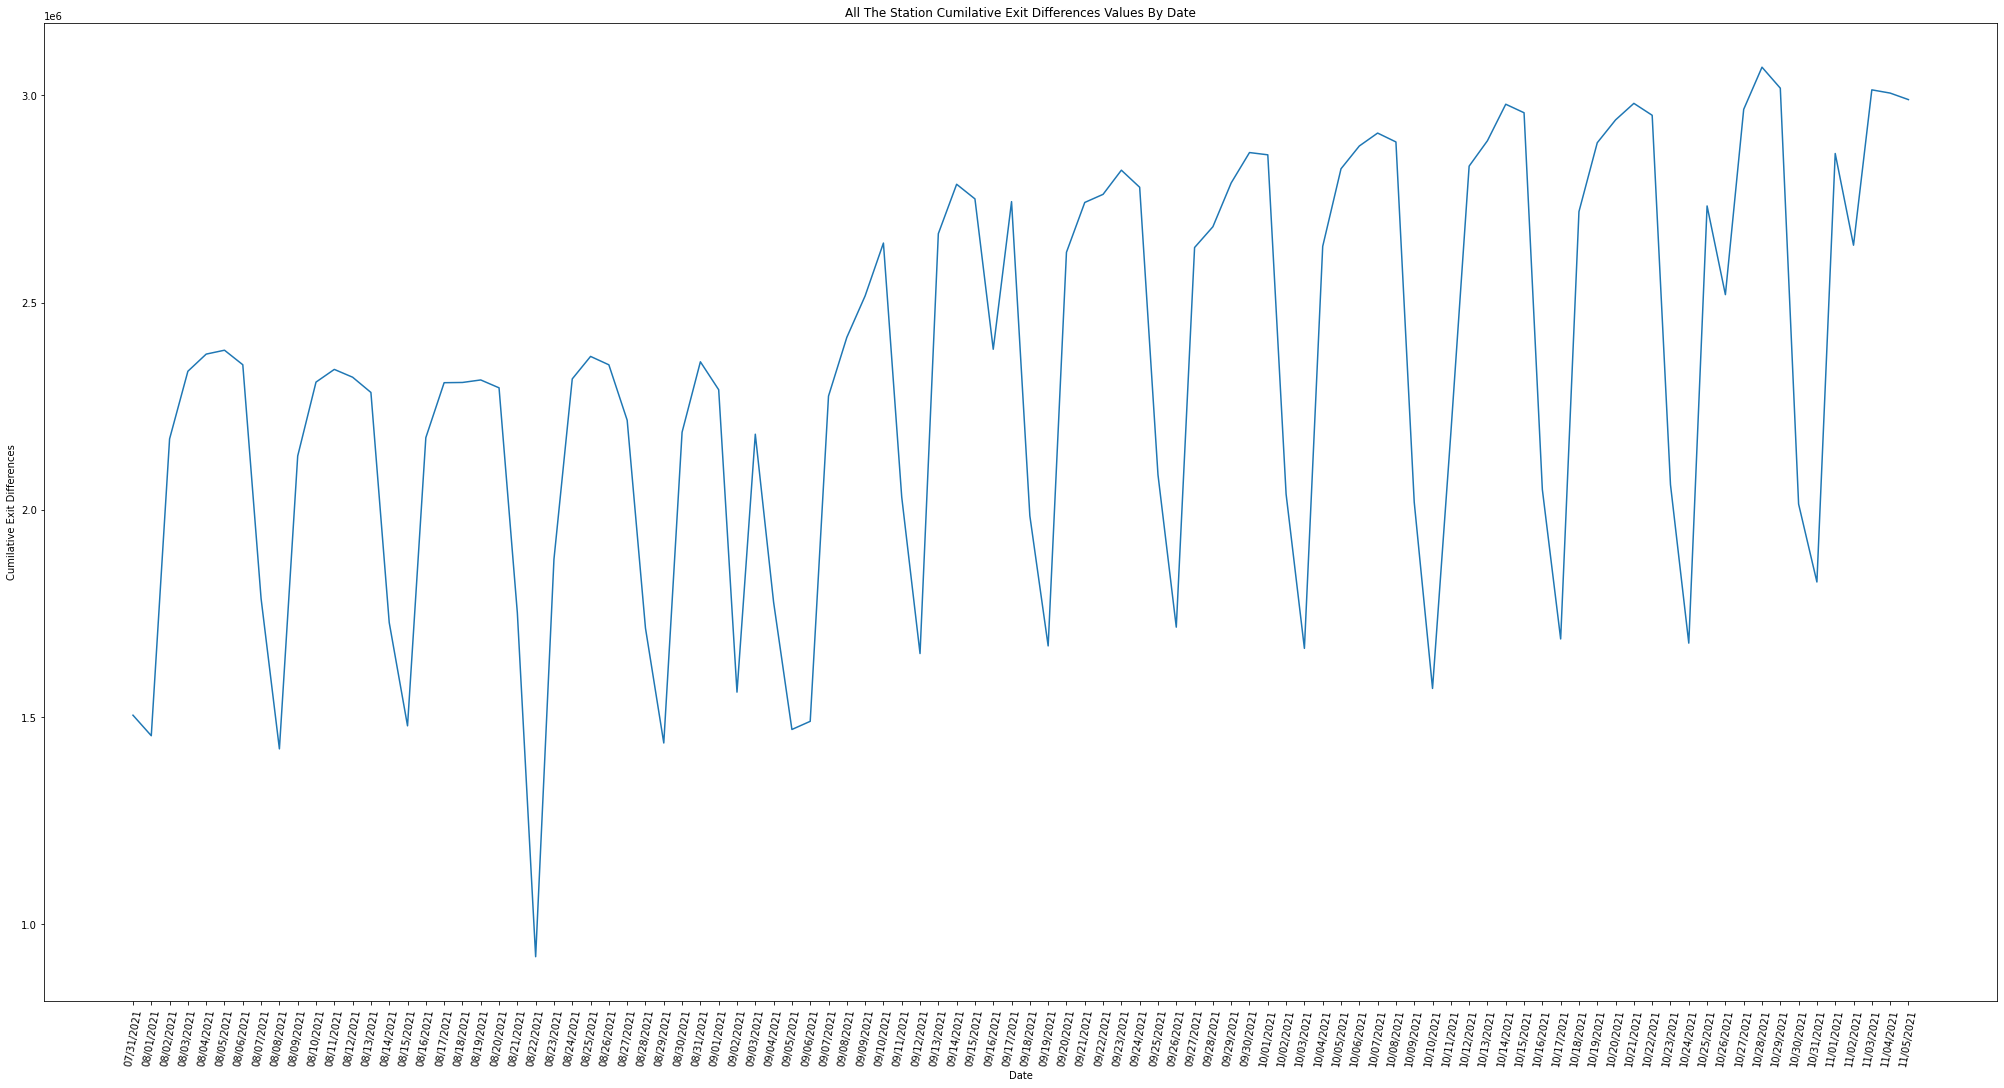

In [219]:
# Exits by median
date_exits = noZerosNoNegatives.groupby('Date')['Exits_Diff'].sum().reset_index()

plt.figure(figsize = (35,18))
plt.plot(date_exits.Date, date_exits.Exits_Diff)

plt.ylabel('Cumilative Exit Differences')
plt.xlabel('Date')
plt.xticks(rotation=80)
plt.title('All The Station Cumilative Exit Differences Values By Date');

## 3. Group by Day Name [Mon, Tue...]

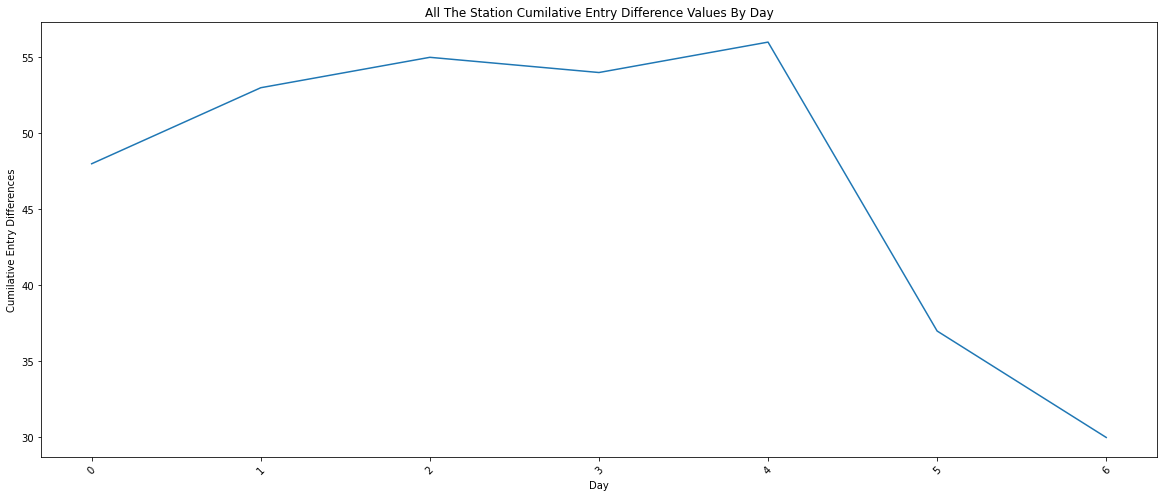

In [220]:
#By Day Name
day_name = noZerosNoNegatives.groupby('Day#')['Entries_Diff'].median().reset_index()

plt.figure(figsize = (20,8))
plt.plot(day_name['Day#'], day_name.Entries_Diff)

plt.ylabel('Cumilative Entry Differences')
plt.xlabel('Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Difference Values By Day');

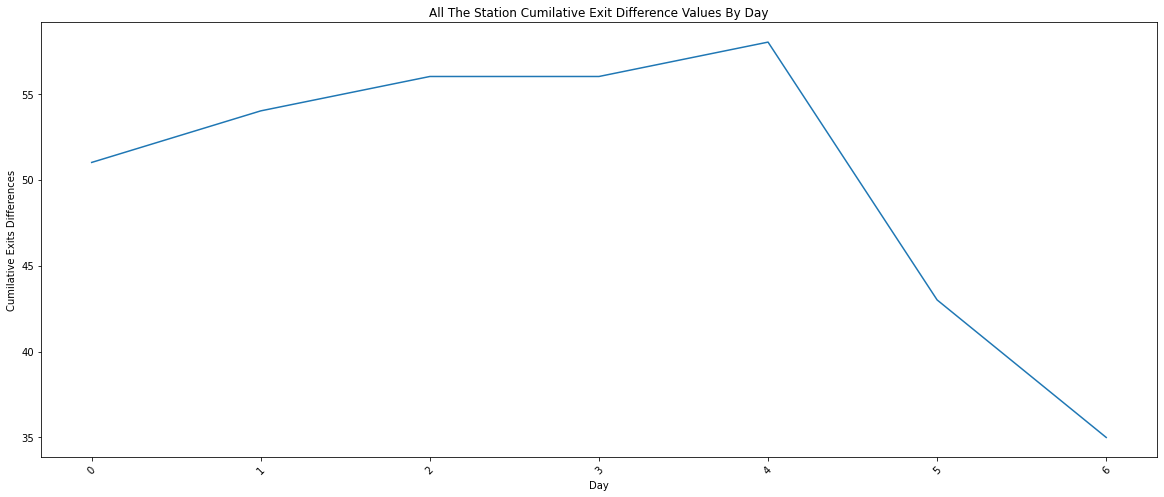

In [221]:
#By Day Name
day_nameExit = noZerosNoNegatives.groupby('Day#')['Exits_Diff'].median().reset_index()

plt.figure(figsize = (20,8))
plt.plot(day_nameExit['Day#'], day_nameExit.Exits_Diff)

plt.ylabel('Cumilative Exits Differences')
plt.xlabel('Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Exit Difference Values By Day');

## 5. Group by Hour of day

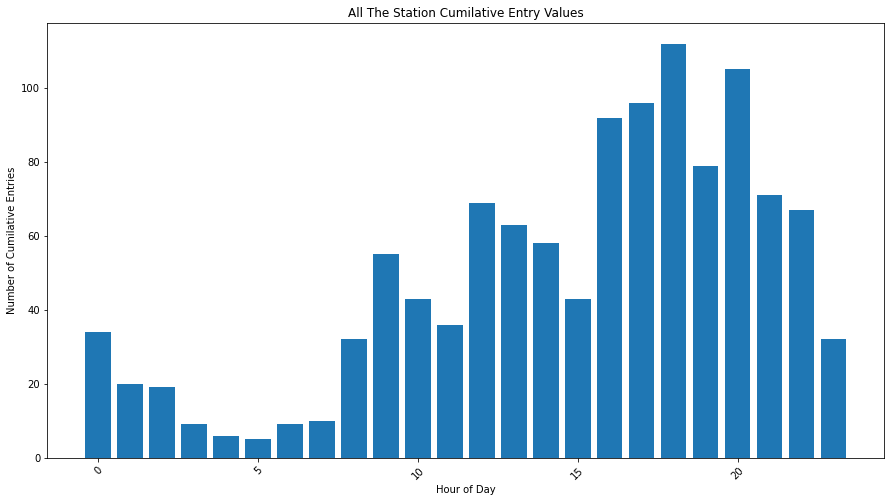

In [222]:
#By Hour of Day
hour_dayEntries = noZerosNoNegatives.groupby('Hour')['Entries_Diff'].median().reset_index()

plt.figure(figsize = (15,8))
plt.bar(hour_dayEntries.Hour, hour_dayEntries.Entries_Diff)

plt.ylabel('Number of Cumilative Entries')
plt.xlabel('Hour of Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Values');

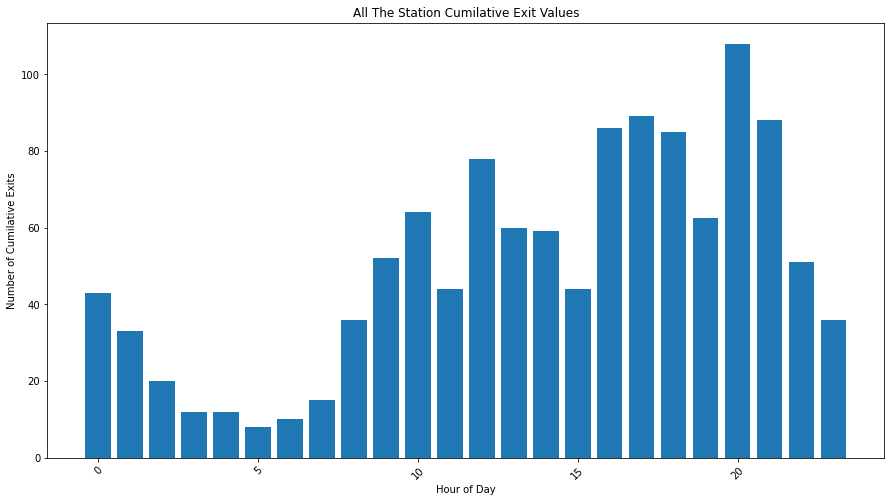

In [223]:
#By Hour of Day
hour_day = noZerosNoNegatives.groupby('Hour')['Exits_Diff'].median().reset_index()

plt.figure(figsize = (15,8))
plt.bar(hour_day.Hour, hour_day.Exits_Diff)

plt.ylabel('Number of Cumilative Exits')
plt.xlabel('Hour of Day')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Exit Values');

## 6. Finally, let's look at it grouped by Turnstile

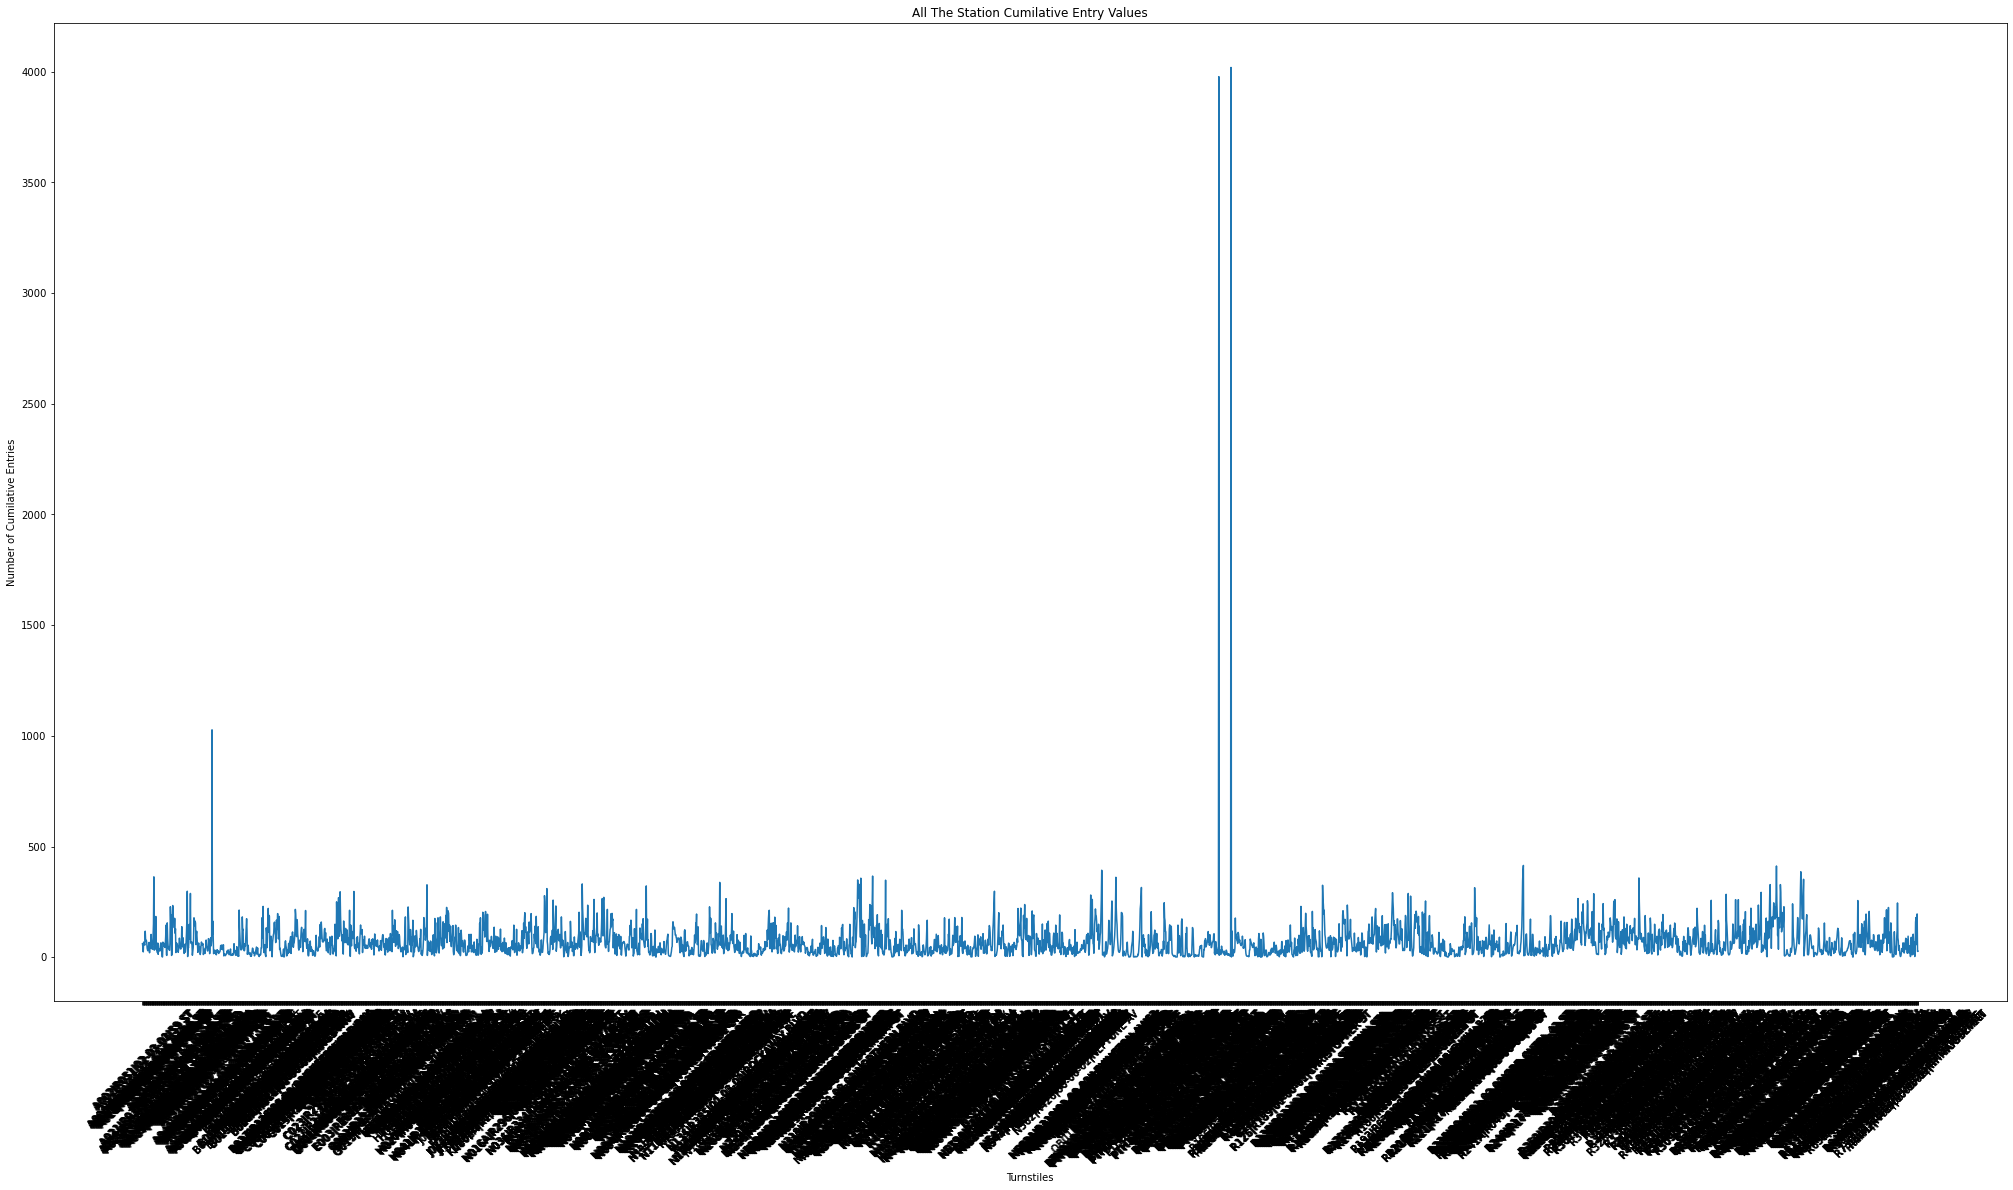

In [224]:
#By Turnstile
by_turnstile = noZerosNoNegatives.groupby('Turnstile')['Entries_Diff'].median().reset_index()

plt.figure(figsize = (35,18))
plt.plot(by_turnstile.Turnstile, by_turnstile.Entries_Diff)

plt.ylabel('Number of Cumilative Entries')
plt.xlabel('Turnstiles')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Entry Values');

In [234]:
#This Newark Entry stands out
by_turnstile[by_turnstile.Entries_Diff == by_turnstile.Entries_Diff.max()]

Turnstile  Entries_Diff
2770  PTH20|R549|03-01-08|NEWARK HM HE        4019.0

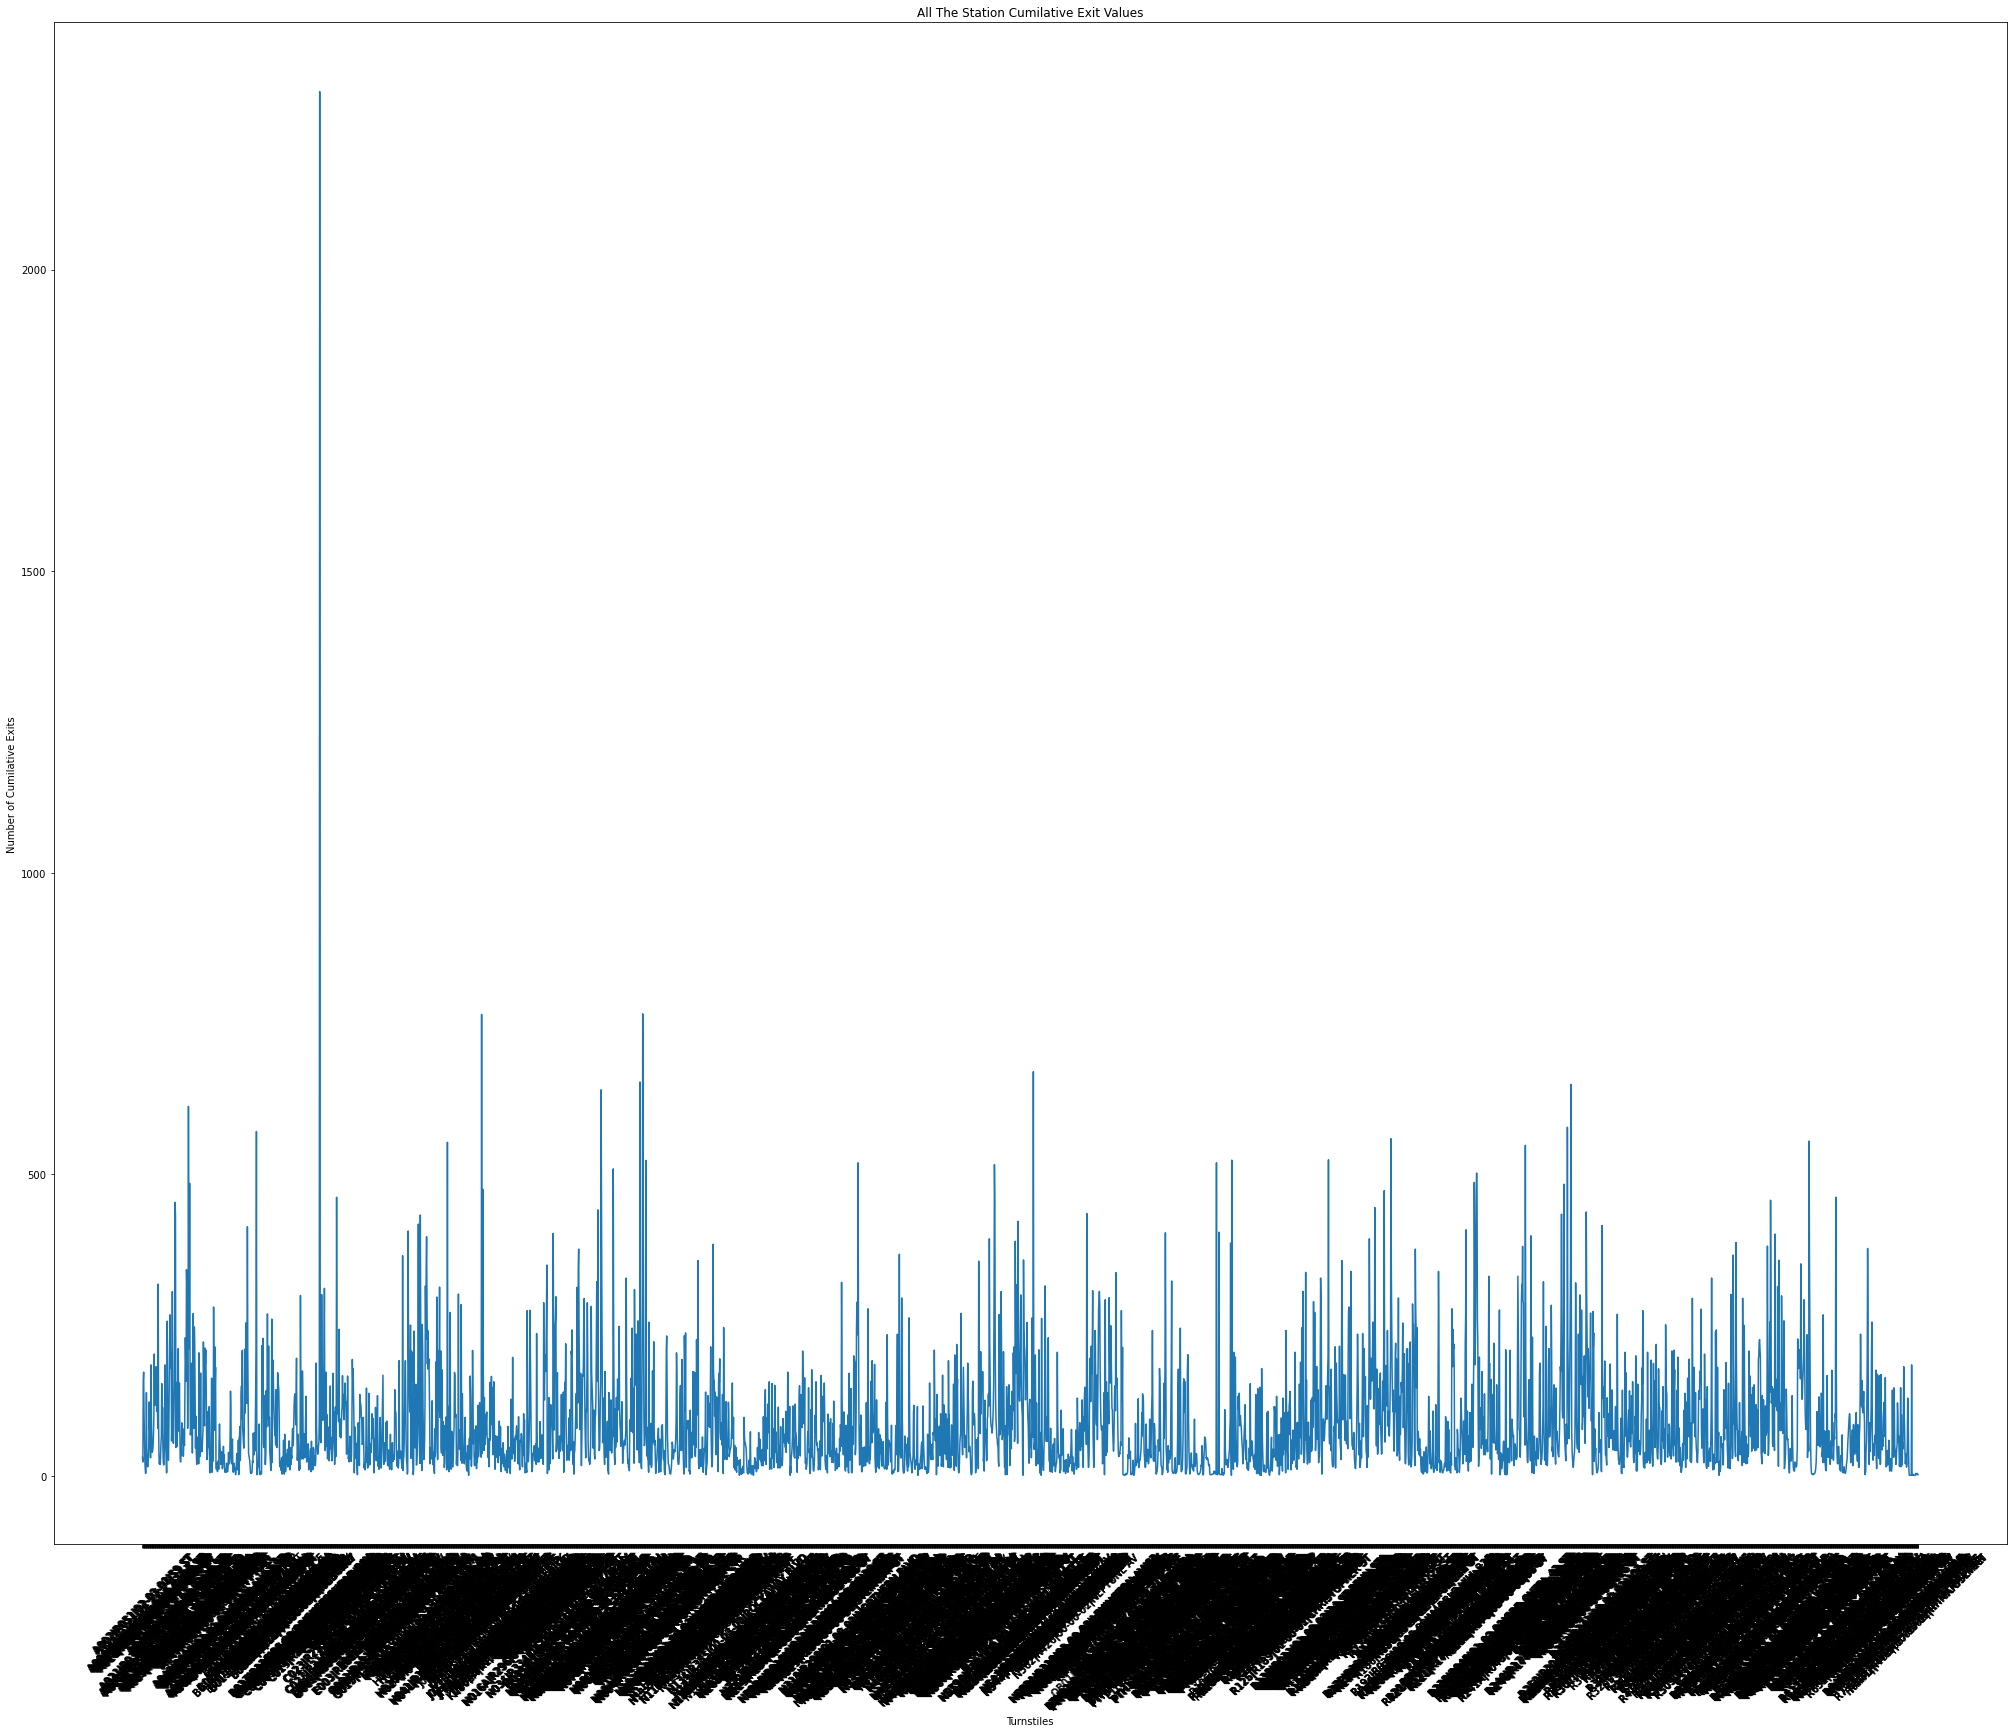

In [235]:
#By Turnstile
by_turnstile_exits = noZerosNoNegatives.groupby('Turnstile')['Exits_Diff'].median().reset_index()

plt.figure(figsize = (35,28))
plt.plot(by_turnstile_exits.Turnstile, by_turnstile_exits.Exits_Diff)

plt.ylabel('Number of Cumilative Exits')
plt.xlabel('Turnstiles')
plt.xticks(rotation=45)
plt.title('All The Station Cumilative Exit Values');

## Main question is what should be the outlier cutoff? 8K???

## Now, we can create a column to add the entries and exits over time to aggregate our hourly or daily foot traffic

In [237]:
#This will account for both Entries and Exits to use for Analysis 
noZerosNoNegatives["All_Differences"] = noZerosNoNegatives["Entries_Diff"] + noZerosNoNegatives["Exits_Diff"]
noZerosNoNegatives.sort_values('All_Differences', ascending=False).head(10)


index    C/A  Unit       Scp          Station Linename Division  \
1797487  128486  PTH22  R540  00-01-05     PATH NEW WTC        1      PTH   
1751814  125828  PTH17  R541  01-00-07  THIRTY THIRD ST        1      PTH   
588576    42884   J031  R006  00-00-03   WOODHAVEN BLVD       JZ      BMT   
1744286  124754  PTH16  R550  01-01-08       LACKAWANNA        1      PTH   
587118    42737   J031  R006  00-00-00   WOODHAVEN BLVD       JZ      BMT   
2683312  192786   R528  R097  00-00-04    JUNCTION BLVD        7      IRT   
1570821  113045  N601A  R319  01-03-01  LEXINGTON AV/63        F      IND   
1571835  113073  N601A  R319  01-03-03  LEXINGTON AV/63        F      IND   
1950043  140051   R141  R031  00-03-01   34 ST-PENN STA      123      IRT   
1732165  123594  PTH13  R541  00-04-04        THIRTY ST        1      PTH   

               Date      Time     Desc  ...  \
1797487  09/02/2021  15:00:42  REGULAR  ...   
1751814  10/25/2021  08:17:28  REGULAR  ...   
588576   09/11/2021  00:00:00  REGULAR  ...   
1744286  09/07/2021  08:54:05  REGULAR  ...   
587118   09/11/2021  00:00:00  REGULAR  ...   
2683312  09/18/2021  00:00:00  REGULAR  ...   
1570821  10/14/2021  12:00:00  REGULAR  ...   
1571835  10/14/2021  12:00:00  REGULAR  ...   
1950043  08/23/2021  16:00:00  REGULAR  ...   
1732165  11/03/2021  19:49:35  REGULAR  ...   

                                   Turnstile         Station_loc  \
1797487     PTH22|R540|00-01-05|PATH NEW WTC      PATH NEW WTC 1   
1751814  PTH17|R541|01-00-07|THIRTY THIRD ST   THIRTY THIRD ST 1   
588576     J031|R006|00-00-03|WOODHAVEN BLVD   WOODHAVEN BLVD JZ   
1744286       PTH16|R550|01-01-08|LACKAWANNA        LACKAWANNA 1   
587118     J031|R006|00-00-00|WOODHAVEN BLVD   WOODHAVEN BLVD JZ   
2683312     R528|R097|00-00-04|JUNCTION BLVD     JUNCTION BLVD 7   
1570821  N601A|R319|01-03-01|LEXINGTON AV/63   LEXINGTON AV/63 F   
1571835  N601A|R319|01-03-03|LEXINGTON AV/63   LEXINGTON AV/63 F   
1950043    R141|R031|00-03-01|34 ST-PENN STA  34 ST-PENN STA 123   
1732165        PTH13|R541|00-04-04|THIRTY ST         THIRTY ST 1   

                  DateNTime  Day Day#  DayType  Hour Entries_Diff  Exits_Diff  \
1797487 2021-09-02 15:00:42  Thu    3  WeekDay    15       8962.0      9436.0   
1751814 2021-10-25 08:17:28  Mon    0  WeekDay     8       8713.0      8811.0   
588576  2021-09-11 00:00:00  Sat    5  WeekEnd     0       6840.0      6667.0   
1744286 2021-09-07 08:54:05  Tue    1  WeekDay     8       9397.0      3544.0   
587118  2021-09-11 00:00:00  Sat    5  WeekEnd     0       4968.0      7893.0   
2683312 2021-09-18 00:00:00  Sat    5  WeekEnd     0       9014.0      3721.0   
1570821 2021-10-14 12:00:00  Thu    3  WeekDay    12       2648.0      9752.0   
1571835 2021-10-14 12:00:00  Thu    3  WeekDay    12       6609.0      5544.0   
1950043 2021-08-23 16:00:00  Mon    0  WeekDay    16       4760.0      6958.0   
1732165 2021-11-03 19:49:35  Wed    2  WeekDay    19       9859.0      1796.0   

         All_Differences  
1797487          18398.0  
1751814          17524.0  
588576           13507.0  
1744286          12941.0  
587118           12861.0  
2683312          12735.0  
1570821          12400.0  
1571835          12153.0  
1950043          11718.0  
1732165          11655.0  

[10 rows x 22 columns]

In [239]:
noZerosNoNegatives.columns

Index(['index', 'C/A', 'Unit', 'Scp', 'Station', 'Linename', 'Division',
       'Date', 'Time', 'Desc', 'Entries', 'Exits', 'Turnstile', 'Station_loc',
       'DateNTime', 'Day', 'Day#', 'DayType', 'Hour', 'Entries_Diff',
       'Exits_Diff', 'All_Differences'],
      dtype='object')

In [ ]:
## Now Answer Questions

In [238]:
#Group our data to see our resuls
station_daily = noZerosNoNegatives.groupby(["Station", "Date"])[['All_Differences']].sum().reset_index()
station_daily.head()


Station        Date  All_Differences
0    1 AV  07/31/2021          16293.0
1    1 AV  08/01/2021          17519.0
2    1 AV  08/02/2021          19950.0
3    1 AV  08/03/2021          21202.0
4    1 AV  08/04/2021          22065.0

In [240]:
#Group our data to see our resuls
station_daily2 = noZerosNoNegatives.groupby(["Station_loc","Turnstile","DateNTime","Date", "Hour","Day", "Day#"])[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().reset_index()
station_daily2.head()


Station_loc                 Turnstile           DateNTime        Date  Hour  \
0      1 AV L  H007A|R248|02-00-00|1 AV 2021-07-31 04:00:00  07/31/2021     4   
1      1 AV L  H007A|R248|02-00-00|1 AV 2021-07-31 08:00:00  07/31/2021     8   
2      1 AV L  H007A|R248|02-00-00|1 AV 2021-07-31 12:00:00  07/31/2021    12   
3      1 AV L  H007A|R248|02-00-00|1 AV 2021-07-31 16:00:00  07/31/2021    16   
4      1 AV L  H007A|R248|02-00-00|1 AV 2021-07-31 20:00:00  07/31/2021    20   

   Day  Day#  Entries_Diff  Exits_Diff  All_Differences  
0  Sat     5          49.0        20.0             69.0  
1  Sat     5          25.0        12.0             37.0  
2  Sat     5         149.0        13.0            162.0  
3  Sat     5         206.0        45.0            251.0  
4  Sat     5         204.0        42.0            246.0

## By Station Totals ALL DAYS

In [242]:
station_totals20 = station_daily2.groupby('Station_loc')[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()[:20]

station_totals20.head(10)

Station_loc  Entries_Diff  Exits_Diff  All_Differences
0      34 ST-HERALD SQ BDFMNQRW     3536780.0   4874150.0        8410930.0
1         GRD CNTRL-42 ST 4567S     3371220.0   4944315.0        8315535.0
2  42 ST-PORT AUTH ACENQRS1237W     2780311.0   3384811.0        6165122.0
3            34 ST-PENN STA ACE     2405905.0   3288205.0        5694110.0
4               FLUSHING-MAIN 7     2540775.0   2917891.0        5458666.0
5       14 ST-UNION SQ LNQR456W     2085177.0   2894301.0        4979478.0
6         JKSN HT-ROOSVLT EFMR7     2252174.0   2261505.0        4513679.0
7   TIMES SQ-42 ST 1237ACENQRSW     1544408.0   2468804.0        4013212.0
8          59 ST COLUMBUS ABCD1     1806714.0   2196618.0        4003332.0
9            FULTON ST 2345ACJZ     1639314.0   2348932.0        3988246.0

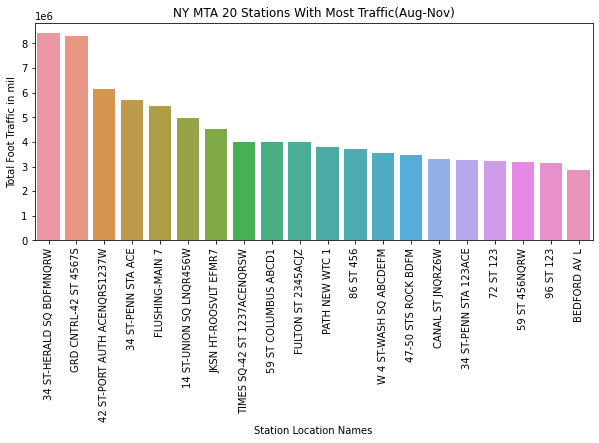

In [244]:
plt.figure(figsize=(10,4))
sns.barplot(x=station_totals20['Station_loc'], y=station_totals20['All_Differences'])
plt.title('NY MTA 20 Stations With Most Traffic(Aug-Nov)')
plt.xlabel('Station Location Names')
plt.ylabel('Total Foot Traffic in mil')
plt.xticks(rotation=90);


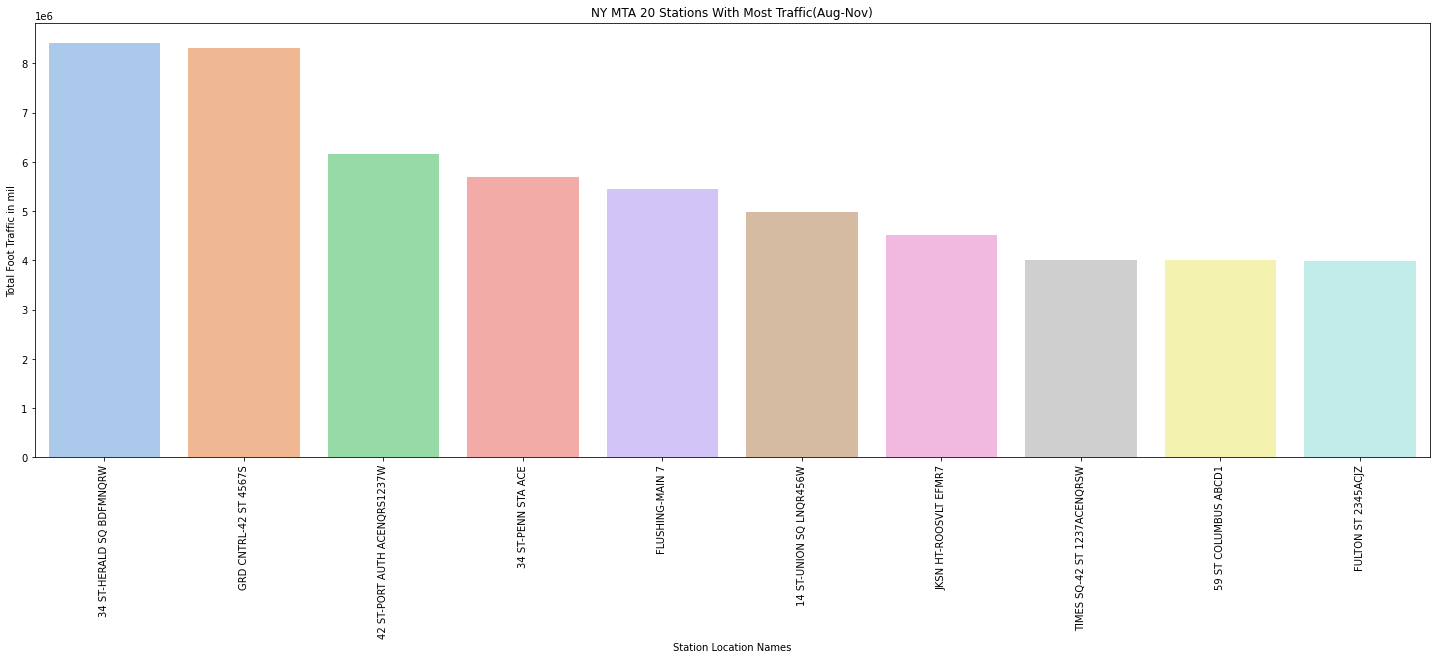

In [248]:
plt.figure(figsize=(25,8))
sns.barplot(x=station_totals20['Station_loc'][:10], y=station_totals20['All_Differences'][:10], palette='pastel')
plt.title('NY MTA 20 Stations With Most Traffic(Aug-Nov)')
plt.xlabel('Station Location Names')
plt.ylabel('Total Foot Traffic in mil')
plt.xticks(rotation=90);


## By Day  ALL DAYS

In [249]:
by_day = station_daily2.groupby('Day')[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()[:20]

by_day.head(10)

Day  Entries_Diff  Exits_Diff  All_Differences
0  Wed    33246195.0  37086540.0       70332735.0
1  Fri    32870801.0  37152944.0       70023745.0
2  Thu    32493123.0  36455340.0       68948463.0
3  Tue    32057729.0  35802501.0       67860230.0
4  Mon    29493937.0  33086810.0       62580747.0
5  Sat    20877551.0  26544172.0       47421723.0
6  Sun    16528459.0  21658714.0       38187173.0

''

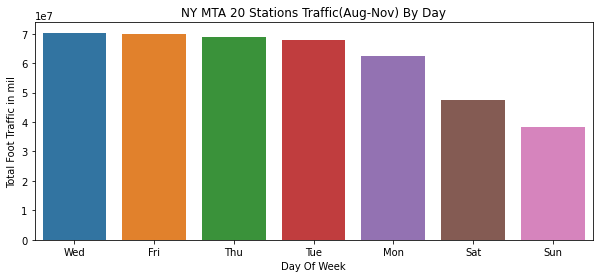

In [253]:
plt.figure(figsize=(10,4))
sns.barplot(x=by_day['Day'], y=by_day['All_Differences'])
plt.title('NY MTA 20 Stations Traffic(Aug-Nov) By Day')
plt.xlabel('Day Of Week')
plt.ylabel('Total Foot Traffic in mil')
;

''

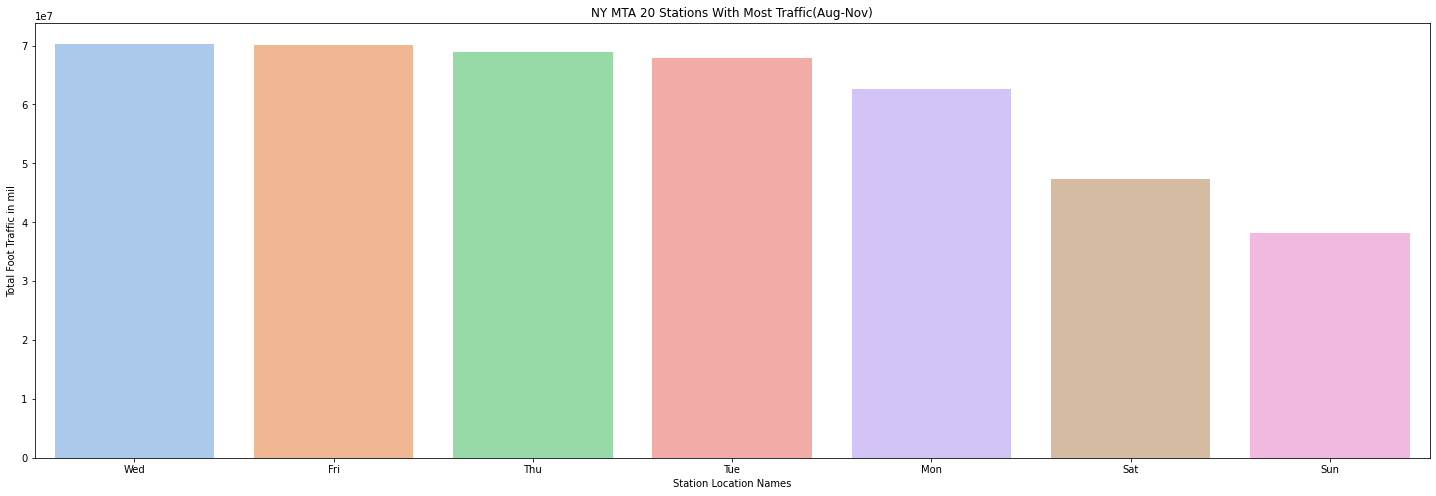

In [256]:
plt.figure(figsize=(25,8))
sns.barplot(x=by_day['Day'][:10], y=by_day['All_Differences'][:10], palette='pastel')
plt.title('NY MTA 20 Stations With Most Traffic(Aug-Nov)')
plt.xlabel('Station Location Names')
plt.ylabel('Total Foot Traffic in mil');

## By Hour  ALL DAYS

In [258]:
by_hour = station_daily2.groupby('Hour')[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()

by_hour.head(10)

Hour  Entries_Diff  Exits_Diff  All_Differences
0    20    32253009.0  39137046.0       71390055.0
1    16    26896769.0  29325883.0       56222652.0
2    12    23957331.0  29260926.0       53218257.0
3    17    20718353.0  21412386.0       42130739.0
4    21    16891713.0  21828921.0       38720634.0
5     9    16198391.0  14816160.0       31014551.0
6     8    17178292.0  13626609.0       30804901.0
7    13    13204521.0  16044350.0       29248871.0
8     0    11090749.0  16289711.0       27380460.0
9     1     5315797.0   8099210.0       13415007.0

''

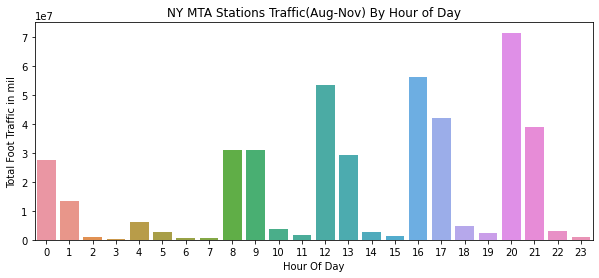

In [260]:
plt.figure(figsize=(10,4))
sns.barplot(x=by_hour['Hour'], y=by_hour['All_Differences'])
plt.title('NY MTA Stations Traffic(Aug-Nov) By Hour of Day')
plt.xlabel('Hour Of Day')
plt.ylabel('Total Foot Traffic in mil')
;

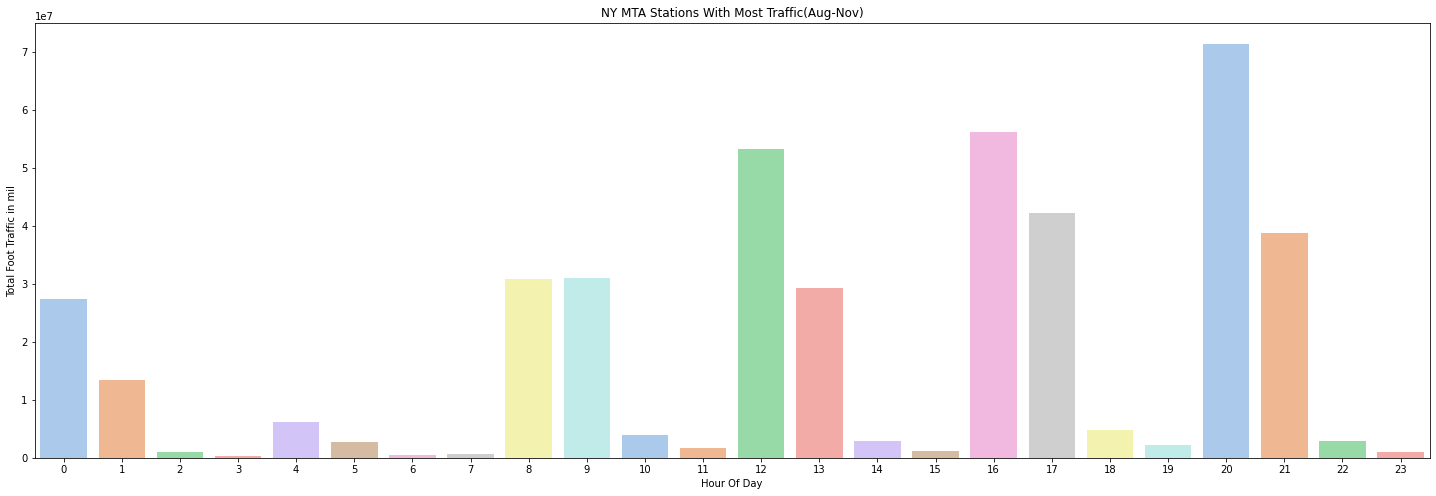

In [265]:
plt.figure(figsize=(25,8))
sns.barplot(x=by_hour['Hour'], y=by_hour['All_Differences'], palette='pastel')
plt.title('NY MTA Stations With Most Traffic(Aug-Nov)')
plt.xlabel('Hour Of Day')
plt.ylabel('Total Foot Traffic in mil');

In [270]:
noZerosNoNegatives.columns

Index(['index', 'C/A', 'Unit', 'Scp', 'Station', 'Linename', 'Division',
       'Date', 'Time', 'Desc', 'Entries', 'Exits', 'Turnstile', 'Station_loc',
       'DateNTime', 'Day', 'Day#', 'DayType', 'Hour', 'Entries_Diff',
       'Exits_Diff', 'All_Differences'],
      dtype='object')

In [272]:
noZerosNoNegatives.DayType.unique()

array(['WeekEnd', 'WeekDay'], dtype=object)

In [273]:
noZerosNoNegatives.shape

(2374122, 22)

## Use only Weekdays

In [274]:
weekdays = noZerosNoNegatives[noZerosNoNegatives['DayType'] == 'WeekDay']
weekdays.shape

(1715565, 22)

## By Station Totals WEEKDAYS

In [275]:
station_totals20 = weekdays.groupby('Station_loc')[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()[:20]

weekdays.head(10)

index   C/A  Unit       Scp Station Linename Division        Date  \
12     12  A002  R051  02-00-00   59 ST  NQR456W      BMT  08/02/2021   
13     13  A002  R051  02-00-00   59 ST  NQR456W      BMT  08/02/2021   
14     14  A002  R051  02-00-00   59 ST  NQR456W      BMT  08/02/2021   
15     15  A002  R051  02-00-00   59 ST  NQR456W      BMT  08/02/2021   
16     16  A002  R051  02-00-00   59 ST  NQR456W      BMT  08/02/2021   
17     17  A002  R051  02-00-00   59 ST  NQR456W      BMT  08/02/2021   
18     18  A002  R051  02-00-00   59 ST  NQR456W      BMT  08/03/2021   
19     19  A002  R051  02-00-00   59 ST  NQR456W      BMT  08/03/2021   
20     20  A002  R051  02-00-00   59 ST  NQR456W      BMT  08/03/2021   
21     21  A002  R051  02-00-00   59 ST  NQR456W      BMT  08/03/2021   

        Time     Desc  ...                 Turnstile    Station_loc  \
12  00:00:00  REGULAR  ...  A002|R051|02-00-00|59 ST  59 ST NQR456W   
13  04:00:00  REGULAR  ...  A002|R051|02-00-00|59 ST  59 ST NQR456W   
14  08:00:00  REGULAR  ...  A002|R051|02-00-00|59 ST  59 ST NQR456W   
15  12:00:00  REGULAR  ...  A002|R051|02-00-00|59 ST  59 ST NQR456W   
16  16:00:00  REGULAR  ...  A002|R051|02-00-00|59 ST  59 ST NQR456W   
17  20:00:00  REGULAR  ...  A002|R051|02-00-00|59 ST  59 ST NQR456W   
18  00:00:00  REGULAR  ...  A002|R051|02-00-00|59 ST  59 ST NQR456W   
19  04:00:00  REGULAR  ...  A002|R051|02-00-00|59 ST  59 ST NQR456W   
20  08:00:00  REGULAR  ...  A002|R051|02-00-00|59 ST  59 ST NQR456W   
21  12:00:00  REGULAR  ...  A002|R051|02-00-00|59 ST  59 ST NQR456W   

             DateNTime  Day Day#  DayType  Hour Entries_Diff  Exits_Diff  \
12 2021-08-02 00:00:00  Mon    0  WeekDay     0         25.0        13.0   
13 2021-08-02 04:00:00  Mon    0  WeekDay     4          3.0         2.0   
14 2021-08-02 08:00:00  Mon    0  WeekDay     8         17.0        51.0   
15 2021-08-02 12:00:00  Mon    0  WeekDay    12         59.0       118.0   
16 2021-08-02 16:00:00  Mon    0  WeekDay    16        157.0        43.0   
17 2021-08-02 20:00:00  Mon    0  WeekDay    20        273.0        28.0   
18 2021-08-03 00:00:00  Tue    1  WeekDay     0         68.0        15.0   
19 2021-08-03 04:00:00  Tue    1  WeekDay     4          5.0         2.0   
20 2021-08-03 08:00:00  Tue    1  WeekDay     8          9.0        50.0   
21 2021-08-03 12:00:00  Tue    1  WeekDay    12         72.0       147.0   

    All_Differences  
12             38.0  
13              5.0  
14             68.0  
15            177.0  
16            200.0  
17            301.0  
18             83.0  
19              7.0  
20             59.0  
21            219.0  

[10 rows x 22 columns]

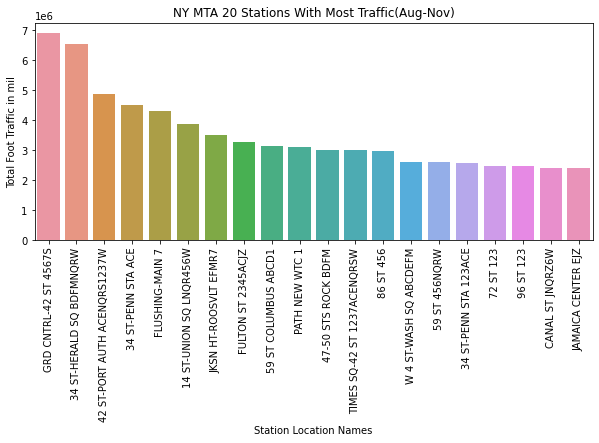

In [276]:
plt.figure(figsize=(10,4))
sns.barplot(x=station_totals20['Station_loc'], y=station_totals20['All_Differences'])
plt.title('NY MTA 20 Stations With Most Traffic(Aug-Nov) WEEKDAYS')
plt.xlabel('Station Location Names')
plt.ylabel('Total Foot Traffic in mil')
plt.xticks(rotation=90);


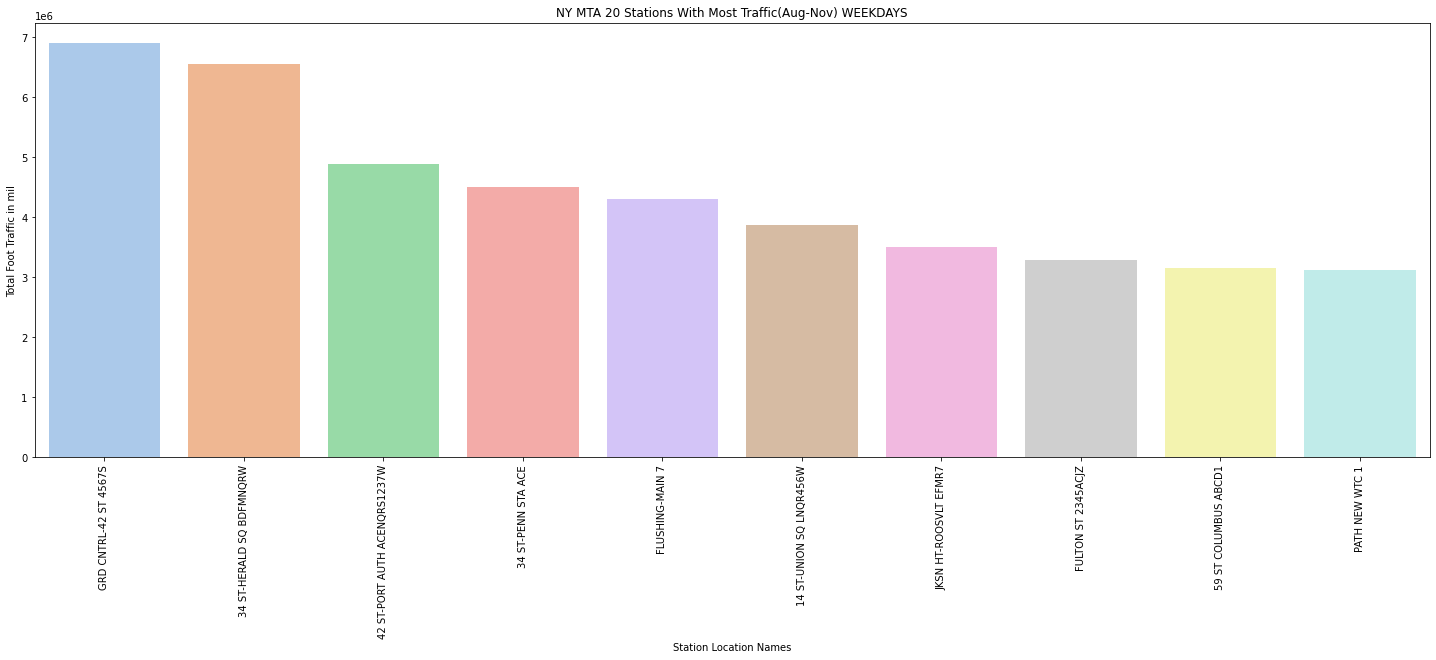

In [277]:
plt.figure(figsize=(25,8))
sns.barplot(x=station_totals20['Station_loc'][:10], y=station_totals20['All_Differences'][:10], palette='pastel')
plt.title('NY MTA 20 Stations With Most Traffic(Aug-Nov) WEEKDAYS')
plt.xlabel('Station Location Names')
plt.ylabel('Total Foot Traffic in mil')
plt.xticks(rotation=90);


## By Day WEEKDAYS

In [278]:
by_day = weekdays.groupby('Day')[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()[:20]

by_day.head(10)

Day  Entries_Diff  Exits_Diff  All_Differences
0  Wed    33246195.0  37086540.0       70332735.0
1  Fri    32870801.0  37152944.0       70023745.0
2  Thu    32493123.0  36455340.0       68948463.0
3  Tue    32057729.0  35802501.0       67860230.0
4  Mon    29493937.0  33086810.0       62580747.0

''

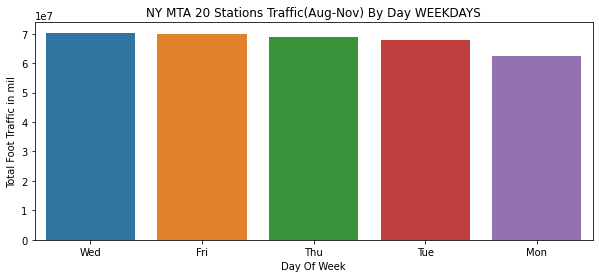

In [280]:
plt.figure(figsize=(10,4))
sns.barplot(x=by_day['Day'], y=by_day['All_Differences'])
plt.title('NY MTA 20 Stations Traffic(Aug-Nov) By Day WEEKDAYS')
plt.xlabel('Day Of Week')
plt.ylabel('Total Foot Traffic in mil')
;

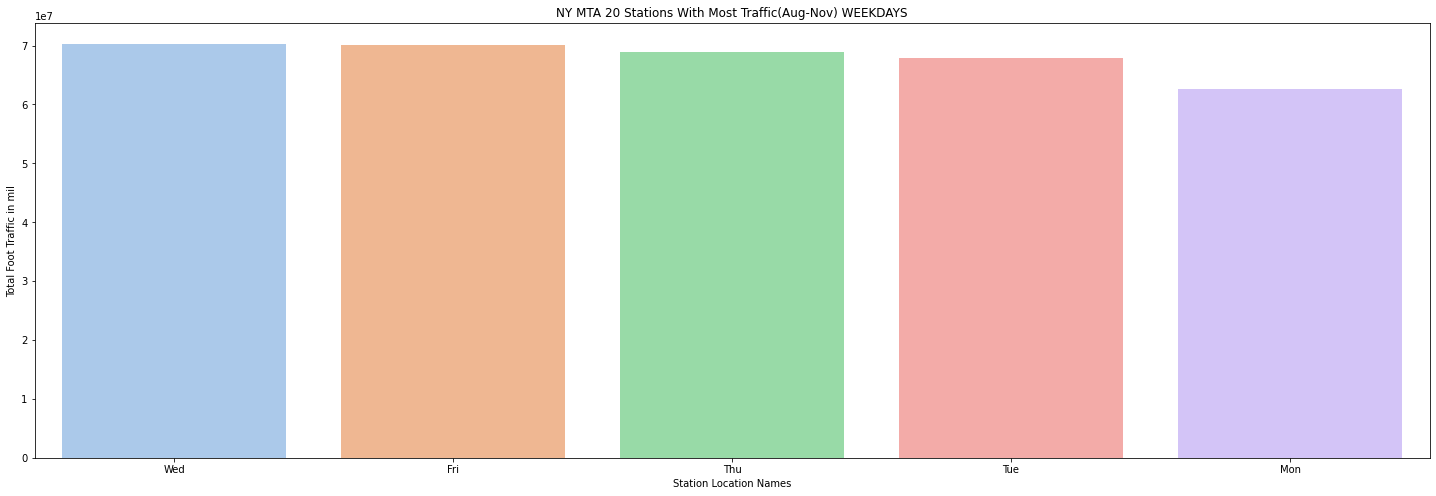

In [281]:
plt.figure(figsize=(25,8))
sns.barplot(x=by_day['Day'][:10], y=by_day['All_Differences'][:10], palette='pastel')
plt.title('NY MTA 20 Stations With Most Traffic(Aug-Nov) WEEKDAYS')
plt.xlabel('Station Location Names')
plt.ylabel('Total Foot Traffic in mil');

## By Hour WEEKDAYS

In [282]:
by_hour = weekdays.groupby('Hour')[['Entries_Diff', 'Exits_Diff','All_Differences']].sum().sort_values('All_Differences', ascending=False)\
    .reset_index()

by_hour.head(10)

Hour  Entries_Diff  Exits_Diff  All_Differences
0    20    26505914.0  31456051.0       57961965.0
1    12    19850032.0  24592151.0       44442183.0
2    16    21032302.0  21964863.0       42997165.0
3    17    16745436.0  16580249.0       33325685.0
4    21    13690251.0  17431655.0       31121906.0
5     9    14724340.0  13392211.0       28116551.0
6     8    15543808.0  12116549.0       27660357.0
7    13    10311398.0  12636338.0       22947736.0
8     0     7553659.0  10977563.0       18531222.0
9     1     3558080.0   5381771.0        8939851.0

''

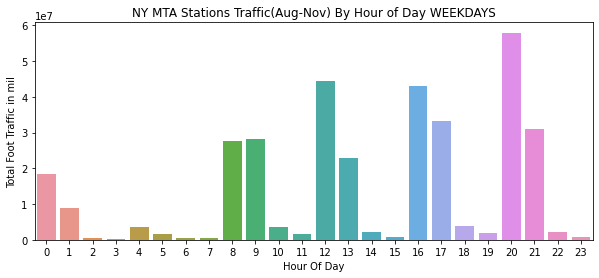

In [283]:
plt.figure(figsize=(10,4))
sns.barplot(x=by_hour['Hour'], y=by_hour['All_Differences'])
plt.title('NY MTA Stations Traffic(Aug-Nov) By Hour of Day WEEKDAYS')
plt.xlabel('Hour Of Day')
plt.ylabel('Total Foot Traffic in mil')
;

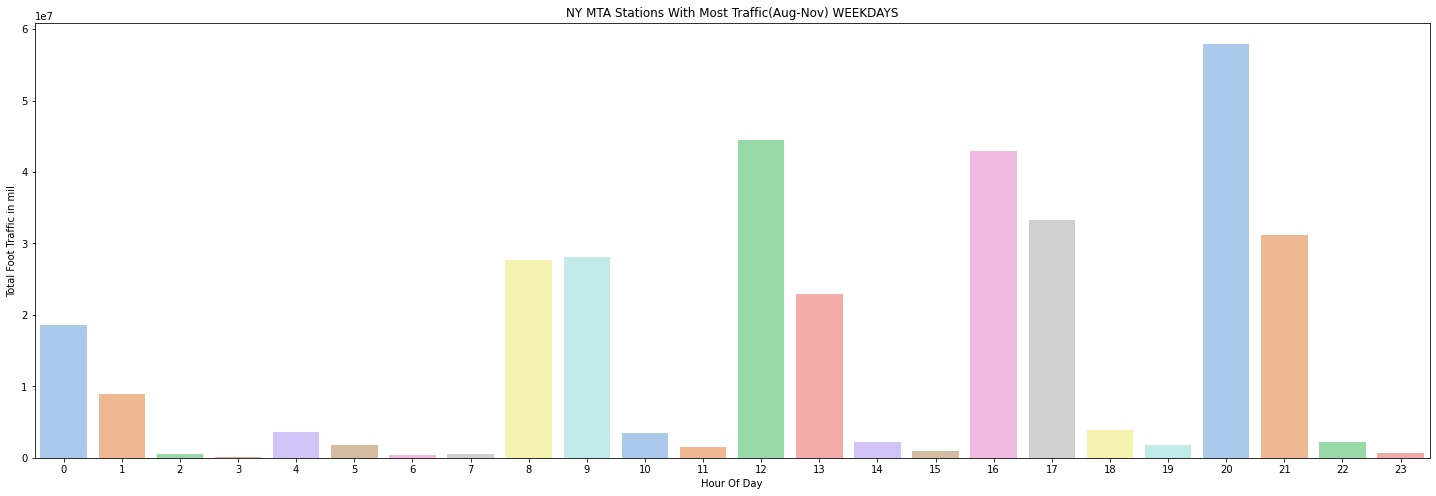

In [284]:
plt.figure(figsize=(25,8))
sns.barplot(x=by_hour['Hour'], y=by_hour['All_Differences'], palette='pastel')
plt.title('NY MTA Stations With Most Traffic(Aug-Nov) WEEKDAYS')
plt.xlabel('Hour Of Day')
plt.ylabel('Total Foot Traffic in mil');